In [1]:
%pip install --upgrade -e ../../.
%pip install datasets

Obtaining file:///root/peft
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for peft (pyproject.toml) ... done
  Created wheel for peft: filename=peft-0.6.0.dev1-0.editable-py3-none-any.whl size=12911 sha256=5f1020972d3731acdbe5af5547fff4cd195602a77dcb97773ffefffcd7d69ca1
  Stored in directory: /tmp/pip-ephem-wheel-cache-p57578wq/wheels/50/61/2f/c8d90f80efe6c7f0d9c25eb3c6fb64f6c5d2848dd643973058
Successfully built peft
  Attempting uninstall: peft
    Found existing installation: peft 0.6.0.dev1
    Uninstalling peft-0.6.0.dev1:
      Successfully uninstalled peft-0.6.0.dev1

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 23.3

In [2]:
from transformers import AutoModelForCausalLM

# from peft import get_peft_config, get_peft_model, PrefixTuningConfig, TaskType, PeftType
from peft import get_peft_config, get_peft_model, CoregPromptTuningConfig, TaskType, PeftType, LoraConfig,PromptEncoderConfig, PromptTuningConfig, PromptTuningInit

import torch
from datasets import load_dataset
import os
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
from transformers import default_data_collator, get_linear_schedule_with_warmup
from tqdm import tqdm
from datasets import load_dataset

device = "cuda"
model_name_or_path = "bigscience/bloomz-560m"
tokenizer_name_or_path = "bigscience/bloomz-560m"


dataset_name = "twitter_complaints"
# checkpoint_name = f"{dataset_name}_{model_name_or_path}_{peft_config.peft_type}_{peft_config.task_type}_v1.pt".replace(
#     "/", "_"
# )
text_column = "Tweet text"
label_column = "text_label"
max_length = 64
lr = 1e-2
num_epochs = 50
batch_size = 8

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from datasets import load_dataset

dataset = load_dataset("ought/raft", dataset_name)

classes = [k.replace("_", " ") for k in dataset["train"].features["Label"].names]
print(classes)
dataset = dataset.map(
    lambda x: {"text_label": [classes[label] for label in x["Label"]]},
    batched=True,
    num_proc=1,
)
print(dataset)
dataset["train"][0]

['Unlabeled', 'complaint', 'no complaint']
DatasetDict({
    train: Dataset({
        features: ['Tweet text', 'ID', 'Label', 'text_label'],
        num_rows: 50
    })
    test: Dataset({
        features: ['Tweet text', 'ID', 'Label', 'text_label'],
        num_rows: 3399
    })
})


{'Tweet text': '@HMRCcustomers No this is my first job',
 'ID': 0,
 'Label': 2,
 'text_label': 'no complaint'}

In [5]:
# data preprocessing
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id
target_max_length = max([len(tokenizer(class_label)["input_ids"]) for class_label in classes])
print(target_max_length)


def preprocess_function(examples):
    batch_size = len(examples[text_column])
    inputs = [f"{text_column} : {x} Label : " for x in examples[text_column]]
    targets = [str(x) for x in examples[label_column]]
    model_inputs = tokenizer(inputs)
    labels = tokenizer(targets, add_special_tokens=False)  # don't add bos token because we concatenate with inputs
    for i in range(batch_size):
        sample_input_ids = model_inputs["input_ids"][i]
        label_input_ids = labels["input_ids"][i] + [tokenizer.eos_token_id]
        # print(i, sample_input_ids, label_input_ids)
        model_inputs["input_ids"][i] = sample_input_ids + label_input_ids
        labels["input_ids"][i] = [-100] * len(sample_input_ids) + label_input_ids
        model_inputs["attention_mask"][i] = [1] * len(model_inputs["input_ids"][i])
    # print(model_inputs)
    for i in range(batch_size):
        sample_input_ids = model_inputs["input_ids"][i]
        label_input_ids = labels["input_ids"][i]
        model_inputs["input_ids"][i] = [tokenizer.pad_token_id] * (
            max_length - len(sample_input_ids)
        ) + sample_input_ids
        model_inputs["attention_mask"][i] = [0] * (max_length - len(sample_input_ids)) + model_inputs[
            "attention_mask"
        ][i]
        labels["input_ids"][i] = [-100] * (max_length - len(sample_input_ids)) + label_input_ids
        model_inputs["input_ids"][i] = torch.tensor(model_inputs["input_ids"][i][:max_length])
        model_inputs["attention_mask"][i] = torch.tensor(model_inputs["attention_mask"][i][:max_length])
        labels["input_ids"][i] = torch.tensor(labels["input_ids"][i][:max_length])
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


processed_datasets = dataset.map(
    preprocess_function,
    batched=True,
    num_proc=1,
    remove_columns=dataset["train"].column_names,
    load_from_cache_file=False,
    desc="Running tokenizer on dataset",
)

train_dataset = processed_datasets["train"]
eval_dataset = processed_datasets["train"]


train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True, drop_last=True
)
eval_dataloader = DataLoader(eval_dataset, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True, drop_last=True)

3


Running tokenizer on dataset: 100%|██████████| 3399/3399 [00:00<00:00, 6478.28 examples/s]


In [6]:
def test_preprocess_function(examples):
    batch_size = len(examples[text_column])
    inputs = [f"{text_column} : {x} Label : " for x in examples[text_column]]
    model_inputs = tokenizer(inputs)
    # print(model_inputs)
    for i in range(batch_size):
        sample_input_ids = model_inputs["input_ids"][i]
        model_inputs["input_ids"][i] = [tokenizer.pad_token_id] * (
            max_length - len(sample_input_ids)
        ) + sample_input_ids
        model_inputs["attention_mask"][i] = [0] * (max_length - len(sample_input_ids)) + model_inputs[
            "attention_mask"
        ][i]
        model_inputs["input_ids"][i] = torch.tensor(model_inputs["input_ids"][i][:max_length])
        model_inputs["attention_mask"][i] = torch.tensor(model_inputs["attention_mask"][i][:max_length])
    return model_inputs


test_dataset = dataset["test"].map(
    test_preprocess_function,
    batched=True,
    num_proc=1,
    remove_columns=dataset["train"].column_names,
    load_from_cache_file=False,
    desc="Running tokenizer on dataset",
)

test_dataloader = DataLoader(test_dataset, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True)


Running tokenizer on dataset: 100%|██████████| 3399/3399 [00:00<00:00, 7745.09 examples/s] 


# Set approximately equal param %

In [13]:
orig_model = AutoModelForCausalLM.from_pretrained(model_name_or_path)

In [26]:

print("Coreg tuning")
# coreg_config = CoregPromptTuningConfig(task_type=TaskType.CAUSAL_LM, 
#                                       num_views=4, 
#                                       num_virtual_tokens=85,
#                                       token_dim=1024,
#                                       attention_dim=1024)

coreg_config = CoregPromptTuningConfig(task_type=TaskType.CAUSAL_LM, 
                                      num_views=4, 
                                      num_virtual_tokens=185,
                                      token_dim=1024,
                                      attention_dim=64, decorrelate=True,decorrelate_lambda=1.0)

model = get_peft_model(orig_model, coreg_config)
model.print_trainable_parameters()

print("LORA tuning")
lora_config = LoraConfig(
    r=5,
    lora_alpha=16,
    target_modules=["query_key_value"],
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["classifier"],
)
model = get_peft_model(orig_model, lora_config)
model.print_trainable_parameters()

print("P Tuning (LSTM)")
p_tuning_config_l = PromptEncoderConfig(
    peft_type="P_TUNING",
    task_type=TaskType.CAUSAL_LM,
    num_virtual_tokens=185,
    token_dim=1024,
    num_transformer_submodules=1,
    num_attention_heads=4,
    num_layers=6,
    encoder_reparameterization_type="LSTM",
    encoder_hidden_size=24,
)
model = get_peft_model(orig_model, p_tuning_config_l)
model.print_trainable_parameters()

print("P Tuning (MLP)")
p_tuning_config = PromptEncoderConfig(
    peft_type="P_TUNING",
    task_type=TaskType.CAUSAL_LM,
    num_virtual_tokens=185,
    token_dim=1024,
    num_transformer_submodules=1,
    num_attention_heads=4,
    num_layers=6,
    encoder_reparameterization_type="MLP",
    encoder_hidden_size=125,
)
    
model = get_peft_model(orig_model, p_tuning_config)
model.print_trainable_parameters()



Coreg tuning
trainable params: 469,440 || all params: 560,175,552 || trainable%: 0.08380230060450763
LORA tuning
trainable params: 491,520 || all params: 559,706,112 || trainable%: 0.08781751520340732
P Tuning (LSTM)
trainable params: 457,776 || all params: 560,163,888 || trainable%: 0.08172179781785577
P Tuning (MLP)
trainable params: 462,339 || all params: 560,168,451 || trainable%: 0.082535708531004


In [27]:
del model
del orig_model

# Define train function

In [28]:
def train(config):
    
    orig_model = AutoModelForCausalLM.from_pretrained(model_name_or_path)

    model = get_peft_model(orig_model, config)
    
    model.print_trainable_parameters()

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    lr_scheduler = get_linear_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=(len(train_dataloader) * num_epochs),
    )

    ### training and evaluation
    model = model.to(device)

    eval_history=[]
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for step, batch in enumerate(tqdm(train_dataloader)):
            batch = {k: v.to(device) for k, v in batch.items()}
            #         print(batch)
            #         print(batch["input_ids"].shape)
            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.detach().float()
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        model.eval()
        eval_loss = 0
        eval_preds = []
        for step, batch in enumerate(tqdm(eval_dataloader)):
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(**batch)
            loss = outputs.loss
            eval_loss += loss.detach().float()
            eval_preds.extend(
                tokenizer.batch_decode(torch.argmax(outputs.logits, -1).detach().cpu().numpy(), skip_special_tokens=True)
            )

        eval_epoch_loss = eval_loss / len(eval_dataloader)
        eval_ppl = torch.exp(eval_epoch_loss)
        train_epoch_loss = total_loss / len(train_dataloader)
        train_ppl = torch.exp(train_epoch_loss)
        print(f"{epoch=}: {train_ppl=} {train_epoch_loss=} {eval_ppl=} {eval_epoch_loss=}")
        eval_history.append(float(eval_epoch_loss))
        
    del model
    del orig_model
    del optimizer
    del lr_scheduler
    
    return eval_history

# Exp 1: Testing different PEFT adapaters vs. Coreg

In [29]:
%%time
coreg_history = train(coreg_config)
%store coreg_history

trainable params: 469,440 || all params: 559,684,032 || trainable%: 0.08387589660589066


100%|██████████| 6/6 [00:01<00:00,  4.22it/s]


epoch=0: train_ppl=tensor(995.1230, device='cuda:0') train_epoch_loss=tensor(6.9029, device='cuda:0') eval_ppl=tensor(45.6834, device='cuda:0') eval_epoch_loss=tensor(3.8217, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.22it/s]


epoch=1: train_ppl=tensor(4.8845, device='cuda:0') train_epoch_loss=tensor(1.5861, device='cuda:0') eval_ppl=tensor(1.3683, device='cuda:0') eval_epoch_loss=tensor(0.3136, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.21it/s]


epoch=2: train_ppl=tensor(1.3400, device='cuda:0') train_epoch_loss=tensor(0.2927, device='cuda:0') eval_ppl=tensor(1.4369, device='cuda:0') eval_epoch_loss=tensor(0.3625, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.21it/s]


epoch=3: train_ppl=tensor(1.2665, device='cuda:0') train_epoch_loss=tensor(0.2363, device='cuda:0') eval_ppl=tensor(1.3282, device='cuda:0') eval_epoch_loss=tensor(0.2838, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=4: train_ppl=tensor(1.3292, device='cuda:0') train_epoch_loss=tensor(0.2845, device='cuda:0') eval_ppl=tensor(1.2358, device='cuda:0') eval_epoch_loss=tensor(0.2117, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.21it/s]


epoch=5: train_ppl=tensor(1.2227, device='cuda:0') train_epoch_loss=tensor(0.2010, device='cuda:0') eval_ppl=tensor(1.2213, device='cuda:0') eval_epoch_loss=tensor(0.1999, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.21it/s]


epoch=6: train_ppl=tensor(1.2798, device='cuda:0') train_epoch_loss=tensor(0.2467, device='cuda:0') eval_ppl=tensor(1.1495, device='cuda:0') eval_epoch_loss=tensor(0.1393, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.22it/s]


epoch=7: train_ppl=tensor(1.1842, device='cuda:0') train_epoch_loss=tensor(0.1690, device='cuda:0') eval_ppl=tensor(1.1404, device='cuda:0') eval_epoch_loss=tensor(0.1314, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.21it/s]


epoch=8: train_ppl=tensor(1.1835, device='cuda:0') train_epoch_loss=tensor(0.1685, device='cuda:0') eval_ppl=tensor(1.1302, device='cuda:0') eval_epoch_loss=tensor(0.1224, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.21it/s]


epoch=9: train_ppl=tensor(1.1381, device='cuda:0') train_epoch_loss=tensor(0.1293, device='cuda:0') eval_ppl=tensor(1.1098, device='cuda:0') eval_epoch_loss=tensor(0.1042, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=10: train_ppl=tensor(1.1359, device='cuda:0') train_epoch_loss=tensor(0.1274, device='cuda:0') eval_ppl=tensor(1.0765, device='cuda:0') eval_epoch_loss=tensor(0.0737, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.21it/s]


epoch=11: train_ppl=tensor(1.0804, device='cuda:0') train_epoch_loss=tensor(0.0774, device='cuda:0') eval_ppl=tensor(1.0592, device='cuda:0') eval_epoch_loss=tensor(0.0575, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.21it/s]


epoch=12: train_ppl=tensor(1.0653, device='cuda:0') train_epoch_loss=tensor(0.0633, device='cuda:0') eval_ppl=tensor(1.0930, device='cuda:0') eval_epoch_loss=tensor(0.0889, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.21it/s]


epoch=13: train_ppl=tensor(1.1261, device='cuda:0') train_epoch_loss=tensor(0.1188, device='cuda:0') eval_ppl=tensor(1.0215, device='cuda:0') eval_epoch_loss=tensor(0.0213, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=14: train_ppl=tensor(1.0970, device='cuda:0') train_epoch_loss=tensor(0.0926, device='cuda:0') eval_ppl=tensor(1.2910, device='cuda:0') eval_epoch_loss=tensor(0.2554, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.21it/s]


epoch=15: train_ppl=tensor(1.1750, device='cuda:0') train_epoch_loss=tensor(0.1612, device='cuda:0') eval_ppl=tensor(1.1158, device='cuda:0') eval_epoch_loss=tensor(0.1096, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.21it/s]


epoch=16: train_ppl=tensor(1.0776, device='cuda:0') train_epoch_loss=tensor(0.0747, device='cuda:0') eval_ppl=tensor(1.0395, device='cuda:0') eval_epoch_loss=tensor(0.0387, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.21it/s]


epoch=17: train_ppl=tensor(1.0360, device='cuda:0') train_epoch_loss=tensor(0.0353, device='cuda:0') eval_ppl=tensor(1.0185, device='cuda:0') eval_epoch_loss=tensor(0.0183, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.21it/s]


epoch=18: train_ppl=tensor(1.0151, device='cuda:0') train_epoch_loss=tensor(0.0150, device='cuda:0') eval_ppl=tensor(1.0062, device='cuda:0') eval_epoch_loss=tensor(0.0062, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=19: train_ppl=tensor(1.0069, device='cuda:0') train_epoch_loss=tensor(0.0069, device='cuda:0') eval_ppl=tensor(1.0026, device='cuda:0') eval_epoch_loss=tensor(0.0026, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=20: train_ppl=tensor(1.0031, device='cuda:0') train_epoch_loss=tensor(0.0031, device='cuda:0') eval_ppl=tensor(1.0017, device='cuda:0') eval_epoch_loss=tensor(0.0017, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=21: train_ppl=tensor(1.0021, device='cuda:0') train_epoch_loss=tensor(0.0021, device='cuda:0') eval_ppl=tensor(1.0014, device='cuda:0') eval_epoch_loss=tensor(0.0014, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=22: train_ppl=tensor(1.0016, device='cuda:0') train_epoch_loss=tensor(0.0016, device='cuda:0') eval_ppl=tensor(1.0009, device='cuda:0') eval_epoch_loss=tensor(0.0009, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=23: train_ppl=tensor(1.0009, device='cuda:0') train_epoch_loss=tensor(0.0009, device='cuda:0') eval_ppl=tensor(1.0008, device='cuda:0') eval_epoch_loss=tensor(0.0008, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=24: train_ppl=tensor(1.0008, device='cuda:0') train_epoch_loss=tensor(0.0008, device='cuda:0') eval_ppl=tensor(1.0006, device='cuda:0') eval_epoch_loss=tensor(0.0006, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=25: train_ppl=tensor(1.0005, device='cuda:0') train_epoch_loss=tensor(0.0005, device='cuda:0') eval_ppl=tensor(1.0005, device='cuda:0') eval_epoch_loss=tensor(0.0005, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=26: train_ppl=tensor(1.0005, device='cuda:0') train_epoch_loss=tensor(0.0005, device='cuda:0') eval_ppl=tensor(1.0005, device='cuda:0') eval_epoch_loss=tensor(0.0005, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=27: train_ppl=tensor(1.0005, device='cuda:0') train_epoch_loss=tensor(0.0005, device='cuda:0') eval_ppl=tensor(1.0004, device='cuda:0') eval_epoch_loss=tensor(0.0004, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.19it/s]


epoch=28: train_ppl=tensor(1.0005, device='cuda:0') train_epoch_loss=tensor(0.0005, device='cuda:0') eval_ppl=tensor(1.0004, device='cuda:0') eval_epoch_loss=tensor(0.0004, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=29: train_ppl=tensor(1.0005, device='cuda:0') train_epoch_loss=tensor(0.0005, device='cuda:0') eval_ppl=tensor(1.0004, device='cuda:0') eval_epoch_loss=tensor(0.0004, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=30: train_ppl=tensor(1.0004, device='cuda:0') train_epoch_loss=tensor(0.0004, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=31: train_ppl=tensor(1.0004, device='cuda:0') train_epoch_loss=tensor(0.0004, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=32: train_ppl=tensor(1.0004, device='cuda:0') train_epoch_loss=tensor(0.0004, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=33: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.19it/s]


epoch=34: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=35: train_ppl=tensor(1.0004, device='cuda:0') train_epoch_loss=tensor(0.0004, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.19it/s]


epoch=36: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.19it/s]


epoch=37: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=38: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=39: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=40: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=41: train_ppl=tensor(1.0002, device='cuda:0') train_epoch_loss=tensor(0.0002, device='cuda:0') eval_ppl=tensor(1.0002, device='cuda:0') eval_epoch_loss=tensor(0.0002, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=42: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0002, device='cuda:0') eval_epoch_loss=tensor(0.0002, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=43: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0002, device='cuda:0') eval_epoch_loss=tensor(0.0002, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=44: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0002, device='cuda:0') eval_epoch_loss=tensor(0.0002, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=45: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0002, device='cuda:0') eval_epoch_loss=tensor(0.0002, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=46: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0002, device='cuda:0') eval_epoch_loss=tensor(0.0002, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=47: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0002, device='cuda:0') eval_epoch_loss=tensor(0.0002, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=48: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0002, device='cuda:0') eval_epoch_loss=tensor(0.0002, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.19it/s]

epoch=49: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0002, device='cuda:0') eval_epoch_loss=tensor(0.0002, device='cuda:0')
Stored 'coreg_history' (list)
CPU times: user 1min 38s, sys: 2min 2s, total: 3min 40s
Wall time: 3min 37s


In [30]:
%%time
lora_history = train(lora_config)
%store lora_history

trainable params: 491,520 || all params: 559,706,112 || trainable%: 0.08781751520340732


100%|██████████| 6/6 [00:00<00:00, 16.69it/s]


epoch=0: train_ppl=tensor(3.9781e+23, device='cuda:0') train_epoch_loss=tensor(54.3403, device='cuda:0') eval_ppl=tensor(3.4552e+12, device='cuda:0') eval_epoch_loss=tensor(28.8709, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.74it/s]


epoch=1: train_ppl=tensor(1283419.6250, device='cuda:0') train_epoch_loss=tensor(14.0650, device='cuda:0') eval_ppl=tensor(665.5192, device='cuda:0') eval_epoch_loss=tensor(6.5006, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.75it/s]


epoch=2: train_ppl=tensor(171.9718, device='cuda:0') train_epoch_loss=tensor(5.1473, device='cuda:0') eval_ppl=tensor(59.5719, device='cuda:0') eval_epoch_loss=tensor(4.0872, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.70it/s]


epoch=3: train_ppl=tensor(15.8673, device='cuda:0') train_epoch_loss=tensor(2.7643, device='cuda:0') eval_ppl=tensor(4.8495, device='cuda:0') eval_epoch_loss=tensor(1.5789, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.70it/s]


epoch=4: train_ppl=tensor(5.6577, device='cuda:0') train_epoch_loss=tensor(1.7330, device='cuda:0') eval_ppl=tensor(2.7295, device='cuda:0') eval_epoch_loss=tensor(1.0041, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.70it/s]


epoch=5: train_ppl=tensor(3.2903, device='cuda:0') train_epoch_loss=tensor(1.1910, device='cuda:0') eval_ppl=tensor(2.5982, device='cuda:0') eval_epoch_loss=tensor(0.9548, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.72it/s]


epoch=6: train_ppl=tensor(2.6282, device='cuda:0') train_epoch_loss=tensor(0.9663, device='cuda:0') eval_ppl=tensor(2.1229, device='cuda:0') eval_epoch_loss=tensor(0.7528, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.69it/s]


epoch=7: train_ppl=tensor(2.2054, device='cuda:0') train_epoch_loss=tensor(0.7909, device='cuda:0') eval_ppl=tensor(2.1077, device='cuda:0') eval_epoch_loss=tensor(0.7456, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.71it/s]


epoch=8: train_ppl=tensor(2.0442, device='cuda:0') train_epoch_loss=tensor(0.7150, device='cuda:0') eval_ppl=tensor(1.9192, device='cuda:0') eval_epoch_loss=tensor(0.6519, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.72it/s]


epoch=9: train_ppl=tensor(1.9640, device='cuda:0') train_epoch_loss=tensor(0.6750, device='cuda:0') eval_ppl=tensor(1.8336, device='cuda:0') eval_epoch_loss=tensor(0.6063, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.77it/s]


epoch=10: train_ppl=tensor(1.9383, device='cuda:0') train_epoch_loss=tensor(0.6618, device='cuda:0') eval_ppl=tensor(1.7392, device='cuda:0') eval_epoch_loss=tensor(0.5534, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.72it/s]


epoch=11: train_ppl=tensor(1.7972, device='cuda:0') train_epoch_loss=tensor(0.5862, device='cuda:0') eval_ppl=tensor(1.6614, device='cuda:0') eval_epoch_loss=tensor(0.5077, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.71it/s]


epoch=12: train_ppl=tensor(1.6584, device='cuda:0') train_epoch_loss=tensor(0.5059, device='cuda:0') eval_ppl=tensor(1.5361, device='cuda:0') eval_epoch_loss=tensor(0.4292, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.67it/s]


epoch=13: train_ppl=tensor(1.5586, device='cuda:0') train_epoch_loss=tensor(0.4438, device='cuda:0') eval_ppl=tensor(1.4888, device='cuda:0') eval_epoch_loss=tensor(0.3979, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.73it/s]


epoch=14: train_ppl=tensor(1.4817, device='cuda:0') train_epoch_loss=tensor(0.3932, device='cuda:0') eval_ppl=tensor(1.4457, device='cuda:0') eval_epoch_loss=tensor(0.3686, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.70it/s]


epoch=15: train_ppl=tensor(1.4398, device='cuda:0') train_epoch_loss=tensor(0.3645, device='cuda:0') eval_ppl=tensor(1.3987, device='cuda:0') eval_epoch_loss=tensor(0.3356, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.67it/s]


epoch=16: train_ppl=tensor(1.4490, device='cuda:0') train_epoch_loss=tensor(0.3709, device='cuda:0') eval_ppl=tensor(1.4373, device='cuda:0') eval_epoch_loss=tensor(0.3628, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.67it/s]


epoch=17: train_ppl=tensor(1.4089, device='cuda:0') train_epoch_loss=tensor(0.3428, device='cuda:0') eval_ppl=tensor(1.3575, device='cuda:0') eval_epoch_loss=tensor(0.3056, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.69it/s]


epoch=18: train_ppl=tensor(1.4555, device='cuda:0') train_epoch_loss=tensor(0.3753, device='cuda:0') eval_ppl=tensor(1.3707, device='cuda:0') eval_epoch_loss=tensor(0.3153, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.71it/s]


epoch=19: train_ppl=tensor(1.4518, device='cuda:0') train_epoch_loss=tensor(0.3728, device='cuda:0') eval_ppl=tensor(1.3186, device='cuda:0') eval_epoch_loss=tensor(0.2766, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.70it/s]


epoch=20: train_ppl=tensor(1.3522, device='cuda:0') train_epoch_loss=tensor(0.3017, device='cuda:0') eval_ppl=tensor(1.2947, device='cuda:0') eval_epoch_loss=tensor(0.2583, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.71it/s]


epoch=21: train_ppl=tensor(1.3460, device='cuda:0') train_epoch_loss=tensor(0.2971, device='cuda:0') eval_ppl=tensor(1.3051, device='cuda:0') eval_epoch_loss=tensor(0.2663, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.73it/s]


epoch=22: train_ppl=tensor(1.3228, device='cuda:0') train_epoch_loss=tensor(0.2798, device='cuda:0') eval_ppl=tensor(1.3098, device='cuda:0') eval_epoch_loss=tensor(0.2699, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.68it/s]


epoch=23: train_ppl=tensor(1.3276, device='cuda:0') train_epoch_loss=tensor(0.2833, device='cuda:0') eval_ppl=tensor(1.3105, device='cuda:0') eval_epoch_loss=tensor(0.2704, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.69it/s]


epoch=24: train_ppl=tensor(1.3051, device='cuda:0') train_epoch_loss=tensor(0.2662, device='cuda:0') eval_ppl=tensor(1.2655, device='cuda:0') eval_epoch_loss=tensor(0.2355, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.64it/s]


epoch=25: train_ppl=tensor(1.3539, device='cuda:0') train_epoch_loss=tensor(0.3030, device='cuda:0') eval_ppl=tensor(1.4005, device='cuda:0') eval_epoch_loss=tensor(0.3368, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.74it/s]


epoch=26: train_ppl=tensor(1.3556, device='cuda:0') train_epoch_loss=tensor(0.3043, device='cuda:0') eval_ppl=tensor(1.3249, device='cuda:0') eval_epoch_loss=tensor(0.2813, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.68it/s]


epoch=27: train_ppl=tensor(1.3979, device='cuda:0') train_epoch_loss=tensor(0.3350, device='cuda:0') eval_ppl=tensor(1.3557, device='cuda:0') eval_epoch_loss=tensor(0.3043, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.71it/s]


epoch=28: train_ppl=tensor(1.4460, device='cuda:0') train_epoch_loss=tensor(0.3688, device='cuda:0') eval_ppl=tensor(1.3973, device='cuda:0') eval_epoch_loss=tensor(0.3345, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.70it/s]


epoch=29: train_ppl=tensor(1.4106, device='cuda:0') train_epoch_loss=tensor(0.3440, device='cuda:0') eval_ppl=tensor(1.3711, device='cuda:0') eval_epoch_loss=tensor(0.3156, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.72it/s]


epoch=30: train_ppl=tensor(1.3664, device='cuda:0') train_epoch_loss=tensor(0.3122, device='cuda:0') eval_ppl=tensor(1.3182, device='cuda:0') eval_epoch_loss=tensor(0.2763, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.69it/s]


epoch=31: train_ppl=tensor(1.4802, device='cuda:0') train_epoch_loss=tensor(0.3922, device='cuda:0') eval_ppl=tensor(1.2771, device='cuda:0') eval_epoch_loss=tensor(0.2446, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.75it/s]


epoch=32: train_ppl=tensor(1.5095, device='cuda:0') train_epoch_loss=tensor(0.4118, device='cuda:0') eval_ppl=tensor(1.2796, device='cuda:0') eval_epoch_loss=tensor(0.2466, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.66it/s]


epoch=33: train_ppl=tensor(1.4933, device='cuda:0') train_epoch_loss=tensor(0.4010, device='cuda:0') eval_ppl=tensor(1.3633, device='cuda:0') eval_epoch_loss=tensor(0.3099, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.68it/s]


epoch=34: train_ppl=tensor(1.3965, device='cuda:0') train_epoch_loss=tensor(0.3340, device='cuda:0') eval_ppl=tensor(1.3489, device='cuda:0') eval_epoch_loss=tensor(0.2993, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.69it/s]


epoch=35: train_ppl=tensor(1.3176, device='cuda:0') train_epoch_loss=tensor(0.2758, device='cuda:0') eval_ppl=tensor(1.2766, device='cuda:0') eval_epoch_loss=tensor(0.2442, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.73it/s]


epoch=36: train_ppl=tensor(1.2997, device='cuda:0') train_epoch_loss=tensor(0.2621, device='cuda:0') eval_ppl=tensor(1.3051, device='cuda:0') eval_epoch_loss=tensor(0.2663, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.66it/s]


epoch=37: train_ppl=tensor(1.2674, device='cuda:0') train_epoch_loss=tensor(0.2370, device='cuda:0') eval_ppl=tensor(1.2556, device='cuda:0') eval_epoch_loss=tensor(0.2276, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.69it/s]


epoch=38: train_ppl=tensor(1.3210, device='cuda:0') train_epoch_loss=tensor(0.2784, device='cuda:0') eval_ppl=tensor(1.2528, device='cuda:0') eval_epoch_loss=tensor(0.2254, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.67it/s]


epoch=39: train_ppl=tensor(1.3095, device='cuda:0') train_epoch_loss=tensor(0.2696, device='cuda:0') eval_ppl=tensor(1.2811, device='cuda:0') eval_epoch_loss=tensor(0.2477, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.68it/s]


epoch=40: train_ppl=tensor(1.2828, device='cuda:0') train_epoch_loss=tensor(0.2490, device='cuda:0') eval_ppl=tensor(1.2638, device='cuda:0') eval_epoch_loss=tensor(0.2341, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.64it/s]


epoch=41: train_ppl=tensor(1.2797, device='cuda:0') train_epoch_loss=tensor(0.2466, device='cuda:0') eval_ppl=tensor(1.2768, device='cuda:0') eval_epoch_loss=tensor(0.2443, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.72it/s]


epoch=42: train_ppl=tensor(1.2749, device='cuda:0') train_epoch_loss=tensor(0.2428, device='cuda:0') eval_ppl=tensor(1.2576, device='cuda:0') eval_epoch_loss=tensor(0.2292, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.69it/s]


epoch=43: train_ppl=tensor(1.2692, device='cuda:0') train_epoch_loss=tensor(0.2384, device='cuda:0') eval_ppl=tensor(1.2462, device='cuda:0') eval_epoch_loss=tensor(0.2201, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.65it/s]


epoch=44: train_ppl=tensor(1.2532, device='cuda:0') train_epoch_loss=tensor(0.2257, device='cuda:0') eval_ppl=tensor(1.2422, device='cuda:0') eval_epoch_loss=tensor(0.2169, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.66it/s]


epoch=45: train_ppl=tensor(1.2510, device='cuda:0') train_epoch_loss=tensor(0.2240, device='cuda:0') eval_ppl=tensor(1.2471, device='cuda:0') eval_epoch_loss=tensor(0.2208, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.63it/s]


epoch=46: train_ppl=tensor(1.2572, device='cuda:0') train_epoch_loss=tensor(0.2289, device='cuda:0') eval_ppl=tensor(1.2414, device='cuda:0') eval_epoch_loss=tensor(0.2162, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.63it/s]


epoch=47: train_ppl=tensor(1.2638, device='cuda:0') train_epoch_loss=tensor(0.2341, device='cuda:0') eval_ppl=tensor(1.2395, device='cuda:0') eval_epoch_loss=tensor(0.2147, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.64it/s]


epoch=48: train_ppl=tensor(1.2383, device='cuda:0') train_epoch_loss=tensor(0.2137, device='cuda:0') eval_ppl=tensor(1.2380, device='cuda:0') eval_epoch_loss=tensor(0.2135, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00, 16.61it/s]

epoch=49: train_ppl=tensor(1.2621, device='cuda:0') train_epoch_loss=tensor(0.2328, device='cuda:0') eval_ppl=tensor(1.2366, device='cuda:0') eval_epoch_loss=tensor(0.2124, device='cuda:0')
Stored 'lora_history' (list)
CPU times: user 42.2 s, sys: 22.1 s, total: 1min 4s
Wall time: 1min 1s


In [31]:
%%time
ptuning_mlp_history = train(p_tuning_config)
%store ptuning_mlp_history

trainable params: 462,339 || all params: 559,676,931 || trainable%: 0.08260819311846891


100%|██████████| 6/6 [00:01<00:00,  4.23it/s]


epoch=0: train_ppl=tensor(599.6957, device='cuda:0') train_epoch_loss=tensor(6.3964, device='cuda:0') eval_ppl=tensor(93.7870, device='cuda:0') eval_epoch_loss=tensor(4.5410, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.22it/s]


epoch=1: train_ppl=tensor(21.1466, device='cuda:0') train_epoch_loss=tensor(3.0515, device='cuda:0') eval_ppl=tensor(6.5784, device='cuda:0') eval_epoch_loss=tensor(1.8838, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.22it/s]


epoch=2: train_ppl=tensor(3.3449, device='cuda:0') train_epoch_loss=tensor(1.2074, device='cuda:0') eval_ppl=tensor(1.9064, device='cuda:0') eval_epoch_loss=tensor(0.6452, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.22it/s]


epoch=3: train_ppl=tensor(1.8732, device='cuda:0') train_epoch_loss=tensor(0.6276, device='cuda:0') eval_ppl=tensor(1.4769, device='cuda:0') eval_epoch_loss=tensor(0.3899, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.22it/s]


epoch=4: train_ppl=tensor(1.6033, device='cuda:0') train_epoch_loss=tensor(0.4721, device='cuda:0') eval_ppl=tensor(1.4997, device='cuda:0') eval_epoch_loss=tensor(0.4052, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.22it/s]


epoch=5: train_ppl=tensor(1.3994, device='cuda:0') train_epoch_loss=tensor(0.3361, device='cuda:0') eval_ppl=tensor(1.2951, device='cuda:0') eval_epoch_loss=tensor(0.2586, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.22it/s]


epoch=6: train_ppl=tensor(1.2903, device='cuda:0') train_epoch_loss=tensor(0.2549, device='cuda:0') eval_ppl=tensor(1.3501, device='cuda:0') eval_epoch_loss=tensor(0.3002, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.22it/s]


epoch=7: train_ppl=tensor(1.2988, device='cuda:0') train_epoch_loss=tensor(0.2615, device='cuda:0') eval_ppl=tensor(1.3131, device='cuda:0') eval_epoch_loss=tensor(0.2724, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.22it/s]


epoch=8: train_ppl=tensor(1.2681, device='cuda:0') train_epoch_loss=tensor(0.2375, device='cuda:0') eval_ppl=tensor(1.2361, device='cuda:0') eval_epoch_loss=tensor(0.2119, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.22it/s]


epoch=9: train_ppl=tensor(1.2673, device='cuda:0') train_epoch_loss=tensor(0.2369, device='cuda:0') eval_ppl=tensor(1.2093, device='cuda:0') eval_epoch_loss=tensor(0.1901, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.21it/s]


epoch=10: train_ppl=tensor(1.2193, device='cuda:0') train_epoch_loss=tensor(0.1983, device='cuda:0') eval_ppl=tensor(1.1731, device='cuda:0') eval_epoch_loss=tensor(0.1596, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.22it/s]


epoch=11: train_ppl=tensor(1.1740, device='cuda:0') train_epoch_loss=tensor(0.1604, device='cuda:0') eval_ppl=tensor(1.2394, device='cuda:0') eval_epoch_loss=tensor(0.2146, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.21it/s]


epoch=12: train_ppl=tensor(1.2151, device='cuda:0') train_epoch_loss=tensor(0.1948, device='cuda:0') eval_ppl=tensor(1.1835, device='cuda:0') eval_epoch_loss=tensor(0.1685, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.21it/s]


epoch=13: train_ppl=tensor(1.1674, device='cuda:0') train_epoch_loss=tensor(0.1548, device='cuda:0') eval_ppl=tensor(1.1581, device='cuda:0') eval_epoch_loss=tensor(0.1468, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.22it/s]


epoch=14: train_ppl=tensor(1.1656, device='cuda:0') train_epoch_loss=tensor(0.1533, device='cuda:0') eval_ppl=tensor(1.1431, device='cuda:0') eval_epoch_loss=tensor(0.1337, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.21it/s]


epoch=15: train_ppl=tensor(1.1563, device='cuda:0') train_epoch_loss=tensor(0.1452, device='cuda:0') eval_ppl=tensor(1.1372, device='cuda:0') eval_epoch_loss=tensor(0.1286, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.22it/s]


epoch=16: train_ppl=tensor(1.1464, device='cuda:0') train_epoch_loss=tensor(0.1366, device='cuda:0') eval_ppl=tensor(1.1338, device='cuda:0') eval_epoch_loss=tensor(0.1256, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.22it/s]


epoch=17: train_ppl=tensor(1.1268, device='cuda:0') train_epoch_loss=tensor(0.1194, device='cuda:0') eval_ppl=tensor(1.1278, device='cuda:0') eval_epoch_loss=tensor(0.1203, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.21it/s]


epoch=18: train_ppl=tensor(1.1315, device='cuda:0') train_epoch_loss=tensor(0.1236, device='cuda:0') eval_ppl=tensor(1.1191, device='cuda:0') eval_epoch_loss=tensor(0.1125, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.21it/s]


epoch=19: train_ppl=tensor(1.0981, device='cuda:0') train_epoch_loss=tensor(0.0936, device='cuda:0') eval_ppl=tensor(1.1189, device='cuda:0') eval_epoch_loss=tensor(0.1123, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.22it/s]


epoch=20: train_ppl=tensor(1.1067, device='cuda:0') train_epoch_loss=tensor(0.1014, device='cuda:0') eval_ppl=tensor(1.0867, device='cuda:0') eval_epoch_loss=tensor(0.0832, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.21it/s]


epoch=21: train_ppl=tensor(1.1056, device='cuda:0') train_epoch_loss=tensor(0.1004, device='cuda:0') eval_ppl=tensor(1.1169, device='cuda:0') eval_epoch_loss=tensor(0.1105, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.22it/s]


epoch=22: train_ppl=tensor(1.1456, device='cuda:0') train_epoch_loss=tensor(0.1359, device='cuda:0') eval_ppl=tensor(1.1638, device='cuda:0') eval_epoch_loss=tensor(0.1517, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.22it/s]


epoch=23: train_ppl=tensor(1.1379, device='cuda:0') train_epoch_loss=tensor(0.1292, device='cuda:0') eval_ppl=tensor(1.1141, device='cuda:0') eval_epoch_loss=tensor(0.1080, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.22it/s]


epoch=24: train_ppl=tensor(1.0846, device='cuda:0') train_epoch_loss=tensor(0.0812, device='cuda:0') eval_ppl=tensor(1.0723, device='cuda:0') eval_epoch_loss=tensor(0.0698, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.21it/s]


epoch=25: train_ppl=tensor(1.0762, device='cuda:0') train_epoch_loss=tensor(0.0735, device='cuda:0') eval_ppl=tensor(1.0641, device='cuda:0') eval_epoch_loss=tensor(0.0621, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.21it/s]


epoch=26: train_ppl=tensor(1.0828, device='cuda:0') train_epoch_loss=tensor(0.0796, device='cuda:0') eval_ppl=tensor(1.0813, device='cuda:0') eval_epoch_loss=tensor(0.0781, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.21it/s]


epoch=27: train_ppl=tensor(1.0679, device='cuda:0') train_epoch_loss=tensor(0.0656, device='cuda:0') eval_ppl=tensor(1.0765, device='cuda:0') eval_epoch_loss=tensor(0.0737, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.22it/s]


epoch=28: train_ppl=tensor(1.0744, device='cuda:0') train_epoch_loss=tensor(0.0718, device='cuda:0') eval_ppl=tensor(1.0961, device='cuda:0') eval_epoch_loss=tensor(0.0917, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.22it/s]


epoch=29: train_ppl=tensor(1.0652, device='cuda:0') train_epoch_loss=tensor(0.0632, device='cuda:0') eval_ppl=tensor(1.0517, device='cuda:0') eval_epoch_loss=tensor(0.0505, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.21it/s]


epoch=30: train_ppl=tensor(1.0576, device='cuda:0') train_epoch_loss=tensor(0.0560, device='cuda:0') eval_ppl=tensor(1.0479, device='cuda:0') eval_epoch_loss=tensor(0.0468, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.22it/s]


epoch=31: train_ppl=tensor(1.0391, device='cuda:0') train_epoch_loss=tensor(0.0383, device='cuda:0') eval_ppl=tensor(1.0359, device='cuda:0') eval_epoch_loss=tensor(0.0353, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.22it/s]


epoch=32: train_ppl=tensor(1.0300, device='cuda:0') train_epoch_loss=tensor(0.0296, device='cuda:0') eval_ppl=tensor(1.0378, device='cuda:0') eval_epoch_loss=tensor(0.0371, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.21it/s]


epoch=33: train_ppl=tensor(1.0348, device='cuda:0') train_epoch_loss=tensor(0.0342, device='cuda:0') eval_ppl=tensor(1.0265, device='cuda:0') eval_epoch_loss=tensor(0.0262, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.22it/s]


epoch=34: train_ppl=tensor(1.0369, device='cuda:0') train_epoch_loss=tensor(0.0362, device='cuda:0') eval_ppl=tensor(1.0233, device='cuda:0') eval_epoch_loss=tensor(0.0231, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.21it/s]


epoch=35: train_ppl=tensor(1.0277, device='cuda:0') train_epoch_loss=tensor(0.0274, device='cuda:0') eval_ppl=tensor(1.0215, device='cuda:0') eval_epoch_loss=tensor(0.0212, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.22it/s]


epoch=36: train_ppl=tensor(1.0225, device='cuda:0') train_epoch_loss=tensor(0.0223, device='cuda:0') eval_ppl=tensor(1.0201, device='cuda:0') eval_epoch_loss=tensor(0.0199, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.21it/s]


epoch=37: train_ppl=tensor(1.0169, device='cuda:0') train_epoch_loss=tensor(0.0167, device='cuda:0') eval_ppl=tensor(1.0173, device='cuda:0') eval_epoch_loss=tensor(0.0172, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.22it/s]


epoch=38: train_ppl=tensor(1.0206, device='cuda:0') train_epoch_loss=tensor(0.0204, device='cuda:0') eval_ppl=tensor(1.0149, device='cuda:0') eval_epoch_loss=tensor(0.0148, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.21it/s]


epoch=39: train_ppl=tensor(1.0182, device='cuda:0') train_epoch_loss=tensor(0.0180, device='cuda:0') eval_ppl=tensor(1.0183, device='cuda:0') eval_epoch_loss=tensor(0.0181, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.21it/s]


epoch=40: train_ppl=tensor(1.0155, device='cuda:0') train_epoch_loss=tensor(0.0154, device='cuda:0') eval_ppl=tensor(1.0146, device='cuda:0') eval_epoch_loss=tensor(0.0145, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.22it/s]


epoch=41: train_ppl=tensor(1.0156, device='cuda:0') train_epoch_loss=tensor(0.0155, device='cuda:0') eval_ppl=tensor(1.0125, device='cuda:0') eval_epoch_loss=tensor(0.0124, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.22it/s]


epoch=42: train_ppl=tensor(1.0105, device='cuda:0') train_epoch_loss=tensor(0.0105, device='cuda:0') eval_ppl=tensor(1.0110, device='cuda:0') eval_epoch_loss=tensor(0.0110, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.21it/s]


epoch=43: train_ppl=tensor(1.0109, device='cuda:0') train_epoch_loss=tensor(0.0108, device='cuda:0') eval_ppl=tensor(1.0100, device='cuda:0') eval_epoch_loss=tensor(0.0100, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.22it/s]


epoch=44: train_ppl=tensor(1.0097, device='cuda:0') train_epoch_loss=tensor(0.0097, device='cuda:0') eval_ppl=tensor(1.0095, device='cuda:0') eval_epoch_loss=tensor(0.0094, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.21it/s]


epoch=45: train_ppl=tensor(1.0097, device='cuda:0') train_epoch_loss=tensor(0.0097, device='cuda:0') eval_ppl=tensor(1.0091, device='cuda:0') eval_epoch_loss=tensor(0.0090, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.22it/s]


epoch=46: train_ppl=tensor(1.0092, device='cuda:0') train_epoch_loss=tensor(0.0092, device='cuda:0') eval_ppl=tensor(1.0089, device='cuda:0') eval_epoch_loss=tensor(0.0088, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.21it/s]


epoch=47: train_ppl=tensor(1.0090, device='cuda:0') train_epoch_loss=tensor(0.0090, device='cuda:0') eval_ppl=tensor(1.0086, device='cuda:0') eval_epoch_loss=tensor(0.0086, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.22it/s]


epoch=48: train_ppl=tensor(1.0089, device='cuda:0') train_epoch_loss=tensor(0.0088, device='cuda:0') eval_ppl=tensor(1.0085, device='cuda:0') eval_epoch_loss=tensor(0.0084, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.22it/s]

epoch=49: train_ppl=tensor(1.0085, device='cuda:0') train_epoch_loss=tensor(0.0085, device='cuda:0') eval_ppl=tensor(1.0084, device='cuda:0') eval_epoch_loss=tensor(0.0084, device='cuda:0')
Stored 'ptuning_mlp_history' (list)
CPU times: user 1min 38s, sys: 2min, total: 3min 38s
Wall time: 3min 36s


In [32]:
%%time
ptuning_lstm_history = train(p_tuning_config_l)
%store ptuning_lstm_history

trainable params: 457,776 || all params: 559,672,368 || trainable%: 0.08179356819702772


100%|██████████| 6/6 [00:01<00:00,  4.21it/s]


epoch=0: train_ppl=tensor(1284.4390, device='cuda:0') train_epoch_loss=tensor(7.1581, device='cuda:0') eval_ppl=tensor(216.1121, device='cuda:0') eval_epoch_loss=tensor(5.3758, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=1: train_ppl=tensor(58.8950, device='cuda:0') train_epoch_loss=tensor(4.0758, device='cuda:0') eval_ppl=tensor(9.9947, device='cuda:0') eval_epoch_loss=tensor(2.3021, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=2: train_ppl=tensor(3.2975, device='cuda:0') train_epoch_loss=tensor(1.1931, device='cuda:0') eval_ppl=tensor(1.6196, device='cuda:0') eval_epoch_loss=tensor(0.4822, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.19it/s]


epoch=3: train_ppl=tensor(1.6544, device='cuda:0') train_epoch_loss=tensor(0.5034, device='cuda:0') eval_ppl=tensor(1.4610, device='cuda:0') eval_epoch_loss=tensor(0.3791, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.19it/s]


epoch=4: train_ppl=tensor(1.4407, device='cuda:0') train_epoch_loss=tensor(0.3651, device='cuda:0') eval_ppl=tensor(1.4193, device='cuda:0') eval_epoch_loss=tensor(0.3502, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.19it/s]


epoch=5: train_ppl=tensor(1.4311, device='cuda:0') train_epoch_loss=tensor(0.3584, device='cuda:0') eval_ppl=tensor(1.3047, device='cuda:0') eval_epoch_loss=tensor(0.2660, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.19it/s]


epoch=6: train_ppl=tensor(1.3897, device='cuda:0') train_epoch_loss=tensor(0.3291, device='cuda:0') eval_ppl=tensor(1.3311, device='cuda:0') eval_epoch_loss=tensor(0.2860, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=7: train_ppl=tensor(1.3514, device='cuda:0') train_epoch_loss=tensor(0.3011, device='cuda:0') eval_ppl=tensor(1.2603, device='cuda:0') eval_epoch_loss=tensor(0.2314, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=8: train_ppl=tensor(1.2877, device='cuda:0') train_epoch_loss=tensor(0.2529, device='cuda:0') eval_ppl=tensor(1.2360, device='cuda:0') eval_epoch_loss=tensor(0.2119, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=9: train_ppl=tensor(1.2438, device='cuda:0') train_epoch_loss=tensor(0.2182, device='cuda:0') eval_ppl=tensor(1.2272, device='cuda:0') eval_epoch_loss=tensor(0.2047, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.19it/s]


epoch=10: train_ppl=tensor(1.2186, device='cuda:0') train_epoch_loss=tensor(0.1977, device='cuda:0') eval_ppl=tensor(1.1863, device='cuda:0') eval_epoch_loss=tensor(0.1709, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=11: train_ppl=tensor(1.2474, device='cuda:0') train_epoch_loss=tensor(0.2211, device='cuda:0') eval_ppl=tensor(1.2322, device='cuda:0') eval_epoch_loss=tensor(0.2088, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.21it/s]


epoch=12: train_ppl=tensor(1.2917, device='cuda:0') train_epoch_loss=tensor(0.2560, device='cuda:0') eval_ppl=tensor(1.3115, device='cuda:0') eval_epoch_loss=tensor(0.2712, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=13: train_ppl=tensor(1.2795, device='cuda:0') train_epoch_loss=tensor(0.2465, device='cuda:0') eval_ppl=tensor(1.2587, device='cuda:0') eval_epoch_loss=tensor(0.2301, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=14: train_ppl=tensor(1.2247, device='cuda:0') train_epoch_loss=tensor(0.2027, device='cuda:0') eval_ppl=tensor(1.2480, device='cuda:0') eval_epoch_loss=tensor(0.2215, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=15: train_ppl=tensor(1.2169, device='cuda:0') train_epoch_loss=tensor(0.1963, device='cuda:0') eval_ppl=tensor(1.1771, device='cuda:0') eval_epoch_loss=tensor(0.1630, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=16: train_ppl=tensor(1.1977, device='cuda:0') train_epoch_loss=tensor(0.1804, device='cuda:0') eval_ppl=tensor(1.1791, device='cuda:0') eval_epoch_loss=tensor(0.1647, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=17: train_ppl=tensor(1.2585, device='cuda:0') train_epoch_loss=tensor(0.2299, device='cuda:0') eval_ppl=tensor(1.2116, device='cuda:0') eval_epoch_loss=tensor(0.1920, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.21it/s]


epoch=18: train_ppl=tensor(1.4441, device='cuda:0') train_epoch_loss=tensor(0.3675, device='cuda:0') eval_ppl=tensor(1.2743, device='cuda:0') eval_epoch_loss=tensor(0.2424, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.21it/s]


epoch=19: train_ppl=tensor(1.3788, device='cuda:0') train_epoch_loss=tensor(0.3212, device='cuda:0') eval_ppl=tensor(1.2025, device='cuda:0') eval_epoch_loss=tensor(0.1844, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=20: train_ppl=tensor(1.2076, device='cuda:0') train_epoch_loss=tensor(0.1886, device='cuda:0') eval_ppl=tensor(1.1691, device='cuda:0') eval_epoch_loss=tensor(0.1562, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=21: train_ppl=tensor(1.1744, device='cuda:0') train_epoch_loss=tensor(0.1608, device='cuda:0') eval_ppl=tensor(1.1525, device='cuda:0') eval_epoch_loss=tensor(0.1419, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=22: train_ppl=tensor(1.1693, device='cuda:0') train_epoch_loss=tensor(0.1564, device='cuda:0') eval_ppl=tensor(1.1585, device='cuda:0') eval_epoch_loss=tensor(0.1472, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.19it/s]


epoch=23: train_ppl=tensor(1.2378, device='cuda:0') train_epoch_loss=tensor(0.2133, device='cuda:0') eval_ppl=tensor(1.1734, device='cuda:0') eval_epoch_loss=tensor(0.1599, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=24: train_ppl=tensor(1.2166, device='cuda:0') train_epoch_loss=tensor(0.1961, device='cuda:0') eval_ppl=tensor(1.1723, device='cuda:0') eval_epoch_loss=tensor(0.1590, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=25: train_ppl=tensor(1.1695, device='cuda:0') train_epoch_loss=tensor(0.1565, device='cuda:0') eval_ppl=tensor(1.1530, device='cuda:0') eval_epoch_loss=tensor(0.1424, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=26: train_ppl=tensor(1.1493, device='cuda:0') train_epoch_loss=tensor(0.1391, device='cuda:0') eval_ppl=tensor(1.1363, device='cuda:0') eval_epoch_loss=tensor(0.1277, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=27: train_ppl=tensor(1.1330, device='cuda:0') train_epoch_loss=tensor(0.1249, device='cuda:0') eval_ppl=tensor(1.1284, device='cuda:0') eval_epoch_loss=tensor(0.1208, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=28: train_ppl=tensor(1.1363, device='cuda:0') train_epoch_loss=tensor(0.1278, device='cuda:0') eval_ppl=tensor(1.1144, device='cuda:0') eval_epoch_loss=tensor(0.1083, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=29: train_ppl=tensor(1.1152, device='cuda:0') train_epoch_loss=tensor(0.1090, device='cuda:0') eval_ppl=tensor(1.1227, device='cuda:0') eval_epoch_loss=tensor(0.1157, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=30: train_ppl=tensor(1.1101, device='cuda:0') train_epoch_loss=tensor(0.1044, device='cuda:0') eval_ppl=tensor(1.1012, device='cuda:0') eval_epoch_loss=tensor(0.0964, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=31: train_ppl=tensor(1.1037, device='cuda:0') train_epoch_loss=tensor(0.0987, device='cuda:0') eval_ppl=tensor(1.0954, device='cuda:0') eval_epoch_loss=tensor(0.0911, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=32: train_ppl=tensor(1.0912, device='cuda:0') train_epoch_loss=tensor(0.0873, device='cuda:0') eval_ppl=tensor(1.0920, device='cuda:0') eval_epoch_loss=tensor(0.0880, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.19it/s]


epoch=33: train_ppl=tensor(1.1014, device='cuda:0') train_epoch_loss=tensor(0.0966, device='cuda:0') eval_ppl=tensor(1.0909, device='cuda:0') eval_epoch_loss=tensor(0.0870, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.19it/s]


epoch=34: train_ppl=tensor(1.1043, device='cuda:0') train_epoch_loss=tensor(0.0992, device='cuda:0') eval_ppl=tensor(1.0830, device='cuda:0') eval_epoch_loss=tensor(0.0798, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.19it/s]


epoch=35: train_ppl=tensor(1.0900, device='cuda:0') train_epoch_loss=tensor(0.0862, device='cuda:0') eval_ppl=tensor(1.0790, device='cuda:0') eval_epoch_loss=tensor(0.0760, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=36: train_ppl=tensor(1.0783, device='cuda:0') train_epoch_loss=tensor(0.0754, device='cuda:0') eval_ppl=tensor(1.0746, device='cuda:0') eval_epoch_loss=tensor(0.0720, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=37: train_ppl=tensor(1.0695, device='cuda:0') train_epoch_loss=tensor(0.0672, device='cuda:0') eval_ppl=tensor(1.0729, device='cuda:0') eval_epoch_loss=tensor(0.0703, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.19it/s]


epoch=38: train_ppl=tensor(1.0745, device='cuda:0') train_epoch_loss=tensor(0.0718, device='cuda:0') eval_ppl=tensor(1.0673, device='cuda:0') eval_epoch_loss=tensor(0.0652, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=39: train_ppl=tensor(1.0707, device='cuda:0') train_epoch_loss=tensor(0.0683, device='cuda:0') eval_ppl=tensor(1.0674, device='cuda:0') eval_epoch_loss=tensor(0.0652, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=40: train_ppl=tensor(1.0811, device='cuda:0') train_epoch_loss=tensor(0.0780, device='cuda:0') eval_ppl=tensor(1.0719, device='cuda:0') eval_epoch_loss=tensor(0.0694, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.19it/s]


epoch=41: train_ppl=tensor(1.0884, device='cuda:0') train_epoch_loss=tensor(0.0847, device='cuda:0') eval_ppl=tensor(1.0695, device='cuda:0') eval_epoch_loss=tensor(0.0672, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=42: train_ppl=tensor(1.0557, device='cuda:0') train_epoch_loss=tensor(0.0542, device='cuda:0') eval_ppl=tensor(1.0691, device='cuda:0') eval_epoch_loss=tensor(0.0668, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.19it/s]


epoch=43: train_ppl=tensor(1.0697, device='cuda:0') train_epoch_loss=tensor(0.0674, device='cuda:0') eval_ppl=tensor(1.0588, device='cuda:0') eval_epoch_loss=tensor(0.0572, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.19it/s]


epoch=44: train_ppl=tensor(1.0610, device='cuda:0') train_epoch_loss=tensor(0.0592, device='cuda:0') eval_ppl=tensor(1.0626, device='cuda:0') eval_epoch_loss=tensor(0.0607, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=45: train_ppl=tensor(1.0582, device='cuda:0') train_epoch_loss=tensor(0.0566, device='cuda:0') eval_ppl=tensor(1.0543, device='cuda:0') eval_epoch_loss=tensor(0.0529, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=46: train_ppl=tensor(1.0562, device='cuda:0') train_epoch_loss=tensor(0.0546, device='cuda:0') eval_ppl=tensor(1.0548, device='cuda:0') eval_epoch_loss=tensor(0.0534, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=47: train_ppl=tensor(1.0520, device='cuda:0') train_epoch_loss=tensor(0.0507, device='cuda:0') eval_ppl=tensor(1.0520, device='cuda:0') eval_epoch_loss=tensor(0.0506, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


epoch=48: train_ppl=tensor(1.0556, device='cuda:0') train_epoch_loss=tensor(0.0541, device='cuda:0') eval_ppl=tensor(1.0530, device='cuda:0') eval_epoch_loss=tensor(0.0516, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]

epoch=49: train_ppl=tensor(1.0515, device='cuda:0') train_epoch_loss=tensor(0.0502, device='cuda:0') eval_ppl=tensor(1.0523, device='cuda:0') eval_epoch_loss=tensor(0.0510, device='cuda:0')
Stored 'ptuning_lstm_history' (list)
CPU times: user 1min 50s, sys: 1min 49s, total: 3min 40s
Wall time: 3min 37s


## Plot loss curves

In [33]:
# %store -r ptuning_lstm_history ptuning_mlp_history lora_history coreg_history

In [34]:
import matplotlib.pyplot as plt

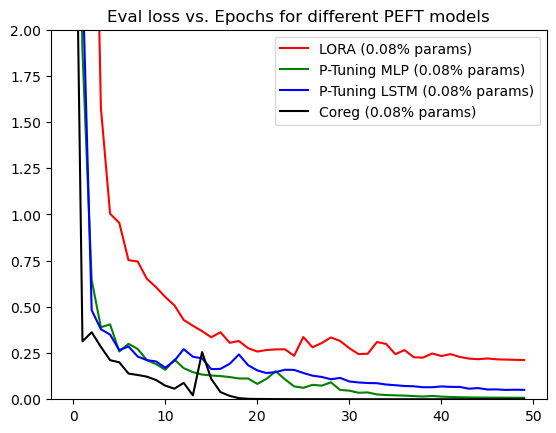

In [38]:
plt.figure()
plt.plot(lora_history, c='r', label='LORA (0.08% params)')
plt.plot(ptuning_mlp_history, c='g', label='P-Tuning MLP (0.08% params)')
plt.plot(ptuning_lstm_history, c='b', label='P-Tuning LSTM (0.08% params)')
# plt.plot([], c='y', label='Prompt Tuning (0.25% params) OOM')
plt.plot(coreg_history, c='k', label='Coreg (0.08% params)')
plt.title('Eval loss vs. Epochs for different PEFT models')
plt.legend()
plt.ylim(0,2)
plt.show()

# Exp 2: Increasing views with same dim

In [45]:
coreg_configs = [CoregPromptTuningConfig(task_type=TaskType.CAUSAL_LM, 
                                      num_views=view, 
                                      num_virtual_tokens=85,
                                      token_dim=1024,
                                      attention_dim=256) for view in [4,8,16,32,64]]


eval_results= []
for config in coreg_configs:
    eval_results.append(train(config))
    

trainable params: 1,400,576 || all params: 560,615,168 || trainable%: 0.24982841705774184


100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


epoch=0: train_ppl=tensor(59.6720, device='cuda:0') train_epoch_loss=tensor(4.0889, device='cuda:0') eval_ppl=tensor(2.1705, device='cuda:0') eval_epoch_loss=tensor(0.7750, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=1: train_ppl=tensor(2.3664, device='cuda:0') train_epoch_loss=tensor(0.8614, device='cuda:0') eval_ppl=tensor(1.6512, device='cuda:0') eval_epoch_loss=tensor(0.5015, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=2: train_ppl=tensor(1.4786, device='cuda:0') train_epoch_loss=tensor(0.3911, device='cuda:0') eval_ppl=tensor(1.3185, device='cuda:0') eval_epoch_loss=tensor(0.2765, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=3: train_ppl=tensor(1.3133, device='cuda:0') train_epoch_loss=tensor(0.2725, device='cuda:0') eval_ppl=tensor(1.2703, device='cuda:0') eval_epoch_loss=tensor(0.2392, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.67it/s]


epoch=4: train_ppl=tensor(1.2500, device='cuda:0') train_epoch_loss=tensor(0.2232, device='cuda:0') eval_ppl=tensor(1.2190, device='cuda:0') eval_epoch_loss=tensor(0.1980, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=5: train_ppl=tensor(1.2384, device='cuda:0') train_epoch_loss=tensor(0.2139, device='cuda:0') eval_ppl=tensor(1.4029, device='cuda:0') eval_epoch_loss=tensor(0.3385, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=6: train_ppl=tensor(1.2779, device='cuda:0') train_epoch_loss=tensor(0.2452, device='cuda:0') eval_ppl=tensor(1.1984, device='cuda:0') eval_epoch_loss=tensor(0.1810, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=7: train_ppl=tensor(1.1802, device='cuda:0') train_epoch_loss=tensor(0.1657, device='cuda:0') eval_ppl=tensor(1.1901, device='cuda:0') eval_epoch_loss=tensor(0.1740, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=8: train_ppl=tensor(1.1839, device='cuda:0') train_epoch_loss=tensor(0.1689, device='cuda:0') eval_ppl=tensor(1.1620, device='cuda:0') eval_epoch_loss=tensor(0.1501, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.59it/s]


epoch=9: train_ppl=tensor(1.1961, device='cuda:0') train_epoch_loss=tensor(0.1791, device='cuda:0') eval_ppl=tensor(1.1488, device='cuda:0') eval_epoch_loss=tensor(0.1388, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=10: train_ppl=tensor(1.1576, device='cuda:0') train_epoch_loss=tensor(0.1464, device='cuda:0') eval_ppl=tensor(1.1618, device='cuda:0') eval_epoch_loss=tensor(0.1500, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=11: train_ppl=tensor(1.1613, device='cuda:0') train_epoch_loss=tensor(0.1495, device='cuda:0') eval_ppl=tensor(1.1273, device='cuda:0') eval_epoch_loss=tensor(0.1198, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.61it/s]


epoch=12: train_ppl=tensor(1.1596, device='cuda:0') train_epoch_loss=tensor(0.1480, device='cuda:0') eval_ppl=tensor(1.1134, device='cuda:0') eval_epoch_loss=tensor(0.1074, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=13: train_ppl=tensor(1.1519, device='cuda:0') train_epoch_loss=tensor(0.1414, device='cuda:0') eval_ppl=tensor(1.1449, device='cuda:0') eval_epoch_loss=tensor(0.1353, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=14: train_ppl=tensor(1.1501, device='cuda:0') train_epoch_loss=tensor(0.1398, device='cuda:0') eval_ppl=tensor(1.5184, device='cuda:0') eval_epoch_loss=tensor(0.4176, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=15: train_ppl=tensor(1.4184, device='cuda:0') train_epoch_loss=tensor(0.3495, device='cuda:0') eval_ppl=tensor(1.1610, device='cuda:0') eval_epoch_loss=tensor(0.1493, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.61it/s]


epoch=16: train_ppl=tensor(1.2245, device='cuda:0') train_epoch_loss=tensor(0.2025, device='cuda:0') eval_ppl=tensor(1.2576, device='cuda:0') eval_epoch_loss=tensor(0.2292, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=17: train_ppl=tensor(1.2168, device='cuda:0') train_epoch_loss=tensor(0.1962, device='cuda:0') eval_ppl=tensor(1.1204, device='cuda:0') eval_epoch_loss=tensor(0.1137, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=18: train_ppl=tensor(1.1438, device='cuda:0') train_epoch_loss=tensor(0.1344, device='cuda:0') eval_ppl=tensor(1.1060, device='cuda:0') eval_epoch_loss=tensor(0.1008, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=19: train_ppl=tensor(1.1097, device='cuda:0') train_epoch_loss=tensor(0.1041, device='cuda:0') eval_ppl=tensor(1.0825, device='cuda:0') eval_epoch_loss=tensor(0.0793, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


epoch=20: train_ppl=tensor(1.0869, device='cuda:0') train_epoch_loss=tensor(0.0833, device='cuda:0') eval_ppl=tensor(1.0784, device='cuda:0') eval_epoch_loss=tensor(0.0755, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=21: train_ppl=tensor(1.0587, device='cuda:0') train_epoch_loss=tensor(0.0570, device='cuda:0') eval_ppl=tensor(1.0841, device='cuda:0') eval_epoch_loss=tensor(0.0807, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.61it/s]


epoch=22: train_ppl=tensor(1.0618, device='cuda:0') train_epoch_loss=tensor(0.0599, device='cuda:0') eval_ppl=tensor(1.0803, device='cuda:0') eval_epoch_loss=tensor(0.0772, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=23: train_ppl=tensor(1.0508, device='cuda:0') train_epoch_loss=tensor(0.0496, device='cuda:0') eval_ppl=tensor(1.0414, device='cuda:0') eval_epoch_loss=tensor(0.0405, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=24: train_ppl=tensor(1.0479, device='cuda:0') train_epoch_loss=tensor(0.0468, device='cuda:0') eval_ppl=tensor(1.1236, device='cuda:0') eval_epoch_loss=tensor(0.1166, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=25: train_ppl=tensor(1.1146, device='cuda:0') train_epoch_loss=tensor(0.1085, device='cuda:0') eval_ppl=tensor(1.1456, device='cuda:0') eval_epoch_loss=tensor(0.1359, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=26: train_ppl=tensor(1.1228, device='cuda:0') train_epoch_loss=tensor(0.1159, device='cuda:0') eval_ppl=tensor(1.0808, device='cuda:0') eval_epoch_loss=tensor(0.0777, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.68it/s]


epoch=27: train_ppl=tensor(1.0725, device='cuda:0') train_epoch_loss=tensor(0.0700, device='cuda:0') eval_ppl=tensor(1.0670, device='cuda:0') eval_epoch_loss=tensor(0.0649, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=28: train_ppl=tensor(1.0825, device='cuda:0') train_epoch_loss=tensor(0.0793, device='cuda:0') eval_ppl=tensor(1.0353, device='cuda:0') eval_epoch_loss=tensor(0.0347, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


epoch=29: train_ppl=tensor(1.0335, device='cuda:0') train_epoch_loss=tensor(0.0330, device='cuda:0') eval_ppl=tensor(1.0321, device='cuda:0') eval_epoch_loss=tensor(0.0316, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=30: train_ppl=tensor(1.0200, device='cuda:0') train_epoch_loss=tensor(0.0198, device='cuda:0') eval_ppl=tensor(1.0241, device='cuda:0') eval_epoch_loss=tensor(0.0238, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=31: train_ppl=tensor(1.0153, device='cuda:0') train_epoch_loss=tensor(0.0152, device='cuda:0') eval_ppl=tensor(1.0162, device='cuda:0') eval_epoch_loss=tensor(0.0161, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.69it/s]


epoch=32: train_ppl=tensor(1.0190, device='cuda:0') train_epoch_loss=tensor(0.0188, device='cuda:0') eval_ppl=tensor(1.0146, device='cuda:0') eval_epoch_loss=tensor(0.0145, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.68it/s]


epoch=33: train_ppl=tensor(1.0215, device='cuda:0') train_epoch_loss=tensor(0.0213, device='cuda:0') eval_ppl=tensor(1.0123, device='cuda:0') eval_epoch_loss=tensor(0.0122, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


epoch=34: train_ppl=tensor(1.0232, device='cuda:0') train_epoch_loss=tensor(0.0230, device='cuda:0') eval_ppl=tensor(1.0075, device='cuda:0') eval_epoch_loss=tensor(0.0075, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.69it/s]


epoch=35: train_ppl=tensor(1.0125, device='cuda:0') train_epoch_loss=tensor(0.0124, device='cuda:0') eval_ppl=tensor(1.0102, device='cuda:0') eval_epoch_loss=tensor(0.0101, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.68it/s]


epoch=36: train_ppl=tensor(1.0081, device='cuda:0') train_epoch_loss=tensor(0.0081, device='cuda:0') eval_ppl=tensor(1.0048, device='cuda:0') eval_epoch_loss=tensor(0.0048, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.67it/s]


epoch=37: train_ppl=tensor(1.0047, device='cuda:0') train_epoch_loss=tensor(0.0047, device='cuda:0') eval_ppl=tensor(1.0045, device='cuda:0') eval_epoch_loss=tensor(0.0045, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.68it/s]


epoch=38: train_ppl=tensor(1.0040, device='cuda:0') train_epoch_loss=tensor(0.0040, device='cuda:0') eval_ppl=tensor(1.0030, device='cuda:0') eval_epoch_loss=tensor(0.0030, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.68it/s]


epoch=39: train_ppl=tensor(1.0029, device='cuda:0') train_epoch_loss=tensor(0.0029, device='cuda:0') eval_ppl=tensor(1.0027, device='cuda:0') eval_epoch_loss=tensor(0.0027, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.67it/s]


epoch=40: train_ppl=tensor(1.0027, device='cuda:0') train_epoch_loss=tensor(0.0027, device='cuda:0') eval_ppl=tensor(1.0025, device='cuda:0') eval_epoch_loss=tensor(0.0024, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.67it/s]


epoch=41: train_ppl=tensor(1.0024, device='cuda:0') train_epoch_loss=tensor(0.0024, device='cuda:0') eval_ppl=tensor(1.0022, device='cuda:0') eval_epoch_loss=tensor(0.0022, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


epoch=42: train_ppl=tensor(1.0026, device='cuda:0') train_epoch_loss=tensor(0.0026, device='cuda:0') eval_ppl=tensor(1.0021, device='cuda:0') eval_epoch_loss=tensor(0.0021, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=43: train_ppl=tensor(1.0021, device='cuda:0') train_epoch_loss=tensor(0.0021, device='cuda:0') eval_ppl=tensor(1.0020, device='cuda:0') eval_epoch_loss=tensor(0.0020, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.67it/s]


epoch=44: train_ppl=tensor(1.0024, device='cuda:0') train_epoch_loss=tensor(0.0024, device='cuda:0') eval_ppl=tensor(1.0019, device='cuda:0') eval_epoch_loss=tensor(0.0019, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=45: train_ppl=tensor(1.0020, device='cuda:0') train_epoch_loss=tensor(0.0020, device='cuda:0') eval_ppl=tensor(1.0018, device='cuda:0') eval_epoch_loss=tensor(0.0018, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.68it/s]


epoch=46: train_ppl=tensor(1.0017, device='cuda:0') train_epoch_loss=tensor(0.0017, device='cuda:0') eval_ppl=tensor(1.0018, device='cuda:0') eval_epoch_loss=tensor(0.0018, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=47: train_ppl=tensor(1.0017, device='cuda:0') train_epoch_loss=tensor(0.0017, device='cuda:0') eval_ppl=tensor(1.0018, device='cuda:0') eval_epoch_loss=tensor(0.0017, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


epoch=48: train_ppl=tensor(1.0018, device='cuda:0') train_epoch_loss=tensor(0.0018, device='cuda:0') eval_ppl=tensor(1.0017, device='cuda:0') eval_epoch_loss=tensor(0.0017, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=49: train_ppl=tensor(1.0018, device='cuda:0') train_epoch_loss=tensor(0.0018, device='cuda:0') eval_ppl=tensor(1.0017, device='cuda:0') eval_epoch_loss=tensor(0.0017, device='cuda:0')
trainable params: 1,400,576 || all params: 560,615,168 || trainable%: 0.24982841705774184


100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


epoch=0: train_ppl=tensor(46.6137, device='cuda:0') train_epoch_loss=tensor(3.8419, device='cuda:0') eval_ppl=tensor(1.4727, device='cuda:0') eval_epoch_loss=tensor(0.3871, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


epoch=1: train_ppl=tensor(1.3932, device='cuda:0') train_epoch_loss=tensor(0.3316, device='cuda:0') eval_ppl=tensor(1.2436, device='cuda:0') eval_epoch_loss=tensor(0.2180, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


epoch=2: train_ppl=tensor(1.3042, device='cuda:0') train_epoch_loss=tensor(0.2656, device='cuda:0') eval_ppl=tensor(1.2496, device='cuda:0') eval_epoch_loss=tensor(0.2228, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=3: train_ppl=tensor(1.2914, device='cuda:0') train_epoch_loss=tensor(0.2557, device='cuda:0') eval_ppl=tensor(1.2439, device='cuda:0') eval_epoch_loss=tensor(0.2182, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=4: train_ppl=tensor(1.1837, device='cuda:0') train_epoch_loss=tensor(0.1686, device='cuda:0') eval_ppl=tensor(1.2125, device='cuda:0') eval_epoch_loss=tensor(0.1926, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.67it/s]


epoch=5: train_ppl=tensor(1.1871, device='cuda:0') train_epoch_loss=tensor(0.1715, device='cuda:0') eval_ppl=tensor(1.2179, device='cuda:0') eval_epoch_loss=tensor(0.1971, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=6: train_ppl=tensor(1.1893, device='cuda:0') train_epoch_loss=tensor(0.1733, device='cuda:0') eval_ppl=tensor(1.2974, device='cuda:0') eval_epoch_loss=tensor(0.2603, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.68it/s]


epoch=7: train_ppl=tensor(1.3362, device='cuda:0') train_epoch_loss=tensor(0.2898, device='cuda:0') eval_ppl=tensor(1.3057, device='cuda:0') eval_epoch_loss=tensor(0.2668, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=8: train_ppl=tensor(1.2620, device='cuda:0') train_epoch_loss=tensor(0.2327, device='cuda:0') eval_ppl=tensor(1.4650, device='cuda:0') eval_epoch_loss=tensor(0.3818, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


epoch=9: train_ppl=tensor(1.3450, device='cuda:0') train_epoch_loss=tensor(0.2964, device='cuda:0') eval_ppl=tensor(1.1784, device='cuda:0') eval_epoch_loss=tensor(0.1641, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=10: train_ppl=tensor(1.1455, device='cuda:0') train_epoch_loss=tensor(0.1359, device='cuda:0') eval_ppl=tensor(1.1361, device='cuda:0') eval_epoch_loss=tensor(0.1276, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=11: train_ppl=tensor(1.1308, device='cuda:0') train_epoch_loss=tensor(0.1229, device='cuda:0') eval_ppl=tensor(1.0989, device='cuda:0') eval_epoch_loss=tensor(0.0943, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=12: train_ppl=tensor(1.0975, device='cuda:0') train_epoch_loss=tensor(0.0931, device='cuda:0') eval_ppl=tensor(1.0924, device='cuda:0') eval_epoch_loss=tensor(0.0884, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=13: train_ppl=tensor(1.1036, device='cuda:0') train_epoch_loss=tensor(0.0986, device='cuda:0') eval_ppl=tensor(1.1023, device='cuda:0') eval_epoch_loss=tensor(0.0974, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=14: train_ppl=tensor(1.1377, device='cuda:0') train_epoch_loss=tensor(0.1290, device='cuda:0') eval_ppl=tensor(1.1690, device='cuda:0') eval_epoch_loss=tensor(0.1561, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.61it/s]


epoch=15: train_ppl=tensor(1.1107, device='cuda:0') train_epoch_loss=tensor(0.1050, device='cuda:0') eval_ppl=tensor(1.0818, device='cuda:0') eval_epoch_loss=tensor(0.0786, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=16: train_ppl=tensor(1.0697, device='cuda:0') train_epoch_loss=tensor(0.0674, device='cuda:0') eval_ppl=tensor(1.0688, device='cuda:0') eval_epoch_loss=tensor(0.0666, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=17: train_ppl=tensor(1.0780, device='cuda:0') train_epoch_loss=tensor(0.0751, device='cuda:0') eval_ppl=tensor(1.0558, device='cuda:0') eval_epoch_loss=tensor(0.0543, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=18: train_ppl=tensor(1.0645, device='cuda:0') train_epoch_loss=tensor(0.0625, device='cuda:0') eval_ppl=tensor(1.0499, device='cuda:0') eval_epoch_loss=tensor(0.0487, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=19: train_ppl=tensor(1.0757, device='cuda:0') train_epoch_loss=tensor(0.0730, device='cuda:0') eval_ppl=tensor(1.0417, device='cuda:0') eval_epoch_loss=tensor(0.0408, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=20: train_ppl=tensor(1.0299, device='cuda:0') train_epoch_loss=tensor(0.0295, device='cuda:0') eval_ppl=tensor(1.0462, device='cuda:0') eval_epoch_loss=tensor(0.0452, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


epoch=21: train_ppl=tensor(1.0321, device='cuda:0') train_epoch_loss=tensor(0.0316, device='cuda:0') eval_ppl=tensor(1.0241, device='cuda:0') eval_epoch_loss=tensor(0.0238, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=22: train_ppl=tensor(1.0239, device='cuda:0') train_epoch_loss=tensor(0.0236, device='cuda:0') eval_ppl=tensor(1.0351, device='cuda:0') eval_epoch_loss=tensor(0.0345, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=23: train_ppl=tensor(1.0253, device='cuda:0') train_epoch_loss=tensor(0.0250, device='cuda:0') eval_ppl=tensor(1.0176, device='cuda:0') eval_epoch_loss=tensor(0.0175, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=24: train_ppl=tensor(1.0166, device='cuda:0') train_epoch_loss=tensor(0.0165, device='cuda:0') eval_ppl=tensor(1.0189, device='cuda:0') eval_epoch_loss=tensor(0.0188, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=25: train_ppl=tensor(1.0176, device='cuda:0') train_epoch_loss=tensor(0.0174, device='cuda:0') eval_ppl=tensor(1.0101, device='cuda:0') eval_epoch_loss=tensor(0.0101, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=26: train_ppl=tensor(1.0137, device='cuda:0') train_epoch_loss=tensor(0.0137, device='cuda:0') eval_ppl=tensor(1.0084, device='cuda:0') eval_epoch_loss=tensor(0.0083, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=27: train_ppl=tensor(1.0099, device='cuda:0') train_epoch_loss=tensor(0.0098, device='cuda:0') eval_ppl=tensor(1.0072, device='cuda:0') eval_epoch_loss=tensor(0.0072, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=28: train_ppl=tensor(1.0071, device='cuda:0') train_epoch_loss=tensor(0.0070, device='cuda:0') eval_ppl=tensor(1.0064, device='cuda:0') eval_epoch_loss=tensor(0.0064, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=29: train_ppl=tensor(1.0071, device='cuda:0') train_epoch_loss=tensor(0.0071, device='cuda:0') eval_ppl=tensor(1.0057, device='cuda:0') eval_epoch_loss=tensor(0.0057, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=30: train_ppl=tensor(1.0052, device='cuda:0') train_epoch_loss=tensor(0.0052, device='cuda:0') eval_ppl=tensor(1.0061, device='cuda:0') eval_epoch_loss=tensor(0.0061, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=31: train_ppl=tensor(1.0055, device='cuda:0') train_epoch_loss=tensor(0.0055, device='cuda:0') eval_ppl=tensor(1.0042, device='cuda:0') eval_epoch_loss=tensor(0.0041, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.68it/s]


epoch=32: train_ppl=tensor(1.0040, device='cuda:0') train_epoch_loss=tensor(0.0040, device='cuda:0') eval_ppl=tensor(1.0038, device='cuda:0') eval_epoch_loss=tensor(0.0038, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=33: train_ppl=tensor(1.0033, device='cuda:0') train_epoch_loss=tensor(0.0033, device='cuda:0') eval_ppl=tensor(1.0037, device='cuda:0') eval_epoch_loss=tensor(0.0037, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.67it/s]


epoch=34: train_ppl=tensor(1.0030, device='cuda:0') train_epoch_loss=tensor(0.0030, device='cuda:0') eval_ppl=tensor(1.0032, device='cuda:0') eval_epoch_loss=tensor(0.0032, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=35: train_ppl=tensor(1.0027, device='cuda:0') train_epoch_loss=tensor(0.0027, device='cuda:0') eval_ppl=tensor(1.0030, device='cuda:0') eval_epoch_loss=tensor(0.0030, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


epoch=36: train_ppl=tensor(1.0026, device='cuda:0') train_epoch_loss=tensor(0.0026, device='cuda:0') eval_ppl=tensor(1.0028, device='cuda:0') eval_epoch_loss=tensor(0.0028, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=37: train_ppl=tensor(1.0025, device='cuda:0') train_epoch_loss=tensor(0.0025, device='cuda:0') eval_ppl=tensor(1.0027, device='cuda:0') eval_epoch_loss=tensor(0.0027, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=38: train_ppl=tensor(1.0023, device='cuda:0') train_epoch_loss=tensor(0.0023, device='cuda:0') eval_ppl=tensor(1.0026, device='cuda:0') eval_epoch_loss=tensor(0.0026, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


epoch=39: train_ppl=tensor(1.0023, device='cuda:0') train_epoch_loss=tensor(0.0023, device='cuda:0') eval_ppl=tensor(1.0024, device='cuda:0') eval_epoch_loss=tensor(0.0024, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=40: train_ppl=tensor(1.0021, device='cuda:0') train_epoch_loss=tensor(0.0021, device='cuda:0') eval_ppl=tensor(1.0024, device='cuda:0') eval_epoch_loss=tensor(0.0024, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=41: train_ppl=tensor(1.0023, device='cuda:0') train_epoch_loss=tensor(0.0023, device='cuda:0') eval_ppl=tensor(1.0023, device='cuda:0') eval_epoch_loss=tensor(0.0023, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=42: train_ppl=tensor(1.0021, device='cuda:0') train_epoch_loss=tensor(0.0021, device='cuda:0') eval_ppl=tensor(1.0022, device='cuda:0') eval_epoch_loss=tensor(0.0022, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=43: train_ppl=tensor(1.0019, device='cuda:0') train_epoch_loss=tensor(0.0019, device='cuda:0') eval_ppl=tensor(1.0021, device='cuda:0') eval_epoch_loss=tensor(0.0021, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=44: train_ppl=tensor(1.0019, device='cuda:0') train_epoch_loss=tensor(0.0019, device='cuda:0') eval_ppl=tensor(1.0021, device='cuda:0') eval_epoch_loss=tensor(0.0021, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=45: train_ppl=tensor(1.0018, device='cuda:0') train_epoch_loss=tensor(0.0018, device='cuda:0') eval_ppl=tensor(1.0020, device='cuda:0') eval_epoch_loss=tensor(0.0020, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=46: train_ppl=tensor(1.0020, device='cuda:0') train_epoch_loss=tensor(0.0020, device='cuda:0') eval_ppl=tensor(1.0020, device='cuda:0') eval_epoch_loss=tensor(0.0020, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=47: train_ppl=tensor(1.0019, device='cuda:0') train_epoch_loss=tensor(0.0019, device='cuda:0') eval_ppl=tensor(1.0020, device='cuda:0') eval_epoch_loss=tensor(0.0020, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


epoch=48: train_ppl=tensor(1.0018, device='cuda:0') train_epoch_loss=tensor(0.0018, device='cuda:0') eval_ppl=tensor(1.0020, device='cuda:0') eval_epoch_loss=tensor(0.0020, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=49: train_ppl=tensor(1.0020, device='cuda:0') train_epoch_loss=tensor(0.0020, device='cuda:0') eval_ppl=tensor(1.0020, device='cuda:0') eval_epoch_loss=tensor(0.0020, device='cuda:0')
trainable params: 1,400,576 || all params: 560,615,168 || trainable%: 0.24982841705774184


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=0: train_ppl=tensor(360.1638, device='cuda:0') train_epoch_loss=tensor(5.8866, device='cuda:0') eval_ppl=tensor(276.3917, device='cuda:0') eval_epoch_loss=tensor(5.6218, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.67it/s]


epoch=1: train_ppl=tensor(25.3598, device='cuda:0') train_epoch_loss=tensor(3.2332, device='cuda:0') eval_ppl=tensor(3.7117, device='cuda:0') eval_epoch_loss=tensor(1.3115, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=2: train_ppl=tensor(2.4734, device='cuda:0') train_epoch_loss=tensor(0.9056, device='cuda:0') eval_ppl=tensor(1.5631, device='cuda:0') eval_epoch_loss=tensor(0.4467, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


epoch=3: train_ppl=tensor(1.4135, device='cuda:0') train_epoch_loss=tensor(0.3461, device='cuda:0') eval_ppl=tensor(1.3496, device='cuda:0') eval_epoch_loss=tensor(0.2998, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


epoch=4: train_ppl=tensor(1.3130, device='cuda:0') train_epoch_loss=tensor(0.2723, device='cuda:0') eval_ppl=tensor(1.2701, device='cuda:0') eval_epoch_loss=tensor(0.2391, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=5: train_ppl=tensor(1.2301, device='cuda:0') train_epoch_loss=tensor(0.2071, device='cuda:0') eval_ppl=tensor(1.2309, device='cuda:0') eval_epoch_loss=tensor(0.2078, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


epoch=6: train_ppl=tensor(1.2352, device='cuda:0') train_epoch_loss=tensor(0.2112, device='cuda:0') eval_ppl=tensor(1.2231, device='cuda:0') eval_epoch_loss=tensor(0.2014, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=7: train_ppl=tensor(1.2275, device='cuda:0') train_epoch_loss=tensor(0.2050, device='cuda:0') eval_ppl=tensor(1.2278, device='cuda:0') eval_epoch_loss=tensor(0.2053, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=8: train_ppl=tensor(1.2285, device='cuda:0') train_epoch_loss=tensor(0.2058, device='cuda:0') eval_ppl=tensor(1.4014, device='cuda:0') eval_epoch_loss=tensor(0.3374, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


epoch=9: train_ppl=tensor(1.4251, device='cuda:0') train_epoch_loss=tensor(0.3543, device='cuda:0') eval_ppl=tensor(1.2417, device='cuda:0') eval_epoch_loss=tensor(0.2165, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=10: train_ppl=tensor(1.3574, device='cuda:0') train_epoch_loss=tensor(0.3055, device='cuda:0') eval_ppl=tensor(1.3026, device='cuda:0') eval_epoch_loss=tensor(0.2644, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=11: train_ppl=tensor(1.2620, device='cuda:0') train_epoch_loss=tensor(0.2327, device='cuda:0') eval_ppl=tensor(1.2574, device='cuda:0') eval_epoch_loss=tensor(0.2290, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=12: train_ppl=tensor(1.2448, device='cuda:0') train_epoch_loss=tensor(0.2190, device='cuda:0') eval_ppl=tensor(1.2271, device='cuda:0') eval_epoch_loss=tensor(0.2047, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=13: train_ppl=tensor(1.2020, device='cuda:0') train_epoch_loss=tensor(0.1840, device='cuda:0') eval_ppl=tensor(1.2236, device='cuda:0') eval_epoch_loss=tensor(0.2018, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=14: train_ppl=tensor(1.2264, device='cuda:0') train_epoch_loss=tensor(0.2041, device='cuda:0') eval_ppl=tensor(1.2034, device='cuda:0') eval_epoch_loss=tensor(0.1851, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=15: train_ppl=tensor(1.2075, device='cuda:0') train_epoch_loss=tensor(0.1886, device='cuda:0') eval_ppl=tensor(1.2075, device='cuda:0') eval_epoch_loss=tensor(0.1886, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=16: train_ppl=tensor(1.2741, device='cuda:0') train_epoch_loss=tensor(0.2423, device='cuda:0') eval_ppl=tensor(1.1815, device='cuda:0') eval_epoch_loss=tensor(0.1668, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=17: train_ppl=tensor(1.1995, device='cuda:0') train_epoch_loss=tensor(0.1819, device='cuda:0') eval_ppl=tensor(1.2353, device='cuda:0') eval_epoch_loss=tensor(0.2113, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=18: train_ppl=tensor(1.2248, device='cuda:0') train_epoch_loss=tensor(0.2027, device='cuda:0') eval_ppl=tensor(1.2103, device='cuda:0') eval_epoch_loss=tensor(0.1908, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=19: train_ppl=tensor(1.1926, device='cuda:0') train_epoch_loss=tensor(0.1761, device='cuda:0') eval_ppl=tensor(1.2118, device='cuda:0') eval_epoch_loss=tensor(0.1921, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=20: train_ppl=tensor(1.1807, device='cuda:0') train_epoch_loss=tensor(0.1661, device='cuda:0') eval_ppl=tensor(1.2054, device='cuda:0') eval_epoch_loss=tensor(0.1868, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=21: train_ppl=tensor(1.1944, device='cuda:0') train_epoch_loss=tensor(0.1777, device='cuda:0') eval_ppl=tensor(1.2029, device='cuda:0') eval_epoch_loss=tensor(0.1847, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=22: train_ppl=tensor(1.1627, device='cuda:0') train_epoch_loss=tensor(0.1507, device='cuda:0') eval_ppl=tensor(1.1581, device='cuda:0') eval_epoch_loss=tensor(0.1468, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=23: train_ppl=tensor(1.1503, device='cuda:0') train_epoch_loss=tensor(0.1400, device='cuda:0') eval_ppl=tensor(1.3159, device='cuda:0') eval_epoch_loss=tensor(0.2745, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


epoch=24: train_ppl=tensor(1.2093, device='cuda:0') train_epoch_loss=tensor(0.1901, device='cuda:0') eval_ppl=tensor(1.1700, device='cuda:0') eval_epoch_loss=tensor(0.1570, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=25: train_ppl=tensor(1.1542, device='cuda:0') train_epoch_loss=tensor(0.1434, device='cuda:0') eval_ppl=tensor(1.1511, device='cuda:0') eval_epoch_loss=tensor(0.1407, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.67it/s]


epoch=26: train_ppl=tensor(1.1428, device='cuda:0') train_epoch_loss=tensor(0.1335, device='cuda:0') eval_ppl=tensor(1.1211, device='cuda:0') eval_epoch_loss=tensor(0.1143, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=27: train_ppl=tensor(1.1549, device='cuda:0') train_epoch_loss=tensor(0.1441, device='cuda:0') eval_ppl=tensor(1.1228, device='cuda:0') eval_epoch_loss=tensor(0.1158, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=28: train_ppl=tensor(1.1734, device='cuda:0') train_epoch_loss=tensor(0.1599, device='cuda:0') eval_ppl=tensor(1.1005, device='cuda:0') eval_epoch_loss=tensor(0.0958, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


epoch=29: train_ppl=tensor(1.1226, device='cuda:0') train_epoch_loss=tensor(0.1156, device='cuda:0') eval_ppl=tensor(1.1105, device='cuda:0') eval_epoch_loss=tensor(0.1048, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=30: train_ppl=tensor(1.1085, device='cuda:0') train_epoch_loss=tensor(0.1030, device='cuda:0') eval_ppl=tensor(1.0814, device='cuda:0') eval_epoch_loss=tensor(0.0783, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=31: train_ppl=tensor(1.0863, device='cuda:0') train_epoch_loss=tensor(0.0828, device='cuda:0') eval_ppl=tensor(1.0725, device='cuda:0') eval_epoch_loss=tensor(0.0700, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.67it/s]


epoch=32: train_ppl=tensor(1.1182, device='cuda:0') train_epoch_loss=tensor(0.1117, device='cuda:0') eval_ppl=tensor(1.0643, device='cuda:0') eval_epoch_loss=tensor(0.0623, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


epoch=33: train_ppl=tensor(1.0893, device='cuda:0') train_epoch_loss=tensor(0.0856, device='cuda:0') eval_ppl=tensor(1.0685, device='cuda:0') eval_epoch_loss=tensor(0.0662, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=34: train_ppl=tensor(1.0673, device='cuda:0') train_epoch_loss=tensor(0.0651, device='cuda:0') eval_ppl=tensor(1.0635, device='cuda:0') eval_epoch_loss=tensor(0.0615, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=35: train_ppl=tensor(1.0591, device='cuda:0') train_epoch_loss=tensor(0.0574, device='cuda:0') eval_ppl=tensor(1.0496, device='cuda:0') eval_epoch_loss=tensor(0.0484, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


epoch=36: train_ppl=tensor(1.0500, device='cuda:0') train_epoch_loss=tensor(0.0488, device='cuda:0') eval_ppl=tensor(1.0448, device='cuda:0') eval_epoch_loss=tensor(0.0438, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=37: train_ppl=tensor(1.0402, device='cuda:0') train_epoch_loss=tensor(0.0394, device='cuda:0') eval_ppl=tensor(1.0398, device='cuda:0') eval_epoch_loss=tensor(0.0391, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=38: train_ppl=tensor(1.0451, device='cuda:0') train_epoch_loss=tensor(0.0441, device='cuda:0') eval_ppl=tensor(1.0391, device='cuda:0') eval_epoch_loss=tensor(0.0384, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=39: train_ppl=tensor(1.0428, device='cuda:0') train_epoch_loss=tensor(0.0419, device='cuda:0') eval_ppl=tensor(1.0323, device='cuda:0') eval_epoch_loss=tensor(0.0318, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


epoch=40: train_ppl=tensor(1.0465, device='cuda:0') train_epoch_loss=tensor(0.0455, device='cuda:0') eval_ppl=tensor(1.0332, device='cuda:0') eval_epoch_loss=tensor(0.0327, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=41: train_ppl=tensor(1.0399, device='cuda:0') train_epoch_loss=tensor(0.0391, device='cuda:0') eval_ppl=tensor(1.0284, device='cuda:0') eval_epoch_loss=tensor(0.0281, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=42: train_ppl=tensor(1.0386, device='cuda:0') train_epoch_loss=tensor(0.0378, device='cuda:0') eval_ppl=tensor(1.0274, device='cuda:0') eval_epoch_loss=tensor(0.0271, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=43: train_ppl=tensor(1.0313, device='cuda:0') train_epoch_loss=tensor(0.0308, device='cuda:0') eval_ppl=tensor(1.0320, device='cuda:0') eval_epoch_loss=tensor(0.0315, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=44: train_ppl=tensor(1.0270, device='cuda:0') train_epoch_loss=tensor(0.0267, device='cuda:0') eval_ppl=tensor(1.0222, device='cuda:0') eval_epoch_loss=tensor(0.0220, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=45: train_ppl=tensor(1.0260, device='cuda:0') train_epoch_loss=tensor(0.0257, device='cuda:0') eval_ppl=tensor(1.0227, device='cuda:0') eval_epoch_loss=tensor(0.0224, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=46: train_ppl=tensor(1.0188, device='cuda:0') train_epoch_loss=tensor(0.0186, device='cuda:0') eval_ppl=tensor(1.0218, device='cuda:0') eval_epoch_loss=tensor(0.0216, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=47: train_ppl=tensor(1.0200, device='cuda:0') train_epoch_loss=tensor(0.0198, device='cuda:0') eval_ppl=tensor(1.0214, device='cuda:0') eval_epoch_loss=tensor(0.0212, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


epoch=48: train_ppl=tensor(1.0171, device='cuda:0') train_epoch_loss=tensor(0.0170, device='cuda:0') eval_ppl=tensor(1.0187, device='cuda:0') eval_epoch_loss=tensor(0.0185, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=49: train_ppl=tensor(1.0194, device='cuda:0') train_epoch_loss=tensor(0.0192, device='cuda:0') eval_ppl=tensor(1.0181, device='cuda:0') eval_epoch_loss=tensor(0.0179, device='cuda:0')
trainable params: 1,400,576 || all params: 560,615,168 || trainable%: 0.24982841705774184


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=0: train_ppl=tensor(163.7475, device='cuda:0') train_epoch_loss=tensor(5.0983, device='cuda:0') eval_ppl=tensor(5.2318, device='cuda:0') eval_epoch_loss=tensor(1.6548, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=1: train_ppl=tensor(2.7842, device='cuda:0') train_epoch_loss=tensor(1.0240, device='cuda:0') eval_ppl=tensor(1.4262, device='cuda:0') eval_epoch_loss=tensor(0.3550, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.61it/s]


epoch=2: train_ppl=tensor(1.3713, device='cuda:0') train_epoch_loss=tensor(0.3157, device='cuda:0') eval_ppl=tensor(1.3417, device='cuda:0') eval_epoch_loss=tensor(0.2939, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=3: train_ppl=tensor(1.2935, device='cuda:0') train_epoch_loss=tensor(0.2573, device='cuda:0') eval_ppl=tensor(1.6302, device='cuda:0') eval_epoch_loss=tensor(0.4887, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=4: train_ppl=tensor(1.3729, device='cuda:0') train_epoch_loss=tensor(0.3169, device='cuda:0') eval_ppl=tensor(1.2647, device='cuda:0') eval_epoch_loss=tensor(0.2348, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=5: train_ppl=tensor(1.2317, device='cuda:0') train_epoch_loss=tensor(0.2084, device='cuda:0') eval_ppl=tensor(1.1998, device='cuda:0') eval_epoch_loss=tensor(0.1821, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.61it/s]


epoch=6: train_ppl=tensor(1.1564, device='cuda:0') train_epoch_loss=tensor(0.1453, device='cuda:0') eval_ppl=tensor(1.3266, device='cuda:0') eval_epoch_loss=tensor(0.2826, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=7: train_ppl=tensor(1.3002, device='cuda:0') train_epoch_loss=tensor(0.2626, device='cuda:0') eval_ppl=tensor(1.4804, device='cuda:0') eval_epoch_loss=tensor(0.3923, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=8: train_ppl=tensor(1.3158, device='cuda:0') train_epoch_loss=tensor(0.2744, device='cuda:0') eval_ppl=tensor(1.1988, device='cuda:0') eval_epoch_loss=tensor(0.1814, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


epoch=9: train_ppl=tensor(1.2334, device='cuda:0') train_epoch_loss=tensor(0.2098, device='cuda:0') eval_ppl=tensor(1.2588, device='cuda:0') eval_epoch_loss=tensor(0.2301, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=10: train_ppl=tensor(1.2872, device='cuda:0') train_epoch_loss=tensor(0.2524, device='cuda:0') eval_ppl=tensor(1.3111, device='cuda:0') eval_epoch_loss=tensor(0.2709, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=11: train_ppl=tensor(1.2921, device='cuda:0') train_epoch_loss=tensor(0.2563, device='cuda:0') eval_ppl=tensor(1.2237, device='cuda:0') eval_epoch_loss=tensor(0.2018, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=12: train_ppl=tensor(1.2239, device='cuda:0') train_epoch_loss=tensor(0.2020, device='cuda:0') eval_ppl=tensor(1.1394, device='cuda:0') eval_epoch_loss=tensor(0.1305, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


epoch=13: train_ppl=tensor(1.1657, device='cuda:0') train_epoch_loss=tensor(0.1534, device='cuda:0') eval_ppl=tensor(1.1362, device='cuda:0') eval_epoch_loss=tensor(0.1277, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=14: train_ppl=tensor(1.1105, device='cuda:0') train_epoch_loss=tensor(0.1048, device='cuda:0') eval_ppl=tensor(1.1278, device='cuda:0') eval_epoch_loss=tensor(0.1202, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=15: train_ppl=tensor(1.1107, device='cuda:0') train_epoch_loss=tensor(0.1050, device='cuda:0') eval_ppl=tensor(1.0867, device='cuda:0') eval_epoch_loss=tensor(0.0831, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=16: train_ppl=tensor(1.0863, device='cuda:0') train_epoch_loss=tensor(0.0828, device='cuda:0') eval_ppl=tensor(1.0723, device='cuda:0') eval_epoch_loss=tensor(0.0698, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=17: train_ppl=tensor(1.0531, device='cuda:0') train_epoch_loss=tensor(0.0517, device='cuda:0') eval_ppl=tensor(1.0407, device='cuda:0') eval_epoch_loss=tensor(0.0399, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=18: train_ppl=tensor(1.0423, device='cuda:0') train_epoch_loss=tensor(0.0414, device='cuda:0') eval_ppl=tensor(1.0617, device='cuda:0') eval_epoch_loss=tensor(0.0598, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=19: train_ppl=tensor(1.0495, device='cuda:0') train_epoch_loss=tensor(0.0484, device='cuda:0') eval_ppl=tensor(1.0264, device='cuda:0') eval_epoch_loss=tensor(0.0260, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=20: train_ppl=tensor(1.0436, device='cuda:0') train_epoch_loss=tensor(0.0427, device='cuda:0') eval_ppl=tensor(1.1000, device='cuda:0') eval_epoch_loss=tensor(0.0953, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=21: train_ppl=tensor(1.1173, device='cuda:0') train_epoch_loss=tensor(0.1109, device='cuda:0') eval_ppl=tensor(1.1877, device='cuda:0') eval_epoch_loss=tensor(0.1720, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=22: train_ppl=tensor(1.1529, device='cuda:0') train_epoch_loss=tensor(0.1423, device='cuda:0') eval_ppl=tensor(1.2148, device='cuda:0') eval_epoch_loss=tensor(0.1946, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


epoch=23: train_ppl=tensor(1.1641, device='cuda:0') train_epoch_loss=tensor(0.1520, device='cuda:0') eval_ppl=tensor(1.0762, device='cuda:0') eval_epoch_loss=tensor(0.0734, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=24: train_ppl=tensor(1.0734, device='cuda:0') train_epoch_loss=tensor(0.0708, device='cuda:0') eval_ppl=tensor(1.0556, device='cuda:0') eval_epoch_loss=tensor(0.0541, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=25: train_ppl=tensor(1.0455, device='cuda:0') train_epoch_loss=tensor(0.0445, device='cuda:0') eval_ppl=tensor(1.0408, device='cuda:0') eval_epoch_loss=tensor(0.0399, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=26: train_ppl=tensor(1.0275, device='cuda:0') train_epoch_loss=tensor(0.0272, device='cuda:0') eval_ppl=tensor(1.0245, device='cuda:0') eval_epoch_loss=tensor(0.0242, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=27: train_ppl=tensor(1.0258, device='cuda:0') train_epoch_loss=tensor(0.0255, device='cuda:0') eval_ppl=tensor(1.0240, device='cuda:0') eval_epoch_loss=tensor(0.0238, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=28: train_ppl=tensor(1.0155, device='cuda:0') train_epoch_loss=tensor(0.0154, device='cuda:0') eval_ppl=tensor(1.0340, device='cuda:0') eval_epoch_loss=tensor(0.0334, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=29: train_ppl=tensor(1.0143, device='cuda:0') train_epoch_loss=tensor(0.0142, device='cuda:0') eval_ppl=tensor(1.0203, device='cuda:0') eval_epoch_loss=tensor(0.0200, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=30: train_ppl=tensor(1.0173, device='cuda:0') train_epoch_loss=tensor(0.0172, device='cuda:0') eval_ppl=tensor(1.0152, device='cuda:0') eval_epoch_loss=tensor(0.0151, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=31: train_ppl=tensor(1.0103, device='cuda:0') train_epoch_loss=tensor(0.0102, device='cuda:0') eval_ppl=tensor(1.0071, device='cuda:0') eval_epoch_loss=tensor(0.0071, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=32: train_ppl=tensor(1.0107, device='cuda:0') train_epoch_loss=tensor(0.0106, device='cuda:0') eval_ppl=tensor(1.0052, device='cuda:0') eval_epoch_loss=tensor(0.0051, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=33: train_ppl=tensor(1.0059, device='cuda:0') train_epoch_loss=tensor(0.0059, device='cuda:0') eval_ppl=tensor(1.0073, device='cuda:0') eval_epoch_loss=tensor(0.0073, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.68it/s]


epoch=34: train_ppl=tensor(1.0046, device='cuda:0') train_epoch_loss=tensor(0.0045, device='cuda:0') eval_ppl=tensor(1.0044, device='cuda:0') eval_epoch_loss=tensor(0.0044, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=35: train_ppl=tensor(1.0044, device='cuda:0') train_epoch_loss=tensor(0.0044, device='cuda:0') eval_ppl=tensor(1.0044, device='cuda:0') eval_epoch_loss=tensor(0.0044, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=36: train_ppl=tensor(1.0028, device='cuda:0') train_epoch_loss=tensor(0.0028, device='cuda:0') eval_ppl=tensor(1.0041, device='cuda:0') eval_epoch_loss=tensor(0.0041, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


epoch=37: train_ppl=tensor(1.0029, device='cuda:0') train_epoch_loss=tensor(0.0029, device='cuda:0') eval_ppl=tensor(1.0039, device='cuda:0') eval_epoch_loss=tensor(0.0039, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=38: train_ppl=tensor(1.0033, device='cuda:0') train_epoch_loss=tensor(0.0033, device='cuda:0') eval_ppl=tensor(1.0032, device='cuda:0') eval_epoch_loss=tensor(0.0032, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.68it/s]


epoch=39: train_ppl=tensor(1.0024, device='cuda:0') train_epoch_loss=tensor(0.0024, device='cuda:0') eval_ppl=tensor(1.0031, device='cuda:0') eval_epoch_loss=tensor(0.0031, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=40: train_ppl=tensor(1.0028, device='cuda:0') train_epoch_loss=tensor(0.0028, device='cuda:0') eval_ppl=tensor(1.0030, device='cuda:0') eval_epoch_loss=tensor(0.0030, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.68it/s]


epoch=41: train_ppl=tensor(1.0031, device='cuda:0') train_epoch_loss=tensor(0.0031, device='cuda:0') eval_ppl=tensor(1.0029, device='cuda:0') eval_epoch_loss=tensor(0.0029, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=42: train_ppl=tensor(1.0029, device='cuda:0') train_epoch_loss=tensor(0.0029, device='cuda:0') eval_ppl=tensor(1.0028, device='cuda:0') eval_epoch_loss=tensor(0.0028, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=43: train_ppl=tensor(1.0021, device='cuda:0') train_epoch_loss=tensor(0.0021, device='cuda:0') eval_ppl=tensor(1.0026, device='cuda:0') eval_epoch_loss=tensor(0.0026, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=44: train_ppl=tensor(1.0020, device='cuda:0') train_epoch_loss=tensor(0.0020, device='cuda:0') eval_ppl=tensor(1.0025, device='cuda:0') eval_epoch_loss=tensor(0.0025, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=45: train_ppl=tensor(1.0021, device='cuda:0') train_epoch_loss=tensor(0.0021, device='cuda:0') eval_ppl=tensor(1.0024, device='cuda:0') eval_epoch_loss=tensor(0.0024, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=46: train_ppl=tensor(1.0019, device='cuda:0') train_epoch_loss=tensor(0.0019, device='cuda:0') eval_ppl=tensor(1.0024, device='cuda:0') eval_epoch_loss=tensor(0.0024, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=47: train_ppl=tensor(1.0025, device='cuda:0') train_epoch_loss=tensor(0.0025, device='cuda:0') eval_ppl=tensor(1.0024, device='cuda:0') eval_epoch_loss=tensor(0.0024, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=48: train_ppl=tensor(1.0019, device='cuda:0') train_epoch_loss=tensor(0.0019, device='cuda:0') eval_ppl=tensor(1.0024, device='cuda:0') eval_epoch_loss=tensor(0.0024, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=49: train_ppl=tensor(1.0018, device='cuda:0') train_epoch_loss=tensor(0.0018, device='cuda:0') eval_ppl=tensor(1.0024, device='cuda:0') eval_epoch_loss=tensor(0.0024, device='cuda:0')
trainable params: 1,400,576 || all params: 560,615,168 || trainable%: 0.24982841705774184


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=0: train_ppl=tensor(55.5827, device='cuda:0') train_epoch_loss=tensor(4.0179, device='cuda:0') eval_ppl=tensor(2.2081, device='cuda:0') eval_epoch_loss=tensor(0.7921, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=1: train_ppl=tensor(1.4032, device='cuda:0') train_epoch_loss=tensor(0.3388, device='cuda:0') eval_ppl=tensor(1.9860, device='cuda:0') eval_epoch_loss=tensor(0.6861, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


epoch=2: train_ppl=tensor(1.4107, device='cuda:0') train_epoch_loss=tensor(0.3441, device='cuda:0') eval_ppl=tensor(1.2753, device='cuda:0') eval_epoch_loss=tensor(0.2432, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=3: train_ppl=tensor(1.3632, device='cuda:0') train_epoch_loss=tensor(0.3098, device='cuda:0') eval_ppl=tensor(1.3377, device='cuda:0') eval_epoch_loss=tensor(0.2910, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=4: train_ppl=tensor(1.2918, device='cuda:0') train_epoch_loss=tensor(0.2561, device='cuda:0') eval_ppl=tensor(1.2879, device='cuda:0') eval_epoch_loss=tensor(0.2530, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=5: train_ppl=tensor(1.2820, device='cuda:0') train_epoch_loss=tensor(0.2485, device='cuda:0') eval_ppl=tensor(1.1749, device='cuda:0') eval_epoch_loss=tensor(0.1612, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.61it/s]


epoch=6: train_ppl=tensor(1.2441, device='cuda:0') train_epoch_loss=tensor(0.2184, device='cuda:0') eval_ppl=tensor(1.1562, device='cuda:0') eval_epoch_loss=tensor(0.1452, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=7: train_ppl=tensor(1.1600, device='cuda:0') train_epoch_loss=tensor(0.1484, device='cuda:0') eval_ppl=tensor(1.1895, device='cuda:0') eval_epoch_loss=tensor(0.1735, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=8: train_ppl=tensor(1.1649, device='cuda:0') train_epoch_loss=tensor(0.1526, device='cuda:0') eval_ppl=tensor(1.1095, device='cuda:0') eval_epoch_loss=tensor(0.1039, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=9: train_ppl=tensor(1.1270, device='cuda:0') train_epoch_loss=tensor(0.1196, device='cuda:0') eval_ppl=tensor(1.1157, device='cuda:0') eval_epoch_loss=tensor(0.1095, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=10: train_ppl=tensor(1.1566, device='cuda:0') train_epoch_loss=tensor(0.1455, device='cuda:0') eval_ppl=tensor(1.1085, device='cuda:0') eval_epoch_loss=tensor(0.1030, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=11: train_ppl=tensor(1.1175, device='cuda:0') train_epoch_loss=tensor(0.1111, device='cuda:0') eval_ppl=tensor(1.0831, device='cuda:0') eval_epoch_loss=tensor(0.0798, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=12: train_ppl=tensor(1.1176, device='cuda:0') train_epoch_loss=tensor(0.1112, device='cuda:0') eval_ppl=tensor(1.0580, device='cuda:0') eval_epoch_loss=tensor(0.0564, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=13: train_ppl=tensor(1.0783, device='cuda:0') train_epoch_loss=tensor(0.0754, device='cuda:0') eval_ppl=tensor(1.0500, device='cuda:0') eval_epoch_loss=tensor(0.0488, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=14: train_ppl=tensor(1.0576, device='cuda:0') train_epoch_loss=tensor(0.0560, device='cuda:0') eval_ppl=tensor(1.0469, device='cuda:0') eval_epoch_loss=tensor(0.0458, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.61it/s]


epoch=15: train_ppl=tensor(1.0353, device='cuda:0') train_epoch_loss=tensor(0.0347, device='cuda:0') eval_ppl=tensor(1.0322, device='cuda:0') eval_epoch_loss=tensor(0.0316, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=16: train_ppl=tensor(1.0377, device='cuda:0') train_epoch_loss=tensor(0.0370, device='cuda:0') eval_ppl=tensor(1.0334, device='cuda:0') eval_epoch_loss=tensor(0.0328, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


epoch=17: train_ppl=tensor(1.0304, device='cuda:0') train_epoch_loss=tensor(0.0300, device='cuda:0') eval_ppl=tensor(1.0165, device='cuda:0') eval_epoch_loss=tensor(0.0163, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


epoch=18: train_ppl=tensor(1.0160, device='cuda:0') train_epoch_loss=tensor(0.0158, device='cuda:0') eval_ppl=tensor(1.0096, device='cuda:0') eval_epoch_loss=tensor(0.0096, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


epoch=19: train_ppl=tensor(1.0086, device='cuda:0') train_epoch_loss=tensor(0.0086, device='cuda:0') eval_ppl=tensor(1.0072, device='cuda:0') eval_epoch_loss=tensor(0.0072, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


epoch=20: train_ppl=tensor(1.0066, device='cuda:0') train_epoch_loss=tensor(0.0065, device='cuda:0') eval_ppl=tensor(1.0038, device='cuda:0') eval_epoch_loss=tensor(0.0038, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


epoch=21: train_ppl=tensor(1.0057, device='cuda:0') train_epoch_loss=tensor(0.0057, device='cuda:0') eval_ppl=tensor(1.0049, device='cuda:0') eval_epoch_loss=tensor(0.0049, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.61it/s]


epoch=22: train_ppl=tensor(1.0038, device='cuda:0') train_epoch_loss=tensor(0.0038, device='cuda:0') eval_ppl=tensor(1.0020, device='cuda:0') eval_epoch_loss=tensor(0.0019, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


epoch=23: train_ppl=tensor(1.0019, device='cuda:0') train_epoch_loss=tensor(0.0019, device='cuda:0') eval_ppl=tensor(1.0022, device='cuda:0') eval_epoch_loss=tensor(0.0022, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=24: train_ppl=tensor(1.0018, device='cuda:0') train_epoch_loss=tensor(0.0018, device='cuda:0') eval_ppl=tensor(1.0016, device='cuda:0') eval_epoch_loss=tensor(0.0016, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.59it/s]


epoch=25: train_ppl=tensor(1.0015, device='cuda:0') train_epoch_loss=tensor(0.0015, device='cuda:0') eval_ppl=tensor(1.0011, device='cuda:0') eval_epoch_loss=tensor(0.0011, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=26: train_ppl=tensor(1.0009, device='cuda:0') train_epoch_loss=tensor(0.0009, device='cuda:0') eval_ppl=tensor(1.0010, device='cuda:0') eval_epoch_loss=tensor(0.0010, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.61it/s]


epoch=27: train_ppl=tensor(1.0008, device='cuda:0') train_epoch_loss=tensor(0.0008, device='cuda:0') eval_ppl=tensor(1.0008, device='cuda:0') eval_epoch_loss=tensor(0.0008, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.61it/s]


epoch=28: train_ppl=tensor(1.0006, device='cuda:0') train_epoch_loss=tensor(0.0006, device='cuda:0') eval_ppl=tensor(1.0007, device='cuda:0') eval_epoch_loss=tensor(0.0007, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


epoch=29: train_ppl=tensor(1.0005, device='cuda:0') train_epoch_loss=tensor(0.0005, device='cuda:0') eval_ppl=tensor(1.0006, device='cuda:0') eval_epoch_loss=tensor(0.0006, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.61it/s]


epoch=30: train_ppl=tensor(1.0005, device='cuda:0') train_epoch_loss=tensor(0.0005, device='cuda:0') eval_ppl=tensor(1.0005, device='cuda:0') eval_epoch_loss=tensor(0.0005, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=31: train_ppl=tensor(1.0005, device='cuda:0') train_epoch_loss=tensor(0.0005, device='cuda:0') eval_ppl=tensor(1.0005, device='cuda:0') eval_epoch_loss=tensor(0.0005, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


epoch=32: train_ppl=tensor(1.0005, device='cuda:0') train_epoch_loss=tensor(0.0005, device='cuda:0') eval_ppl=tensor(1.0004, device='cuda:0') eval_epoch_loss=tensor(0.0004, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=33: train_ppl=tensor(1.0004, device='cuda:0') train_epoch_loss=tensor(0.0004, device='cuda:0') eval_ppl=tensor(1.0004, device='cuda:0') eval_epoch_loss=tensor(0.0004, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


epoch=34: train_ppl=tensor(1.0005, device='cuda:0') train_epoch_loss=tensor(0.0005, device='cuda:0') eval_ppl=tensor(1.0004, device='cuda:0') eval_epoch_loss=tensor(0.0004, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=35: train_ppl=tensor(1.0004, device='cuda:0') train_epoch_loss=tensor(0.0004, device='cuda:0') eval_ppl=tensor(1.0004, device='cuda:0') eval_epoch_loss=tensor(0.0004, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=36: train_ppl=tensor(1.0004, device='cuda:0') train_epoch_loss=tensor(0.0004, device='cuda:0') eval_ppl=tensor(1.0004, device='cuda:0') eval_epoch_loss=tensor(0.0004, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=37: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.61it/s]


epoch=38: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


epoch=39: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.62it/s]


epoch=40: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


epoch=41: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.58it/s]


epoch=42: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.58it/s]


epoch=43: train_ppl=tensor(1.0004, device='cuda:0') train_epoch_loss=tensor(0.0004, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.59it/s]


epoch=44: train_ppl=tensor(1.0002, device='cuda:0') train_epoch_loss=tensor(0.0002, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.59it/s]


epoch=45: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.61it/s]


epoch=46: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


epoch=47: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


epoch=48: train_ppl=tensor(1.0002, device='cuda:0') train_epoch_loss=tensor(0.0002, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00,  8.59it/s]

epoch=49: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


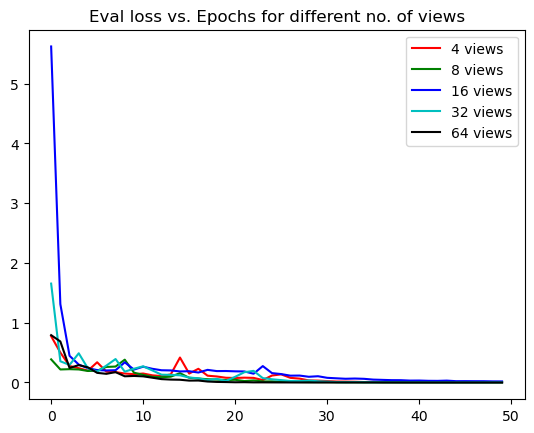

In [52]:
plt.figure()

colors = {4:'r',8:'g',16:'b',32:'c',64:'k'}
i=0
for view in [4,8,16,32,64]:
    plt.plot(eval_results[i], c=colors[view], label=f'{view} views')
    i+=1

plt.title('Eval loss vs. Epochs for different no. of views')

plt.legend()
plt.show()

# Exp 3: Adding decorrelation step

In [8]:
coreg_configs = [CoregPromptTuningConfig(task_type=TaskType.CAUSAL_LM, 
                                      num_views=8, 
                                      num_virtual_tokens=100,
                                      token_dim=1024,
                                      attention_dim=256, decorrelate=True,decorrelate_lambda=0.2),
                CoregPromptTuningConfig(task_type=TaskType.CAUSAL_LM, 
                                      num_views=8, 
                                      num_virtual_tokens=100,
                                      token_dim=1024,
                                      attention_dim=256, decorrelate=False,decorrelate_lambda=0.2),
                CoregPromptTuningConfig(task_type=TaskType.CAUSAL_LM, 
                                      num_views=8, 
                                      num_virtual_tokens=100,
                                      token_dim=1024,
                                      attention_dim=64, decorrelate=True,decorrelate_lambda=0.2),
                CoregPromptTuningConfig(task_type=TaskType.CAUSAL_LM, 
                                      num_views=8, 
                                      num_virtual_tokens=100,
                                      token_dim=1024,
                                      attention_dim=64, decorrelate=False,decorrelate_lambda=0.2)]


eval_results2= []
for config in coreg_configs:
    eval_results2.append(train(config))

trainable params: 1,415,936 || all params: 560,630,528 || trainable%: 0.2525613446437223


100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


epoch=0: train_ppl=tensor(69.2080, device='cuda:0') train_epoch_loss=tensor(4.2371, device='cuda:0') eval_ppl=tensor(1.8987, device='cuda:0') eval_epoch_loss=tensor(0.6412, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


epoch=1: train_ppl=tensor(1.5517, device='cuda:0') train_epoch_loss=tensor(0.4394, device='cuda:0') eval_ppl=tensor(1.4195, device='cuda:0') eval_epoch_loss=tensor(0.3503, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.00it/s]


epoch=2: train_ppl=tensor(1.3842, device='cuda:0') train_epoch_loss=tensor(0.3252, device='cuda:0') eval_ppl=tensor(1.2511, device='cuda:0') eval_epoch_loss=tensor(0.2240, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.00it/s]


epoch=3: train_ppl=tensor(1.2342, device='cuda:0') train_epoch_loss=tensor(0.2104, device='cuda:0') eval_ppl=tensor(1.3422, device='cuda:0') eval_epoch_loss=tensor(0.2943, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.01it/s]


epoch=4: train_ppl=tensor(1.3043, device='cuda:0') train_epoch_loss=tensor(0.2656, device='cuda:0') eval_ppl=tensor(1.1875, device='cuda:0') eval_epoch_loss=tensor(0.1718, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.00it/s]


epoch=5: train_ppl=tensor(1.1956, device='cuda:0') train_epoch_loss=tensor(0.1786, device='cuda:0') eval_ppl=tensor(1.1789, device='cuda:0') eval_epoch_loss=tensor(0.1646, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  5.97it/s]


epoch=6: train_ppl=tensor(1.1639, device='cuda:0') train_epoch_loss=tensor(0.1517, device='cuda:0') eval_ppl=tensor(1.1863, device='cuda:0') eval_epoch_loss=tensor(0.1708, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


epoch=7: train_ppl=tensor(1.2757, device='cuda:0') train_epoch_loss=tensor(0.2435, device='cuda:0') eval_ppl=tensor(1.1767, device='cuda:0') eval_epoch_loss=tensor(0.1627, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.00it/s]


epoch=8: train_ppl=tensor(1.2196, device='cuda:0') train_epoch_loss=tensor(0.1986, device='cuda:0') eval_ppl=tensor(1.2350, device='cuda:0') eval_epoch_loss=tensor(0.2111, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


epoch=9: train_ppl=tensor(1.2042, device='cuda:0') train_epoch_loss=tensor(0.1858, device='cuda:0') eval_ppl=tensor(1.1561, device='cuda:0') eval_epoch_loss=tensor(0.1450, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


epoch=10: train_ppl=tensor(1.1645, device='cuda:0') train_epoch_loss=tensor(0.1523, device='cuda:0') eval_ppl=tensor(1.1416, device='cuda:0') eval_epoch_loss=tensor(0.1324, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.01it/s]


epoch=11: train_ppl=tensor(1.1456, device='cuda:0') train_epoch_loss=tensor(0.1359, device='cuda:0') eval_ppl=tensor(1.1262, device='cuda:0') eval_epoch_loss=tensor(0.1189, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


epoch=12: train_ppl=tensor(1.1424, device='cuda:0') train_epoch_loss=tensor(0.1331, device='cuda:0') eval_ppl=tensor(1.2243, device='cuda:0') eval_epoch_loss=tensor(0.2024, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


epoch=13: train_ppl=tensor(1.1582, device='cuda:0') train_epoch_loss=tensor(0.1468, device='cuda:0') eval_ppl=tensor(1.1244, device='cuda:0') eval_epoch_loss=tensor(0.1172, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


epoch=14: train_ppl=tensor(1.1341, device='cuda:0') train_epoch_loss=tensor(0.1259, device='cuda:0') eval_ppl=tensor(1.1043, device='cuda:0') eval_epoch_loss=tensor(0.0993, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


epoch=15: train_ppl=tensor(1.1219, device='cuda:0') train_epoch_loss=tensor(0.1150, device='cuda:0') eval_ppl=tensor(1.1028, device='cuda:0') eval_epoch_loss=tensor(0.0978, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


epoch=16: train_ppl=tensor(1.1251, device='cuda:0') train_epoch_loss=tensor(0.1179, device='cuda:0') eval_ppl=tensor(1.1070, device='cuda:0') eval_epoch_loss=tensor(0.1017, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


epoch=17: train_ppl=tensor(1.1161, device='cuda:0') train_epoch_loss=tensor(0.1098, device='cuda:0') eval_ppl=tensor(1.1443, device='cuda:0') eval_epoch_loss=tensor(0.1348, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.01it/s]


epoch=18: train_ppl=tensor(1.1209, device='cuda:0') train_epoch_loss=tensor(0.1142, device='cuda:0') eval_ppl=tensor(1.0861, device='cuda:0') eval_epoch_loss=tensor(0.0826, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.00it/s]


epoch=19: train_ppl=tensor(1.0939, device='cuda:0') train_epoch_loss=tensor(0.0897, device='cuda:0') eval_ppl=tensor(1.0569, device='cuda:0') eval_epoch_loss=tensor(0.0553, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


epoch=20: train_ppl=tensor(1.0697, device='cuda:0') train_epoch_loss=tensor(0.0674, device='cuda:0') eval_ppl=tensor(1.0610, device='cuda:0') eval_epoch_loss=tensor(0.0592, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.00it/s]


epoch=21: train_ppl=tensor(1.0585, device='cuda:0') train_epoch_loss=tensor(0.0569, device='cuda:0') eval_ppl=tensor(1.0414, device='cuda:0') eval_epoch_loss=tensor(0.0406, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


epoch=22: train_ppl=tensor(1.0469, device='cuda:0') train_epoch_loss=tensor(0.0459, device='cuda:0') eval_ppl=tensor(1.0302, device='cuda:0') eval_epoch_loss=tensor(0.0298, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.01it/s]


epoch=23: train_ppl=tensor(1.0437, device='cuda:0') train_epoch_loss=tensor(0.0428, device='cuda:0') eval_ppl=tensor(1.0379, device='cuda:0') eval_epoch_loss=tensor(0.0372, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


epoch=24: train_ppl=tensor(1.0219, device='cuda:0') train_epoch_loss=tensor(0.0217, device='cuda:0') eval_ppl=tensor(1.0292, device='cuda:0') eval_epoch_loss=tensor(0.0288, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


epoch=25: train_ppl=tensor(1.0272, device='cuda:0') train_epoch_loss=tensor(0.0269, device='cuda:0') eval_ppl=tensor(1.0164, device='cuda:0') eval_epoch_loss=tensor(0.0162, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.00it/s]


epoch=26: train_ppl=tensor(1.0115, device='cuda:0') train_epoch_loss=tensor(0.0114, device='cuda:0') eval_ppl=tensor(1.0116, device='cuda:0') eval_epoch_loss=tensor(0.0116, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


epoch=27: train_ppl=tensor(1.0078, device='cuda:0') train_epoch_loss=tensor(0.0078, device='cuda:0') eval_ppl=tensor(1.0072, device='cuda:0') eval_epoch_loss=tensor(0.0072, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  5.95it/s]


epoch=28: train_ppl=tensor(1.0073, device='cuda:0') train_epoch_loss=tensor(0.0073, device='cuda:0') eval_ppl=tensor(1.0044, device='cuda:0') eval_epoch_loss=tensor(0.0044, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  6.00it/s]


epoch=29: train_ppl=tensor(1.0039, device='cuda:0') train_epoch_loss=tensor(0.0039, device='cuda:0') eval_ppl=tensor(1.0027, device='cuda:0') eval_epoch_loss=tensor(0.0027, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


epoch=30: train_ppl=tensor(1.0026, device='cuda:0') train_epoch_loss=tensor(0.0026, device='cuda:0') eval_ppl=tensor(1.0023, device='cuda:0') eval_epoch_loss=tensor(0.0023, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


epoch=31: train_ppl=tensor(1.0022, device='cuda:0') train_epoch_loss=tensor(0.0022, device='cuda:0') eval_ppl=tensor(1.0019, device='cuda:0') eval_epoch_loss=tensor(0.0019, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


epoch=32: train_ppl=tensor(1.0019, device='cuda:0') train_epoch_loss=tensor(0.0019, device='cuda:0') eval_ppl=tensor(1.0016, device='cuda:0') eval_epoch_loss=tensor(0.0016, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


epoch=33: train_ppl=tensor(1.0016, device='cuda:0') train_epoch_loss=tensor(0.0016, device='cuda:0') eval_ppl=tensor(1.0014, device='cuda:0') eval_epoch_loss=tensor(0.0014, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


epoch=34: train_ppl=tensor(1.0014, device='cuda:0') train_epoch_loss=tensor(0.0014, device='cuda:0') eval_ppl=tensor(1.0013, device='cuda:0') eval_epoch_loss=tensor(0.0013, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


epoch=35: train_ppl=tensor(1.0014, device='cuda:0') train_epoch_loss=tensor(0.0014, device='cuda:0') eval_ppl=tensor(1.0012, device='cuda:0') eval_epoch_loss=tensor(0.0012, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


epoch=36: train_ppl=tensor(1.0013, device='cuda:0') train_epoch_loss=tensor(0.0013, device='cuda:0') eval_ppl=tensor(1.0011, device='cuda:0') eval_epoch_loss=tensor(0.0011, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


epoch=37: train_ppl=tensor(1.0012, device='cuda:0') train_epoch_loss=tensor(0.0012, device='cuda:0') eval_ppl=tensor(1.0011, device='cuda:0') eval_epoch_loss=tensor(0.0011, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


epoch=38: train_ppl=tensor(1.0011, device='cuda:0') train_epoch_loss=tensor(0.0011, device='cuda:0') eval_ppl=tensor(1.0010, device='cuda:0') eval_epoch_loss=tensor(0.0010, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  5.97it/s]


epoch=39: train_ppl=tensor(1.0010, device='cuda:0') train_epoch_loss=tensor(0.0010, device='cuda:0') eval_ppl=tensor(1.0010, device='cuda:0') eval_epoch_loss=tensor(0.0010, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  5.97it/s]


epoch=40: train_ppl=tensor(1.0010, device='cuda:0') train_epoch_loss=tensor(0.0010, device='cuda:0') eval_ppl=tensor(1.0009, device='cuda:0') eval_epoch_loss=tensor(0.0009, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


epoch=41: train_ppl=tensor(1.0009, device='cuda:0') train_epoch_loss=tensor(0.0009, device='cuda:0') eval_ppl=tensor(1.0009, device='cuda:0') eval_epoch_loss=tensor(0.0009, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.00it/s]


epoch=42: train_ppl=tensor(1.0009, device='cuda:0') train_epoch_loss=tensor(0.0009, device='cuda:0') eval_ppl=tensor(1.0009, device='cuda:0') eval_epoch_loss=tensor(0.0009, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


epoch=43: train_ppl=tensor(1.0009, device='cuda:0') train_epoch_loss=tensor(0.0009, device='cuda:0') eval_ppl=tensor(1.0009, device='cuda:0') eval_epoch_loss=tensor(0.0009, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.00it/s]


epoch=44: train_ppl=tensor(1.0009, device='cuda:0') train_epoch_loss=tensor(0.0009, device='cuda:0') eval_ppl=tensor(1.0008, device='cuda:0') eval_epoch_loss=tensor(0.0008, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  5.97it/s]


epoch=45: train_ppl=tensor(1.0009, device='cuda:0') train_epoch_loss=tensor(0.0009, device='cuda:0') eval_ppl=tensor(1.0008, device='cuda:0') eval_epoch_loss=tensor(0.0008, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


epoch=46: train_ppl=tensor(1.0008, device='cuda:0') train_epoch_loss=tensor(0.0008, device='cuda:0') eval_ppl=tensor(1.0008, device='cuda:0') eval_epoch_loss=tensor(0.0008, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  5.97it/s]


epoch=47: train_ppl=tensor(1.0008, device='cuda:0') train_epoch_loss=tensor(0.0008, device='cuda:0') eval_ppl=tensor(1.0008, device='cuda:0') eval_epoch_loss=tensor(0.0008, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


epoch=48: train_ppl=tensor(1.0009, device='cuda:0') train_epoch_loss=tensor(0.0009, device='cuda:0') eval_ppl=tensor(1.0008, device='cuda:0') eval_epoch_loss=tensor(0.0008, device='cuda:0')


100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


epoch=49: train_ppl=tensor(1.0008, device='cuda:0') train_epoch_loss=tensor(0.0008, device='cuda:0') eval_ppl=tensor(1.0008, device='cuda:0') eval_epoch_loss=tensor(0.0008, device='cuda:0')
trainable params: 1,415,936 || all params: 560,630,528 || trainable%: 0.2525613446437223


100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


epoch=0: train_ppl=tensor(201.9305, device='cuda:0') train_epoch_loss=tensor(5.3079, device='cuda:0') eval_ppl=tensor(20.2605, device='cuda:0') eval_epoch_loss=tensor(3.0087, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


epoch=1: train_ppl=tensor(3.6336, device='cuda:0') train_epoch_loss=tensor(1.2902, device='cuda:0') eval_ppl=tensor(1.4646, device='cuda:0') eval_epoch_loss=tensor(0.3816, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


epoch=2: train_ppl=tensor(1.5713, device='cuda:0') train_epoch_loss=tensor(0.4519, device='cuda:0') eval_ppl=tensor(1.4057, device='cuda:0') eval_epoch_loss=tensor(0.3405, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


epoch=3: train_ppl=tensor(1.3967, device='cuda:0') train_epoch_loss=tensor(0.3341, device='cuda:0') eval_ppl=tensor(1.3408, device='cuda:0') eval_epoch_loss=tensor(0.2932, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


epoch=4: train_ppl=tensor(1.3171, device='cuda:0') train_epoch_loss=tensor(0.2755, device='cuda:0') eval_ppl=tensor(1.2753, device='cuda:0') eval_epoch_loss=tensor(0.2432, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


epoch=5: train_ppl=tensor(1.2752, device='cuda:0') train_epoch_loss=tensor(0.2431, device='cuda:0') eval_ppl=tensor(1.2683, device='cuda:0') eval_epoch_loss=tensor(0.2377, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


epoch=6: train_ppl=tensor(1.2570, device='cuda:0') train_epoch_loss=tensor(0.2287, device='cuda:0') eval_ppl=tensor(1.1847, device='cuda:0') eval_epoch_loss=tensor(0.1695, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


epoch=7: train_ppl=tensor(1.2914, device='cuda:0') train_epoch_loss=tensor(0.2557, device='cuda:0') eval_ppl=tensor(1.2525, device='cuda:0') eval_epoch_loss=tensor(0.2251, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


epoch=8: train_ppl=tensor(1.2216, device='cuda:0') train_epoch_loss=tensor(0.2002, device='cuda:0') eval_ppl=tensor(1.1693, device='cuda:0') eval_epoch_loss=tensor(0.1564, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


epoch=9: train_ppl=tensor(1.1609, device='cuda:0') train_epoch_loss=tensor(0.1492, device='cuda:0') eval_ppl=tensor(1.1386, device='cuda:0') eval_epoch_loss=tensor(0.1298, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


epoch=10: train_ppl=tensor(1.1359, device='cuda:0') train_epoch_loss=tensor(0.1274, device='cuda:0') eval_ppl=tensor(1.1189, device='cuda:0') eval_epoch_loss=tensor(0.1123, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


epoch=11: train_ppl=tensor(1.1364, device='cuda:0') train_epoch_loss=tensor(0.1279, device='cuda:0') eval_ppl=tensor(1.1008, device='cuda:0') eval_epoch_loss=tensor(0.0960, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.37it/s]


epoch=12: train_ppl=tensor(1.1020, device='cuda:0') train_epoch_loss=tensor(0.0971, device='cuda:0') eval_ppl=tensor(1.1027, device='cuda:0') eval_epoch_loss=tensor(0.0977, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.37it/s]


epoch=13: train_ppl=tensor(1.5188, device='cuda:0') train_epoch_loss=tensor(0.4179, device='cuda:0') eval_ppl=tensor(1.1243, device='cuda:0') eval_epoch_loss=tensor(0.1172, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


epoch=14: train_ppl=tensor(1.3198, device='cuda:0') train_epoch_loss=tensor(0.2775, device='cuda:0') eval_ppl=tensor(1.3261, device='cuda:0') eval_epoch_loss=tensor(0.2823, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


epoch=15: train_ppl=tensor(1.3610, device='cuda:0') train_epoch_loss=tensor(0.3082, device='cuda:0') eval_ppl=tensor(1.2411, device='cuda:0') eval_epoch_loss=tensor(0.2160, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


epoch=16: train_ppl=tensor(1.3434, device='cuda:0') train_epoch_loss=tensor(0.2952, device='cuda:0') eval_ppl=tensor(1.2223, device='cuda:0') eval_epoch_loss=tensor(0.2007, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


epoch=17: train_ppl=tensor(1.2502, device='cuda:0') train_epoch_loss=tensor(0.2233, device='cuda:0') eval_ppl=tensor(1.2276, device='cuda:0') eval_epoch_loss=tensor(0.2051, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


epoch=18: train_ppl=tensor(1.3071, device='cuda:0') train_epoch_loss=tensor(0.2678, device='cuda:0') eval_ppl=tensor(1.1943, device='cuda:0') eval_epoch_loss=tensor(0.1776, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


epoch=19: train_ppl=tensor(1.2742, device='cuda:0') train_epoch_loss=tensor(0.2423, device='cuda:0') eval_ppl=tensor(1.1753, device='cuda:0') eval_epoch_loss=tensor(0.1615, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


epoch=20: train_ppl=tensor(1.2126, device='cuda:0') train_epoch_loss=tensor(0.1928, device='cuda:0') eval_ppl=tensor(1.1852, device='cuda:0') eval_epoch_loss=tensor(0.1699, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


epoch=21: train_ppl=tensor(1.2361, device='cuda:0') train_epoch_loss=tensor(0.2120, device='cuda:0') eval_ppl=tensor(1.1684, device='cuda:0') eval_epoch_loss=tensor(0.1556, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


epoch=22: train_ppl=tensor(1.1766, device='cuda:0') train_epoch_loss=tensor(0.1626, device='cuda:0') eval_ppl=tensor(1.1867, device='cuda:0') eval_epoch_loss=tensor(0.1711, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


epoch=23: train_ppl=tensor(1.1856, device='cuda:0') train_epoch_loss=tensor(0.1703, device='cuda:0') eval_ppl=tensor(1.1845, device='cuda:0') eval_epoch_loss=tensor(0.1693, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


epoch=24: train_ppl=tensor(1.1495, device='cuda:0') train_epoch_loss=tensor(0.1394, device='cuda:0') eval_ppl=tensor(1.1614, device='cuda:0') eval_epoch_loss=tensor(0.1496, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


epoch=25: train_ppl=tensor(1.1494, device='cuda:0') train_epoch_loss=tensor(0.1393, device='cuda:0') eval_ppl=tensor(1.1562, device='cuda:0') eval_epoch_loss=tensor(0.1451, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


epoch=26: train_ppl=tensor(1.1262, device='cuda:0') train_epoch_loss=tensor(0.1189, device='cuda:0') eval_ppl=tensor(1.1411, device='cuda:0') eval_epoch_loss=tensor(0.1320, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


epoch=27: train_ppl=tensor(1.1217, device='cuda:0') train_epoch_loss=tensor(0.1149, device='cuda:0') eval_ppl=tensor(1.1143, device='cuda:0') eval_epoch_loss=tensor(0.1082, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


epoch=28: train_ppl=tensor(1.1213, device='cuda:0') train_epoch_loss=tensor(0.1144, device='cuda:0') eval_ppl=tensor(1.1033, device='cuda:0') eval_epoch_loss=tensor(0.0983, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


epoch=29: train_ppl=tensor(1.1006, device='cuda:0') train_epoch_loss=tensor(0.0959, device='cuda:0') eval_ppl=tensor(1.1117, device='cuda:0') eval_epoch_loss=tensor(0.1059, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


epoch=30: train_ppl=tensor(1.1015, device='cuda:0') train_epoch_loss=tensor(0.0967, device='cuda:0') eval_ppl=tensor(1.0929, device='cuda:0') eval_epoch_loss=tensor(0.0889, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


epoch=31: train_ppl=tensor(1.0953, device='cuda:0') train_epoch_loss=tensor(0.0911, device='cuda:0') eval_ppl=tensor(1.0798, device='cuda:0') eval_epoch_loss=tensor(0.0768, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


epoch=32: train_ppl=tensor(1.0730, device='cuda:0') train_epoch_loss=tensor(0.0705, device='cuda:0') eval_ppl=tensor(1.0743, device='cuda:0') eval_epoch_loss=tensor(0.0717, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


epoch=33: train_ppl=tensor(1.0814, device='cuda:0') train_epoch_loss=tensor(0.0782, device='cuda:0') eval_ppl=tensor(1.0718, device='cuda:0') eval_epoch_loss=tensor(0.0693, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


epoch=34: train_ppl=tensor(1.0645, device='cuda:0') train_epoch_loss=tensor(0.0625, device='cuda:0') eval_ppl=tensor(1.0596, device='cuda:0') eval_epoch_loss=tensor(0.0579, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


epoch=35: train_ppl=tensor(1.0593, device='cuda:0') train_epoch_loss=tensor(0.0577, device='cuda:0') eval_ppl=tensor(1.0590, device='cuda:0') eval_epoch_loss=tensor(0.0573, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


epoch=36: train_ppl=tensor(1.0604, device='cuda:0') train_epoch_loss=tensor(0.0586, device='cuda:0') eval_ppl=tensor(1.0566, device='cuda:0') eval_epoch_loss=tensor(0.0551, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


epoch=37: train_ppl=tensor(1.0500, device='cuda:0') train_epoch_loss=tensor(0.0488, device='cuda:0') eval_ppl=tensor(1.0457, device='cuda:0') eval_epoch_loss=tensor(0.0447, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


epoch=38: train_ppl=tensor(1.0440, device='cuda:0') train_epoch_loss=tensor(0.0431, device='cuda:0') eval_ppl=tensor(1.0424, device='cuda:0') eval_epoch_loss=tensor(0.0415, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


epoch=39: train_ppl=tensor(1.0451, device='cuda:0') train_epoch_loss=tensor(0.0441, device='cuda:0') eval_ppl=tensor(1.0429, device='cuda:0') eval_epoch_loss=tensor(0.0420, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


epoch=40: train_ppl=tensor(1.0416, device='cuda:0') train_epoch_loss=tensor(0.0407, device='cuda:0') eval_ppl=tensor(1.0372, device='cuda:0') eval_epoch_loss=tensor(0.0366, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


epoch=41: train_ppl=tensor(1.0389, device='cuda:0') train_epoch_loss=tensor(0.0381, device='cuda:0') eval_ppl=tensor(1.0346, device='cuda:0') eval_epoch_loss=tensor(0.0340, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


epoch=42: train_ppl=tensor(1.0330, device='cuda:0') train_epoch_loss=tensor(0.0325, device='cuda:0') eval_ppl=tensor(1.0334, device='cuda:0') eval_epoch_loss=tensor(0.0329, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


epoch=43: train_ppl=tensor(1.0301, device='cuda:0') train_epoch_loss=tensor(0.0296, device='cuda:0') eval_ppl=tensor(1.0315, device='cuda:0') eval_epoch_loss=tensor(0.0310, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


epoch=44: train_ppl=tensor(1.0336, device='cuda:0') train_epoch_loss=tensor(0.0331, device='cuda:0') eval_ppl=tensor(1.0301, device='cuda:0') eval_epoch_loss=tensor(0.0296, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


epoch=45: train_ppl=tensor(1.0325, device='cuda:0') train_epoch_loss=tensor(0.0320, device='cuda:0') eval_ppl=tensor(1.0292, device='cuda:0') eval_epoch_loss=tensor(0.0288, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


epoch=46: train_ppl=tensor(1.0293, device='cuda:0') train_epoch_loss=tensor(0.0289, device='cuda:0') eval_ppl=tensor(1.0280, device='cuda:0') eval_epoch_loss=tensor(0.0276, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


epoch=47: train_ppl=tensor(1.0266, device='cuda:0') train_epoch_loss=tensor(0.0262, device='cuda:0') eval_ppl=tensor(1.0274, device='cuda:0') eval_epoch_loss=tensor(0.0270, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


epoch=48: train_ppl=tensor(1.0270, device='cuda:0') train_epoch_loss=tensor(0.0266, device='cuda:0') eval_ppl=tensor(1.0269, device='cuda:0') eval_epoch_loss=tensor(0.0266, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.32it/s]


epoch=49: train_ppl=tensor(1.0261, device='cuda:0') train_epoch_loss=tensor(0.0258, device='cuda:0') eval_ppl=tensor(1.0268, device='cuda:0') eval_epoch_loss=tensor(0.0264, device='cuda:0')
trainable params: 382,400 || all params: 559,596,992 || trainable%: 0.06833489197883322


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=0: train_ppl=tensor(157.0552, device='cuda:0') train_epoch_loss=tensor(5.0566, device='cuda:0') eval_ppl=tensor(4.8318, device='cuda:0') eval_epoch_loss=tensor(1.5752, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=1: train_ppl=tensor(2.2985, device='cuda:0') train_epoch_loss=tensor(0.8322, device='cuda:0') eval_ppl=tensor(1.3964, device='cuda:0') eval_epoch_loss=tensor(0.3339, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=2: train_ppl=tensor(1.5256, device='cuda:0') train_epoch_loss=tensor(0.4224, device='cuda:0') eval_ppl=tensor(1.3762, device='cuda:0') eval_epoch_loss=tensor(0.3193, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=3: train_ppl=tensor(1.3551, device='cuda:0') train_epoch_loss=tensor(0.3039, device='cuda:0') eval_ppl=tensor(1.2331, device='cuda:0') eval_epoch_loss=tensor(0.2095, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=4: train_ppl=tensor(1.2383, device='cuda:0') train_epoch_loss=tensor(0.2137, device='cuda:0') eval_ppl=tensor(1.2750, device='cuda:0') eval_epoch_loss=tensor(0.2430, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=5: train_ppl=tensor(1.2976, device='cuda:0') train_epoch_loss=tensor(0.2605, device='cuda:0') eval_ppl=tensor(1.3577, device='cuda:0') eval_epoch_loss=tensor(0.3058, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=6: train_ppl=tensor(1.2905, device='cuda:0') train_epoch_loss=tensor(0.2551, device='cuda:0') eval_ppl=tensor(1.1732, device='cuda:0') eval_epoch_loss=tensor(0.1597, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=7: train_ppl=tensor(1.1554, device='cuda:0') train_epoch_loss=tensor(0.1444, device='cuda:0') eval_ppl=tensor(1.1419, device='cuda:0') eval_epoch_loss=tensor(0.1327, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=8: train_ppl=tensor(1.1783, device='cuda:0') train_epoch_loss=tensor(0.1640, device='cuda:0') eval_ppl=tensor(1.2100, device='cuda:0') eval_epoch_loss=tensor(0.1906, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=9: train_ppl=tensor(1.2406, device='cuda:0') train_epoch_loss=tensor(0.2156, device='cuda:0') eval_ppl=tensor(1.1304, device='cuda:0') eval_epoch_loss=tensor(0.1226, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=10: train_ppl=tensor(1.2200, device='cuda:0') train_epoch_loss=tensor(0.1988, device='cuda:0') eval_ppl=tensor(1.1388, device='cuda:0') eval_epoch_loss=tensor(0.1300, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


epoch=11: train_ppl=tensor(1.1561, device='cuda:0') train_epoch_loss=tensor(0.1451, device='cuda:0') eval_ppl=tensor(1.1111, device='cuda:0') eval_epoch_loss=tensor(0.1053, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


epoch=12: train_ppl=tensor(1.0850, device='cuda:0') train_epoch_loss=tensor(0.0816, device='cuda:0') eval_ppl=tensor(1.1784, device='cuda:0') eval_epoch_loss=tensor(0.1642, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=13: train_ppl=tensor(1.1403, device='cuda:0') train_epoch_loss=tensor(0.1313, device='cuda:0') eval_ppl=tensor(1.2110, device='cuda:0') eval_epoch_loss=tensor(0.1915, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=14: train_ppl=tensor(1.1421, device='cuda:0') train_epoch_loss=tensor(0.1329, device='cuda:0') eval_ppl=tensor(1.0854, device='cuda:0') eval_epoch_loss=tensor(0.0820, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


epoch=15: train_ppl=tensor(1.0764, device='cuda:0') train_epoch_loss=tensor(0.0736, device='cuda:0') eval_ppl=tensor(1.0605, device='cuda:0') eval_epoch_loss=tensor(0.0588, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


epoch=16: train_ppl=tensor(1.0556, device='cuda:0') train_epoch_loss=tensor(0.0541, device='cuda:0') eval_ppl=tensor(1.0400, device='cuda:0') eval_epoch_loss=tensor(0.0392, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


epoch=17: train_ppl=tensor(1.0418, device='cuda:0') train_epoch_loss=tensor(0.0409, device='cuda:0') eval_ppl=tensor(1.0295, device='cuda:0') eval_epoch_loss=tensor(0.0290, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


epoch=18: train_ppl=tensor(1.0267, device='cuda:0') train_epoch_loss=tensor(0.0263, device='cuda:0') eval_ppl=tensor(1.0201, device='cuda:0') eval_epoch_loss=tensor(0.0199, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=19: train_ppl=tensor(1.0149, device='cuda:0') train_epoch_loss=tensor(0.0148, device='cuda:0') eval_ppl=tensor(1.0139, device='cuda:0') eval_epoch_loss=tensor(0.0138, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=20: train_ppl=tensor(1.0168, device='cuda:0') train_epoch_loss=tensor(0.0167, device='cuda:0') eval_ppl=tensor(1.0110, device='cuda:0') eval_epoch_loss=tensor(0.0109, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=21: train_ppl=tensor(1.0091, device='cuda:0') train_epoch_loss=tensor(0.0091, device='cuda:0') eval_ppl=tensor(1.0071, device='cuda:0') eval_epoch_loss=tensor(0.0071, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=22: train_ppl=tensor(1.0061, device='cuda:0') train_epoch_loss=tensor(0.0061, device='cuda:0') eval_ppl=tensor(1.0059, device='cuda:0') eval_epoch_loss=tensor(0.0059, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=23: train_ppl=tensor(1.0047, device='cuda:0') train_epoch_loss=tensor(0.0047, device='cuda:0') eval_ppl=tensor(1.0039, device='cuda:0') eval_epoch_loss=tensor(0.0039, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=24: train_ppl=tensor(1.0043, device='cuda:0') train_epoch_loss=tensor(0.0043, device='cuda:0') eval_ppl=tensor(1.0032, device='cuda:0') eval_epoch_loss=tensor(0.0032, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=25: train_ppl=tensor(1.0032, device='cuda:0') train_epoch_loss=tensor(0.0032, device='cuda:0') eval_ppl=tensor(1.0023, device='cuda:0') eval_epoch_loss=tensor(0.0023, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=26: train_ppl=tensor(1.0025, device='cuda:0') train_epoch_loss=tensor(0.0025, device='cuda:0') eval_ppl=tensor(1.0019, device='cuda:0') eval_epoch_loss=tensor(0.0019, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=27: train_ppl=tensor(1.0023, device='cuda:0') train_epoch_loss=tensor(0.0023, device='cuda:0') eval_ppl=tensor(1.0017, device='cuda:0') eval_epoch_loss=tensor(0.0017, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=28: train_ppl=tensor(1.0022, device='cuda:0') train_epoch_loss=tensor(0.0022, device='cuda:0') eval_ppl=tensor(1.0019, device='cuda:0') eval_epoch_loss=tensor(0.0019, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=29: train_ppl=tensor(1.0013, device='cuda:0') train_epoch_loss=tensor(0.0013, device='cuda:0') eval_ppl=tensor(1.0013, device='cuda:0') eval_epoch_loss=tensor(0.0013, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=30: train_ppl=tensor(1.0013, device='cuda:0') train_epoch_loss=tensor(0.0013, device='cuda:0') eval_ppl=tensor(1.0013, device='cuda:0') eval_epoch_loss=tensor(0.0013, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=31: train_ppl=tensor(1.0012, device='cuda:0') train_epoch_loss=tensor(0.0012, device='cuda:0') eval_ppl=tensor(1.0010, device='cuda:0') eval_epoch_loss=tensor(0.0010, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=32: train_ppl=tensor(1.0011, device='cuda:0') train_epoch_loss=tensor(0.0011, device='cuda:0') eval_ppl=tensor(1.0010, device='cuda:0') eval_epoch_loss=tensor(0.0010, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=33: train_ppl=tensor(1.0011, device='cuda:0') train_epoch_loss=tensor(0.0011, device='cuda:0') eval_ppl=tensor(1.0009, device='cuda:0') eval_epoch_loss=tensor(0.0009, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=34: train_ppl=tensor(1.0010, device='cuda:0') train_epoch_loss=tensor(0.0010, device='cuda:0') eval_ppl=tensor(1.0009, device='cuda:0') eval_epoch_loss=tensor(0.0009, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=35: train_ppl=tensor(1.0008, device='cuda:0') train_epoch_loss=tensor(0.0008, device='cuda:0') eval_ppl=tensor(1.0008, device='cuda:0') eval_epoch_loss=tensor(0.0008, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=36: train_ppl=tensor(1.0008, device='cuda:0') train_epoch_loss=tensor(0.0008, device='cuda:0') eval_ppl=tensor(1.0008, device='cuda:0') eval_epoch_loss=tensor(0.0008, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=37: train_ppl=tensor(1.0008, device='cuda:0') train_epoch_loss=tensor(0.0008, device='cuda:0') eval_ppl=tensor(1.0007, device='cuda:0') eval_epoch_loss=tensor(0.0007, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=38: train_ppl=tensor(1.0007, device='cuda:0') train_epoch_loss=tensor(0.0007, device='cuda:0') eval_ppl=tensor(1.0007, device='cuda:0') eval_epoch_loss=tensor(0.0007, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=39: train_ppl=tensor(1.0007, device='cuda:0') train_epoch_loss=tensor(0.0007, device='cuda:0') eval_ppl=tensor(1.0007, device='cuda:0') eval_epoch_loss=tensor(0.0007, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=40: train_ppl=tensor(1.0007, device='cuda:0') train_epoch_loss=tensor(0.0007, device='cuda:0') eval_ppl=tensor(1.0006, device='cuda:0') eval_epoch_loss=tensor(0.0006, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=41: train_ppl=tensor(1.0007, device='cuda:0') train_epoch_loss=tensor(0.0007, device='cuda:0') eval_ppl=tensor(1.0006, device='cuda:0') eval_epoch_loss=tensor(0.0006, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=42: train_ppl=tensor(1.0007, device='cuda:0') train_epoch_loss=tensor(0.0007, device='cuda:0') eval_ppl=tensor(1.0006, device='cuda:0') eval_epoch_loss=tensor(0.0006, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=43: train_ppl=tensor(1.0006, device='cuda:0') train_epoch_loss=tensor(0.0006, device='cuda:0') eval_ppl=tensor(1.0006, device='cuda:0') eval_epoch_loss=tensor(0.0006, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=44: train_ppl=tensor(1.0006, device='cuda:0') train_epoch_loss=tensor(0.0006, device='cuda:0') eval_ppl=tensor(1.0006, device='cuda:0') eval_epoch_loss=tensor(0.0006, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=45: train_ppl=tensor(1.0006, device='cuda:0') train_epoch_loss=tensor(0.0006, device='cuda:0') eval_ppl=tensor(1.0006, device='cuda:0') eval_epoch_loss=tensor(0.0006, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=46: train_ppl=tensor(1.0006, device='cuda:0') train_epoch_loss=tensor(0.0006, device='cuda:0') eval_ppl=tensor(1.0006, device='cuda:0') eval_epoch_loss=tensor(0.0006, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=47: train_ppl=tensor(1.0006, device='cuda:0') train_epoch_loss=tensor(0.0006, device='cuda:0') eval_ppl=tensor(1.0006, device='cuda:0') eval_epoch_loss=tensor(0.0006, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=48: train_ppl=tensor(1.0006, device='cuda:0') train_epoch_loss=tensor(0.0006, device='cuda:0') eval_ppl=tensor(1.0006, device='cuda:0') eval_epoch_loss=tensor(0.0006, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=49: train_ppl=tensor(1.0006, device='cuda:0') train_epoch_loss=tensor(0.0006, device='cuda:0') eval_ppl=tensor(1.0006, device='cuda:0') eval_epoch_loss=tensor(0.0006, device='cuda:0')
trainable params: 382,400 || all params: 559,596,992 || trainable%: 0.06833489197883322


100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


epoch=0: train_ppl=tensor(207.5848, device='cuda:0') train_epoch_loss=tensor(5.3355, device='cuda:0') eval_ppl=tensor(2.7965, device='cuda:0') eval_epoch_loss=tensor(1.0284, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


epoch=1: train_ppl=tensor(1.6424, device='cuda:0') train_epoch_loss=tensor(0.4962, device='cuda:0') eval_ppl=tensor(1.2557, device='cuda:0') eval_epoch_loss=tensor(0.2277, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


epoch=2: train_ppl=tensor(1.3894, device='cuda:0') train_epoch_loss=tensor(0.3288, device='cuda:0') eval_ppl=tensor(1.2256, device='cuda:0') eval_epoch_loss=tensor(0.2034, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


epoch=3: train_ppl=tensor(1.2103, device='cuda:0') train_epoch_loss=tensor(0.1909, device='cuda:0') eval_ppl=tensor(1.2166, device='cuda:0') eval_epoch_loss=tensor(0.1961, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


epoch=4: train_ppl=tensor(1.2865, device='cuda:0') train_epoch_loss=tensor(0.2519, device='cuda:0') eval_ppl=tensor(1.6606, device='cuda:0') eval_epoch_loss=tensor(0.5072, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


epoch=5: train_ppl=tensor(1.2886, device='cuda:0') train_epoch_loss=tensor(0.2536, device='cuda:0') eval_ppl=tensor(1.3370, device='cuda:0') eval_epoch_loss=tensor(0.2904, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


epoch=6: train_ppl=tensor(1.2419, device='cuda:0') train_epoch_loss=tensor(0.2166, device='cuda:0') eval_ppl=tensor(1.1666, device='cuda:0') eval_epoch_loss=tensor(0.1541, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


epoch=7: train_ppl=tensor(1.2656, device='cuda:0') train_epoch_loss=tensor(0.2356, device='cuda:0') eval_ppl=tensor(1.2995, device='cuda:0') eval_epoch_loss=tensor(0.2620, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.32it/s]


epoch=8: train_ppl=tensor(1.2268, device='cuda:0') train_epoch_loss=tensor(0.2044, device='cuda:0') eval_ppl=tensor(1.1425, device='cuda:0') eval_epoch_loss=tensor(0.1332, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.33it/s]


epoch=9: train_ppl=tensor(1.1801, device='cuda:0') train_epoch_loss=tensor(0.1656, device='cuda:0') eval_ppl=tensor(1.1168, device='cuda:0') eval_epoch_loss=tensor(0.1105, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


epoch=10: train_ppl=tensor(1.1108, device='cuda:0') train_epoch_loss=tensor(0.1051, device='cuda:0') eval_ppl=tensor(1.0986, device='cuda:0') eval_epoch_loss=tensor(0.0940, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


epoch=11: train_ppl=tensor(1.1581, device='cuda:0') train_epoch_loss=tensor(0.1468, device='cuda:0') eval_ppl=tensor(1.2271, device='cuda:0') eval_epoch_loss=tensor(0.2047, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


epoch=12: train_ppl=tensor(1.1651, device='cuda:0') train_epoch_loss=tensor(0.1528, device='cuda:0') eval_ppl=tensor(1.0745, device='cuda:0') eval_epoch_loss=tensor(0.0718, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


epoch=13: train_ppl=tensor(1.0990, device='cuda:0') train_epoch_loss=tensor(0.0944, device='cuda:0') eval_ppl=tensor(1.0650, device='cuda:0') eval_epoch_loss=tensor(0.0630, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


epoch=14: train_ppl=tensor(1.1490, device='cuda:0') train_epoch_loss=tensor(0.1389, device='cuda:0') eval_ppl=tensor(1.0805, device='cuda:0') eval_epoch_loss=tensor(0.0774, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.37it/s]


epoch=15: train_ppl=tensor(1.1014, device='cuda:0') train_epoch_loss=tensor(0.0965, device='cuda:0') eval_ppl=tensor(1.0948, device='cuda:0') eval_epoch_loss=tensor(0.0906, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


epoch=16: train_ppl=tensor(1.1009, device='cuda:0') train_epoch_loss=tensor(0.0962, device='cuda:0') eval_ppl=tensor(1.0653, device='cuda:0') eval_epoch_loss=tensor(0.0633, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


epoch=17: train_ppl=tensor(1.0816, device='cuda:0') train_epoch_loss=tensor(0.0785, device='cuda:0') eval_ppl=tensor(1.0761, device='cuda:0') eval_epoch_loss=tensor(0.0733, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.37it/s]


epoch=18: train_ppl=tensor(1.0592, device='cuda:0') train_epoch_loss=tensor(0.0575, device='cuda:0') eval_ppl=tensor(1.0751, device='cuda:0') eval_epoch_loss=tensor(0.0724, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


epoch=19: train_ppl=tensor(1.0420, device='cuda:0') train_epoch_loss=tensor(0.0412, device='cuda:0') eval_ppl=tensor(1.0395, device='cuda:0') eval_epoch_loss=tensor(0.0387, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.37it/s]


epoch=20: train_ppl=tensor(1.0210, device='cuda:0') train_epoch_loss=tensor(0.0208, device='cuda:0') eval_ppl=tensor(1.0209, device='cuda:0') eval_epoch_loss=tensor(0.0207, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


epoch=21: train_ppl=tensor(1.0220, device='cuda:0') train_epoch_loss=tensor(0.0217, device='cuda:0') eval_ppl=tensor(1.0104, device='cuda:0') eval_epoch_loss=tensor(0.0103, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


epoch=22: train_ppl=tensor(1.0140, device='cuda:0') train_epoch_loss=tensor(0.0139, device='cuda:0') eval_ppl=tensor(1.0043, device='cuda:0') eval_epoch_loss=tensor(0.0043, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.37it/s]


epoch=23: train_ppl=tensor(1.0085, device='cuda:0') train_epoch_loss=tensor(0.0085, device='cuda:0') eval_ppl=tensor(1.0029, device='cuda:0') eval_epoch_loss=tensor(0.0029, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


epoch=24: train_ppl=tensor(1.0028, device='cuda:0') train_epoch_loss=tensor(0.0028, device='cuda:0') eval_ppl=tensor(1.0024, device='cuda:0') eval_epoch_loss=tensor(0.0024, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.33it/s]


epoch=25: train_ppl=tensor(1.0025, device='cuda:0') train_epoch_loss=tensor(0.0025, device='cuda:0') eval_ppl=tensor(1.0017, device='cuda:0') eval_epoch_loss=tensor(0.0017, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.33it/s]


epoch=26: train_ppl=tensor(1.0014, device='cuda:0') train_epoch_loss=tensor(0.0014, device='cuda:0') eval_ppl=tensor(1.0011, device='cuda:0') eval_epoch_loss=tensor(0.0011, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


epoch=27: train_ppl=tensor(1.0011, device='cuda:0') train_epoch_loss=tensor(0.0011, device='cuda:0') eval_ppl=tensor(1.0010, device='cuda:0') eval_epoch_loss=tensor(0.0010, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


epoch=28: train_ppl=tensor(1.0010, device='cuda:0') train_epoch_loss=tensor(0.0010, device='cuda:0') eval_ppl=tensor(1.0008, device='cuda:0') eval_epoch_loss=tensor(0.0008, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


epoch=29: train_ppl=tensor(1.0009, device='cuda:0') train_epoch_loss=tensor(0.0009, device='cuda:0') eval_ppl=tensor(1.0007, device='cuda:0') eval_epoch_loss=tensor(0.0007, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


epoch=30: train_ppl=tensor(1.0007, device='cuda:0') train_epoch_loss=tensor(0.0007, device='cuda:0') eval_ppl=tensor(1.0007, device='cuda:0') eval_epoch_loss=tensor(0.0007, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


epoch=31: train_ppl=tensor(1.0007, device='cuda:0') train_epoch_loss=tensor(0.0007, device='cuda:0') eval_ppl=tensor(1.0006, device='cuda:0') eval_epoch_loss=tensor(0.0006, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


epoch=32: train_ppl=tensor(1.0007, device='cuda:0') train_epoch_loss=tensor(0.0007, device='cuda:0') eval_ppl=tensor(1.0006, device='cuda:0') eval_epoch_loss=tensor(0.0006, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


epoch=33: train_ppl=tensor(1.0006, device='cuda:0') train_epoch_loss=tensor(0.0006, device='cuda:0') eval_ppl=tensor(1.0005, device='cuda:0') eval_epoch_loss=tensor(0.0005, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


epoch=34: train_ppl=tensor(1.0006, device='cuda:0') train_epoch_loss=tensor(0.0006, device='cuda:0') eval_ppl=tensor(1.0005, device='cuda:0') eval_epoch_loss=tensor(0.0005, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


epoch=35: train_ppl=tensor(1.0005, device='cuda:0') train_epoch_loss=tensor(0.0005, device='cuda:0') eval_ppl=tensor(1.0005, device='cuda:0') eval_epoch_loss=tensor(0.0005, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


epoch=36: train_ppl=tensor(1.0005, device='cuda:0') train_epoch_loss=tensor(0.0005, device='cuda:0') eval_ppl=tensor(1.0005, device='cuda:0') eval_epoch_loss=tensor(0.0005, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


epoch=37: train_ppl=tensor(1.0005, device='cuda:0') train_epoch_loss=tensor(0.0005, device='cuda:0') eval_ppl=tensor(1.0005, device='cuda:0') eval_epoch_loss=tensor(0.0005, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


epoch=38: train_ppl=tensor(1.0005, device='cuda:0') train_epoch_loss=tensor(0.0005, device='cuda:0') eval_ppl=tensor(1.0004, device='cuda:0') eval_epoch_loss=tensor(0.0004, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


epoch=39: train_ppl=tensor(1.0005, device='cuda:0') train_epoch_loss=tensor(0.0005, device='cuda:0') eval_ppl=tensor(1.0004, device='cuda:0') eval_epoch_loss=tensor(0.0004, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


epoch=40: train_ppl=tensor(1.0005, device='cuda:0') train_epoch_loss=tensor(0.0005, device='cuda:0') eval_ppl=tensor(1.0004, device='cuda:0') eval_epoch_loss=tensor(0.0004, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


epoch=41: train_ppl=tensor(1.0005, device='cuda:0') train_epoch_loss=tensor(0.0005, device='cuda:0') eval_ppl=tensor(1.0004, device='cuda:0') eval_epoch_loss=tensor(0.0004, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


epoch=42: train_ppl=tensor(1.0004, device='cuda:0') train_epoch_loss=tensor(0.0004, device='cuda:0') eval_ppl=tensor(1.0004, device='cuda:0') eval_epoch_loss=tensor(0.0004, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


epoch=43: train_ppl=tensor(1.0005, device='cuda:0') train_epoch_loss=tensor(0.0005, device='cuda:0') eval_ppl=tensor(1.0004, device='cuda:0') eval_epoch_loss=tensor(0.0004, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


epoch=44: train_ppl=tensor(1.0004, device='cuda:0') train_epoch_loss=tensor(0.0004, device='cuda:0') eval_ppl=tensor(1.0004, device='cuda:0') eval_epoch_loss=tensor(0.0004, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


epoch=45: train_ppl=tensor(1.0004, device='cuda:0') train_epoch_loss=tensor(0.0004, device='cuda:0') eval_ppl=tensor(1.0004, device='cuda:0') eval_epoch_loss=tensor(0.0004, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


epoch=46: train_ppl=tensor(1.0004, device='cuda:0') train_epoch_loss=tensor(0.0004, device='cuda:0') eval_ppl=tensor(1.0004, device='cuda:0') eval_epoch_loss=tensor(0.0004, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


epoch=47: train_ppl=tensor(1.0005, device='cuda:0') train_epoch_loss=tensor(0.0005, device='cuda:0') eval_ppl=tensor(1.0004, device='cuda:0') eval_epoch_loss=tensor(0.0004, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


epoch=48: train_ppl=tensor(1.0004, device='cuda:0') train_epoch_loss=tensor(0.0004, device='cuda:0') eval_ppl=tensor(1.0004, device='cuda:0') eval_epoch_loss=tensor(0.0004, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.35it/s]

epoch=49: train_ppl=tensor(1.0004, device='cuda:0') train_epoch_loss=tensor(0.0004, device='cuda:0') eval_ppl=tensor(1.0004, device='cuda:0') eval_epoch_loss=tensor(0.0004, device='cuda:0')


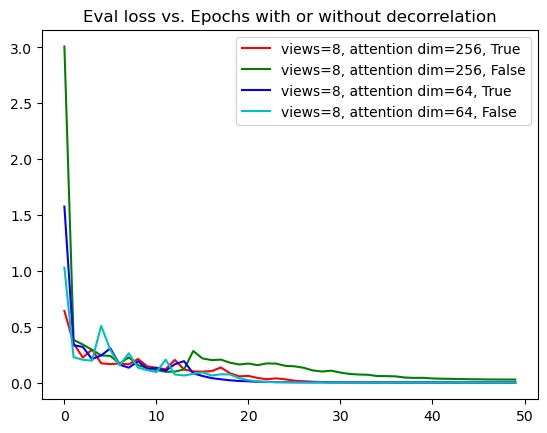

In [9]:
import matplotlib.pyplot as plt
plt.figure()

colors = ['r','g','b','c','k']
i=0

plt.plot(eval_results2[0], c=colors[0], label=f'views=8, attention dim=256, True')
plt.plot(eval_results2[1], c=colors[1], label=f'views=8, attention dim=256, False')
plt.plot(eval_results2[2], c=colors[2], label=f'views=8, attention dim=64, True')
plt.plot(eval_results2[3], c=colors[3], label=f'views=8, attention dim=64, False')
    

plt.title('Eval loss vs. Epochs with or without decorrelation')

plt.legend()
plt.show()

# Exp 4 : Effect of decorrelation

In [10]:
coreg_configs = [CoregPromptTuningConfig(task_type=TaskType.CAUSAL_LM, 
                                      num_views=8, 
                                      num_virtual_tokens=100,
                                      token_dim=1024,
                                      attention_dim=64, decorrelate=True,decorrelate_lambda=lam) for lam in [0.1,0.25,0.5,0.75,1.0]]


eval_results3= []
for config in coreg_configs:
    eval_results3.append(train(config))

trainable params: 382,400 || all params: 559,596,992 || trainable%: 0.06833489197883322


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=0: train_ppl=tensor(75.4739, device='cuda:0') train_epoch_loss=tensor(4.3238, device='cuda:0') eval_ppl=tensor(1.6272, device='cuda:0') eval_epoch_loss=tensor(0.4869, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=1: train_ppl=tensor(2.2033, device='cuda:0') train_epoch_loss=tensor(0.7900, device='cuda:0') eval_ppl=tensor(1.5116, device='cuda:0') eval_epoch_loss=tensor(0.4131, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=2: train_ppl=tensor(1.3915, device='cuda:0') train_epoch_loss=tensor(0.3304, device='cuda:0') eval_ppl=tensor(1.2715, device='cuda:0') eval_epoch_loss=tensor(0.2402, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=3: train_ppl=tensor(1.2977, device='cuda:0') train_epoch_loss=tensor(0.2606, device='cuda:0') eval_ppl=tensor(1.2497, device='cuda:0') eval_epoch_loss=tensor(0.2229, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=4: train_ppl=tensor(1.3147, device='cuda:0') train_epoch_loss=tensor(0.2736, device='cuda:0') eval_ppl=tensor(1.3444, device='cuda:0') eval_epoch_loss=tensor(0.2959, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=5: train_ppl=tensor(1.3412, device='cuda:0') train_epoch_loss=tensor(0.2936, device='cuda:0') eval_ppl=tensor(1.2812, device='cuda:0') eval_epoch_loss=tensor(0.2478, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=6: train_ppl=tensor(1.2238, device='cuda:0') train_epoch_loss=tensor(0.2020, device='cuda:0') eval_ppl=tensor(1.3072, device='cuda:0') eval_epoch_loss=tensor(0.2679, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=7: train_ppl=tensor(1.2383, device='cuda:0') train_epoch_loss=tensor(0.2138, device='cuda:0') eval_ppl=tensor(1.1928, device='cuda:0') eval_epoch_loss=tensor(0.1763, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=8: train_ppl=tensor(1.1841, device='cuda:0') train_epoch_loss=tensor(0.1690, device='cuda:0') eval_ppl=tensor(1.2065, device='cuda:0') eval_epoch_loss=tensor(0.1877, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=9: train_ppl=tensor(1.1688, device='cuda:0') train_epoch_loss=tensor(0.1560, device='cuda:0') eval_ppl=tensor(1.1988, device='cuda:0') eval_epoch_loss=tensor(0.1813, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=10: train_ppl=tensor(1.1953, device='cuda:0') train_epoch_loss=tensor(0.1784, device='cuda:0') eval_ppl=tensor(1.1916, device='cuda:0') eval_epoch_loss=tensor(0.1753, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=11: train_ppl=tensor(1.1665, device='cuda:0') train_epoch_loss=tensor(0.1540, device='cuda:0') eval_ppl=tensor(1.1390, device='cuda:0') eval_epoch_loss=tensor(0.1302, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=12: train_ppl=tensor(1.1527, device='cuda:0') train_epoch_loss=tensor(0.1421, device='cuda:0') eval_ppl=tensor(1.1293, device='cuda:0') eval_epoch_loss=tensor(0.1216, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=13: train_ppl=tensor(1.1208, device='cuda:0') train_epoch_loss=tensor(0.1141, device='cuda:0') eval_ppl=tensor(1.1090, device='cuda:0') eval_epoch_loss=tensor(0.1034, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=14: train_ppl=tensor(1.1230, device='cuda:0') train_epoch_loss=tensor(0.1160, device='cuda:0') eval_ppl=tensor(1.0920, device='cuda:0') eval_epoch_loss=tensor(0.0880, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=15: train_ppl=tensor(1.0986, device='cuda:0') train_epoch_loss=tensor(0.0940, device='cuda:0') eval_ppl=tensor(1.0786, device='cuda:0') eval_epoch_loss=tensor(0.0757, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=16: train_ppl=tensor(1.0863, device='cuda:0') train_epoch_loss=tensor(0.0828, device='cuda:0') eval_ppl=tensor(1.0804, device='cuda:0') eval_epoch_loss=tensor(0.0774, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=17: train_ppl=tensor(1.0854, device='cuda:0') train_epoch_loss=tensor(0.0819, device='cuda:0') eval_ppl=tensor(1.0588, device='cuda:0') eval_epoch_loss=tensor(0.0572, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=18: train_ppl=tensor(1.0586, device='cuda:0') train_epoch_loss=tensor(0.0570, device='cuda:0') eval_ppl=tensor(1.0713, device='cuda:0') eval_epoch_loss=tensor(0.0689, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=19: train_ppl=tensor(1.0443, device='cuda:0') train_epoch_loss=tensor(0.0434, device='cuda:0') eval_ppl=tensor(1.0443, device='cuda:0') eval_epoch_loss=tensor(0.0434, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=20: train_ppl=tensor(1.0425, device='cuda:0') train_epoch_loss=tensor(0.0416, device='cuda:0') eval_ppl=tensor(1.0279, device='cuda:0') eval_epoch_loss=tensor(0.0275, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=21: train_ppl=tensor(1.0347, device='cuda:0') train_epoch_loss=tensor(0.0341, device='cuda:0') eval_ppl=tensor(1.0192, device='cuda:0') eval_epoch_loss=tensor(0.0190, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=22: train_ppl=tensor(1.0237, device='cuda:0') train_epoch_loss=tensor(0.0234, device='cuda:0') eval_ppl=tensor(1.0171, device='cuda:0') eval_epoch_loss=tensor(0.0169, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=23: train_ppl=tensor(1.0273, device='cuda:0') train_epoch_loss=tensor(0.0269, device='cuda:0') eval_ppl=tensor(1.0132, device='cuda:0') eval_epoch_loss=tensor(0.0131, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=24: train_ppl=tensor(1.0204, device='cuda:0') train_epoch_loss=tensor(0.0202, device='cuda:0') eval_ppl=tensor(1.0230, device='cuda:0') eval_epoch_loss=tensor(0.0228, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=25: train_ppl=tensor(1.0239, device='cuda:0') train_epoch_loss=tensor(0.0236, device='cuda:0') eval_ppl=tensor(1.0112, device='cuda:0') eval_epoch_loss=tensor(0.0111, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=26: train_ppl=tensor(1.0130, device='cuda:0') train_epoch_loss=tensor(0.0129, device='cuda:0') eval_ppl=tensor(1.0095, device='cuda:0') eval_epoch_loss=tensor(0.0094, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=27: train_ppl=tensor(1.0073, device='cuda:0') train_epoch_loss=tensor(0.0073, device='cuda:0') eval_ppl=tensor(1.0072, device='cuda:0') eval_epoch_loss=tensor(0.0072, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=28: train_ppl=tensor(1.0050, device='cuda:0') train_epoch_loss=tensor(0.0050, device='cuda:0') eval_ppl=tensor(1.0033, device='cuda:0') eval_epoch_loss=tensor(0.0033, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=29: train_ppl=tensor(1.0058, device='cuda:0') train_epoch_loss=tensor(0.0057, device='cuda:0') eval_ppl=tensor(1.0046, device='cuda:0') eval_epoch_loss=tensor(0.0046, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=30: train_ppl=tensor(1.0037, device='cuda:0') train_epoch_loss=tensor(0.0037, device='cuda:0') eval_ppl=tensor(1.0029, device='cuda:0') eval_epoch_loss=tensor(0.0029, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=31: train_ppl=tensor(1.0049, device='cuda:0') train_epoch_loss=tensor(0.0049, device='cuda:0') eval_ppl=tensor(1.0034, device='cuda:0') eval_epoch_loss=tensor(0.0034, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=32: train_ppl=tensor(1.0056, device='cuda:0') train_epoch_loss=tensor(0.0056, device='cuda:0') eval_ppl=tensor(1.0016, device='cuda:0') eval_epoch_loss=tensor(0.0016, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=33: train_ppl=tensor(1.0060, device='cuda:0') train_epoch_loss=tensor(0.0060, device='cuda:0') eval_ppl=tensor(1.0019, device='cuda:0') eval_epoch_loss=tensor(0.0019, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=34: train_ppl=tensor(1.0095, device='cuda:0') train_epoch_loss=tensor(0.0094, device='cuda:0') eval_ppl=tensor(1.0014, device='cuda:0') eval_epoch_loss=tensor(0.0014, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=35: train_ppl=tensor(1.0059, device='cuda:0') train_epoch_loss=tensor(0.0059, device='cuda:0') eval_ppl=tensor(1.0085, device='cuda:0') eval_epoch_loss=tensor(0.0085, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=36: train_ppl=tensor(1.0141, device='cuda:0') train_epoch_loss=tensor(0.0140, device='cuda:0') eval_ppl=tensor(1.0017, device='cuda:0') eval_epoch_loss=tensor(0.0016, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=37: train_ppl=tensor(1.0161, device='cuda:0') train_epoch_loss=tensor(0.0159, device='cuda:0') eval_ppl=tensor(1.0049, device='cuda:0') eval_epoch_loss=tensor(0.0049, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=38: train_ppl=tensor(1.0162, device='cuda:0') train_epoch_loss=tensor(0.0161, device='cuda:0') eval_ppl=tensor(1.0031, device='cuda:0') eval_epoch_loss=tensor(0.0031, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=39: train_ppl=tensor(1.0110, device='cuda:0') train_epoch_loss=tensor(0.0110, device='cuda:0') eval_ppl=tensor(1.0062, device='cuda:0') eval_epoch_loss=tensor(0.0062, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=40: train_ppl=tensor(1.0049, device='cuda:0') train_epoch_loss=tensor(0.0049, device='cuda:0') eval_ppl=tensor(1.0226, device='cuda:0') eval_epoch_loss=tensor(0.0223, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=41: train_ppl=tensor(1.0172, device='cuda:0') train_epoch_loss=tensor(0.0171, device='cuda:0') eval_ppl=tensor(1.0023, device='cuda:0') eval_epoch_loss=tensor(0.0023, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=42: train_ppl=tensor(1.0061, device='cuda:0') train_epoch_loss=tensor(0.0061, device='cuda:0') eval_ppl=tensor(1.0071, device='cuda:0') eval_epoch_loss=tensor(0.0071, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=43: train_ppl=tensor(1.0042, device='cuda:0') train_epoch_loss=tensor(0.0042, device='cuda:0') eval_ppl=tensor(1.0019, device='cuda:0') eval_epoch_loss=tensor(0.0019, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=44: train_ppl=tensor(1.0013, device='cuda:0') train_epoch_loss=tensor(0.0013, device='cuda:0') eval_ppl=tensor(1.0014, device='cuda:0') eval_epoch_loss=tensor(0.0014, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=45: train_ppl=tensor(1.0016, device='cuda:0') train_epoch_loss=tensor(0.0016, device='cuda:0') eval_ppl=tensor(1.0015, device='cuda:0') eval_epoch_loss=tensor(0.0015, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=46: train_ppl=tensor(1.0015, device='cuda:0') train_epoch_loss=tensor(0.0015, device='cuda:0') eval_ppl=tensor(1.0014, device='cuda:0') eval_epoch_loss=tensor(0.0014, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=47: train_ppl=tensor(1.0013, device='cuda:0') train_epoch_loss=tensor(0.0013, device='cuda:0') eval_ppl=tensor(1.0012, device='cuda:0') eval_epoch_loss=tensor(0.0012, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=48: train_ppl=tensor(1.0012, device='cuda:0') train_epoch_loss=tensor(0.0012, device='cuda:0') eval_ppl=tensor(1.0011, device='cuda:0') eval_epoch_loss=tensor(0.0011, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=49: train_ppl=tensor(1.0012, device='cuda:0') train_epoch_loss=tensor(0.0012, device='cuda:0') eval_ppl=tensor(1.0011, device='cuda:0') eval_epoch_loss=tensor(0.0011, device='cuda:0')
trainable params: 382,400 || all params: 559,596,992 || trainable%: 0.06833489197883322


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=0: train_ppl=tensor(208.8027, device='cuda:0') train_epoch_loss=tensor(5.3414, device='cuda:0') eval_ppl=tensor(3.4016, device='cuda:0') eval_epoch_loss=tensor(1.2242, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


epoch=1: train_ppl=tensor(1.8548, device='cuda:0') train_epoch_loss=tensor(0.6178, device='cuda:0') eval_ppl=tensor(1.4880, device='cuda:0') eval_epoch_loss=tensor(0.3974, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


epoch=2: train_ppl=tensor(1.3286, device='cuda:0') train_epoch_loss=tensor(0.2841, device='cuda:0') eval_ppl=tensor(1.3176, device='cuda:0') eval_epoch_loss=tensor(0.2758, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=3: train_ppl=tensor(1.3110, device='cuda:0') train_epoch_loss=tensor(0.2708, device='cuda:0') eval_ppl=tensor(1.2496, device='cuda:0') eval_epoch_loss=tensor(0.2228, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=4: train_ppl=tensor(1.3307, device='cuda:0') train_epoch_loss=tensor(0.2857, device='cuda:0') eval_ppl=tensor(1.2846, device='cuda:0') eval_epoch_loss=tensor(0.2505, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=5: train_ppl=tensor(1.2622, device='cuda:0') train_epoch_loss=tensor(0.2328, device='cuda:0') eval_ppl=tensor(1.1973, device='cuda:0') eval_epoch_loss=tensor(0.1800, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=6: train_ppl=tensor(1.1859, device='cuda:0') train_epoch_loss=tensor(0.1705, device='cuda:0') eval_ppl=tensor(1.1529, device='cuda:0') eval_epoch_loss=tensor(0.1423, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=7: train_ppl=tensor(1.1739, device='cuda:0') train_epoch_loss=tensor(0.1604, device='cuda:0') eval_ppl=tensor(1.2003, device='cuda:0') eval_epoch_loss=tensor(0.1825, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


epoch=8: train_ppl=tensor(1.1659, device='cuda:0') train_epoch_loss=tensor(0.1535, device='cuda:0') eval_ppl=tensor(1.1837, device='cuda:0') eval_epoch_loss=tensor(0.1687, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


epoch=9: train_ppl=tensor(1.1472, device='cuda:0') train_epoch_loss=tensor(0.1373, device='cuda:0') eval_ppl=tensor(1.1155, device='cuda:0') eval_epoch_loss=tensor(0.1093, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


epoch=10: train_ppl=tensor(1.1106, device='cuda:0') train_epoch_loss=tensor(0.1049, device='cuda:0') eval_ppl=tensor(1.0778, device='cuda:0') eval_epoch_loss=tensor(0.0750, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


epoch=11: train_ppl=tensor(1.0754, device='cuda:0') train_epoch_loss=tensor(0.0727, device='cuda:0') eval_ppl=tensor(1.0580, device='cuda:0') eval_epoch_loss=tensor(0.0564, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=12: train_ppl=tensor(1.0615, device='cuda:0') train_epoch_loss=tensor(0.0597, device='cuda:0') eval_ppl=tensor(1.0474, device='cuda:0') eval_epoch_loss=tensor(0.0463, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


epoch=13: train_ppl=tensor(1.0596, device='cuda:0') train_epoch_loss=tensor(0.0579, device='cuda:0') eval_ppl=tensor(1.0440, device='cuda:0') eval_epoch_loss=tensor(0.0430, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=14: train_ppl=tensor(1.0506, device='cuda:0') train_epoch_loss=tensor(0.0494, device='cuda:0') eval_ppl=tensor(1.0540, device='cuda:0') eval_epoch_loss=tensor(0.0526, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=15: train_ppl=tensor(1.0467, device='cuda:0') train_epoch_loss=tensor(0.0456, device='cuda:0') eval_ppl=tensor(1.0294, device='cuda:0') eval_epoch_loss=tensor(0.0290, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=16: train_ppl=tensor(1.0439, device='cuda:0') train_epoch_loss=tensor(0.0430, device='cuda:0') eval_ppl=tensor(1.0125, device='cuda:0') eval_epoch_loss=tensor(0.0124, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=17: train_ppl=tensor(1.0348, device='cuda:0') train_epoch_loss=tensor(0.0343, device='cuda:0') eval_ppl=tensor(1.0366, device='cuda:0') eval_epoch_loss=tensor(0.0360, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=18: train_ppl=tensor(1.0375, device='cuda:0') train_epoch_loss=tensor(0.0368, device='cuda:0') eval_ppl=tensor(1.0258, device='cuda:0') eval_epoch_loss=tensor(0.0254, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=19: train_ppl=tensor(1.0286, device='cuda:0') train_epoch_loss=tensor(0.0282, device='cuda:0') eval_ppl=tensor(1.0323, device='cuda:0') eval_epoch_loss=tensor(0.0318, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=20: train_ppl=tensor(1.0341, device='cuda:0') train_epoch_loss=tensor(0.0336, device='cuda:0') eval_ppl=tensor(1.0163, device='cuda:0') eval_epoch_loss=tensor(0.0162, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=21: train_ppl=tensor(1.0817, device='cuda:0') train_epoch_loss=tensor(0.0786, device='cuda:0') eval_ppl=tensor(1.0995, device='cuda:0') eval_epoch_loss=tensor(0.0948, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=22: train_ppl=tensor(1.0771, device='cuda:0') train_epoch_loss=tensor(0.0742, device='cuda:0') eval_ppl=tensor(1.0643, device='cuda:0') eval_epoch_loss=tensor(0.0624, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=23: train_ppl=tensor(1.0512, device='cuda:0') train_epoch_loss=tensor(0.0499, device='cuda:0') eval_ppl=tensor(1.0462, device='cuda:0') eval_epoch_loss=tensor(0.0451, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.30it/s]


epoch=24: train_ppl=tensor(1.0287, device='cuda:0') train_epoch_loss=tensor(0.0283, device='cuda:0') eval_ppl=tensor(1.0112, device='cuda:0') eval_epoch_loss=tensor(0.0112, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


epoch=25: train_ppl=tensor(1.0153, device='cuda:0') train_epoch_loss=tensor(0.0152, device='cuda:0') eval_ppl=tensor(1.0144, device='cuda:0') eval_epoch_loss=tensor(0.0143, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=26: train_ppl=tensor(1.0102, device='cuda:0') train_epoch_loss=tensor(0.0102, device='cuda:0') eval_ppl=tensor(1.0046, device='cuda:0') eval_epoch_loss=tensor(0.0046, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


epoch=27: train_ppl=tensor(1.0040, device='cuda:0') train_epoch_loss=tensor(0.0039, device='cuda:0') eval_ppl=tensor(1.0024, device='cuda:0') eval_epoch_loss=tensor(0.0024, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=28: train_ppl=tensor(1.0016, device='cuda:0') train_epoch_loss=tensor(0.0016, device='cuda:0') eval_ppl=tensor(1.0012, device='cuda:0') eval_epoch_loss=tensor(0.0012, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=29: train_ppl=tensor(1.0014, device='cuda:0') train_epoch_loss=tensor(0.0014, device='cuda:0') eval_ppl=tensor(1.0013, device='cuda:0') eval_epoch_loss=tensor(0.0012, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=30: train_ppl=tensor(1.0010, device='cuda:0') train_epoch_loss=tensor(0.0010, device='cuda:0') eval_ppl=tensor(1.0008, device='cuda:0') eval_epoch_loss=tensor(0.0008, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=31: train_ppl=tensor(1.0008, device='cuda:0') train_epoch_loss=tensor(0.0008, device='cuda:0') eval_ppl=tensor(1.0006, device='cuda:0') eval_epoch_loss=tensor(0.0006, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=32: train_ppl=tensor(1.0006, device='cuda:0') train_epoch_loss=tensor(0.0006, device='cuda:0') eval_ppl=tensor(1.0005, device='cuda:0') eval_epoch_loss=tensor(0.0005, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=33: train_ppl=tensor(1.0005, device='cuda:0') train_epoch_loss=tensor(0.0005, device='cuda:0') eval_ppl=tensor(1.0005, device='cuda:0') eval_epoch_loss=tensor(0.0005, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=34: train_ppl=tensor(1.0005, device='cuda:0') train_epoch_loss=tensor(0.0005, device='cuda:0') eval_ppl=tensor(1.0004, device='cuda:0') eval_epoch_loss=tensor(0.0004, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=35: train_ppl=tensor(1.0004, device='cuda:0') train_epoch_loss=tensor(0.0004, device='cuda:0') eval_ppl=tensor(1.0004, device='cuda:0') eval_epoch_loss=tensor(0.0004, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=36: train_ppl=tensor(1.0004, device='cuda:0') train_epoch_loss=tensor(0.0004, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=37: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=38: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=39: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=40: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=41: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=42: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=43: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=44: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=45: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=46: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


epoch=47: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


epoch=48: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.30it/s]


epoch=49: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')
trainable params: 382,400 || all params: 559,596,992 || trainable%: 0.06833489197883322


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=0: train_ppl=tensor(627.8479, device='cuda:0') train_epoch_loss=tensor(6.4423, device='cuda:0') eval_ppl=tensor(11.5474, device='cuda:0') eval_epoch_loss=tensor(2.4465, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=1: train_ppl=tensor(3.5967, device='cuda:0') train_epoch_loss=tensor(1.2800, device='cuda:0') eval_ppl=tensor(1.7227, device='cuda:0') eval_epoch_loss=tensor(0.5439, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=2: train_ppl=tensor(2.1780, device='cuda:0') train_epoch_loss=tensor(0.7784, device='cuda:0') eval_ppl=tensor(1.3784, device='cuda:0') eval_epoch_loss=tensor(0.3209, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=3: train_ppl=tensor(1.5603, device='cuda:0') train_epoch_loss=tensor(0.4449, device='cuda:0') eval_ppl=tensor(1.3871, device='cuda:0') eval_epoch_loss=tensor(0.3272, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


epoch=4: train_ppl=tensor(1.4152, device='cuda:0') train_epoch_loss=tensor(0.3472, device='cuda:0') eval_ppl=tensor(1.2873, device='cuda:0') eval_epoch_loss=tensor(0.2526, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=5: train_ppl=tensor(1.2732, device='cuda:0') train_epoch_loss=tensor(0.2415, device='cuda:0') eval_ppl=tensor(1.2234, device='cuda:0') eval_epoch_loss=tensor(0.2016, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


epoch=6: train_ppl=tensor(1.2581, device='cuda:0') train_epoch_loss=tensor(0.2296, device='cuda:0') eval_ppl=tensor(1.2638, device='cuda:0') eval_epoch_loss=tensor(0.2342, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=7: train_ppl=tensor(1.2431, device='cuda:0') train_epoch_loss=tensor(0.2176, device='cuda:0') eval_ppl=tensor(1.2266, device='cuda:0') eval_epoch_loss=tensor(0.2042, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=8: train_ppl=tensor(1.1996, device='cuda:0') train_epoch_loss=tensor(0.1820, device='cuda:0') eval_ppl=tensor(1.2144, device='cuda:0') eval_epoch_loss=tensor(0.1943, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=9: train_ppl=tensor(1.1822, device='cuda:0') train_epoch_loss=tensor(0.1674, device='cuda:0') eval_ppl=tensor(1.2003, device='cuda:0') eval_epoch_loss=tensor(0.1826, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=10: train_ppl=tensor(1.1997, device='cuda:0') train_epoch_loss=tensor(0.1821, device='cuda:0') eval_ppl=tensor(1.2355, device='cuda:0') eval_epoch_loss=tensor(0.2115, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=11: train_ppl=tensor(1.1296, device='cuda:0') train_epoch_loss=tensor(0.1219, device='cuda:0') eval_ppl=tensor(1.2106, device='cuda:0') eval_epoch_loss=tensor(0.1911, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=12: train_ppl=tensor(1.1580, device='cuda:0') train_epoch_loss=tensor(0.1467, device='cuda:0') eval_ppl=tensor(1.1843, device='cuda:0') eval_epoch_loss=tensor(0.1691, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=13: train_ppl=tensor(1.1506, device='cuda:0') train_epoch_loss=tensor(0.1403, device='cuda:0') eval_ppl=tensor(1.1020, device='cuda:0') eval_epoch_loss=tensor(0.0971, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=14: train_ppl=tensor(1.1102, device='cuda:0') train_epoch_loss=tensor(0.1046, device='cuda:0') eval_ppl=tensor(1.0865, device='cuda:0') eval_epoch_loss=tensor(0.0830, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


epoch=15: train_ppl=tensor(1.1030, device='cuda:0') train_epoch_loss=tensor(0.0980, device='cuda:0') eval_ppl=tensor(1.0855, device='cuda:0') eval_epoch_loss=tensor(0.0821, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=16: train_ppl=tensor(1.0838, device='cuda:0') train_epoch_loss=tensor(0.0805, device='cuda:0') eval_ppl=tensor(1.0602, device='cuda:0') eval_epoch_loss=tensor(0.0585, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=17: train_ppl=tensor(1.0760, device='cuda:0') train_epoch_loss=tensor(0.0733, device='cuda:0') eval_ppl=tensor(1.0697, device='cuda:0') eval_epoch_loss=tensor(0.0673, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=18: train_ppl=tensor(1.0651, device='cuda:0') train_epoch_loss=tensor(0.0631, device='cuda:0') eval_ppl=tensor(1.0462, device='cuda:0') eval_epoch_loss=tensor(0.0451, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=19: train_ppl=tensor(1.0556, device='cuda:0') train_epoch_loss=tensor(0.0541, device='cuda:0') eval_ppl=tensor(1.0308, device='cuda:0') eval_epoch_loss=tensor(0.0304, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=20: train_ppl=tensor(1.0461, device='cuda:0') train_epoch_loss=tensor(0.0451, device='cuda:0') eval_ppl=tensor(1.0263, device='cuda:0') eval_epoch_loss=tensor(0.0259, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=21: train_ppl=tensor(1.0276, device='cuda:0') train_epoch_loss=tensor(0.0272, device='cuda:0') eval_ppl=tensor(1.0206, device='cuda:0') eval_epoch_loss=tensor(0.0204, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


epoch=22: train_ppl=tensor(1.0246, device='cuda:0') train_epoch_loss=tensor(0.0243, device='cuda:0') eval_ppl=tensor(1.0400, device='cuda:0') eval_epoch_loss=tensor(0.0392, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=23: train_ppl=tensor(1.0452, device='cuda:0') train_epoch_loss=tensor(0.0442, device='cuda:0') eval_ppl=tensor(1.0175, device='cuda:0') eval_epoch_loss=tensor(0.0173, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


epoch=24: train_ppl=tensor(1.0393, device='cuda:0') train_epoch_loss=tensor(0.0385, device='cuda:0') eval_ppl=tensor(1.0274, device='cuda:0') eval_epoch_loss=tensor(0.0270, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=25: train_ppl=tensor(1.0223, device='cuda:0') train_epoch_loss=tensor(0.0221, device='cuda:0') eval_ppl=tensor(1.0112, device='cuda:0') eval_epoch_loss=tensor(0.0112, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=26: train_ppl=tensor(1.0110, device='cuda:0') train_epoch_loss=tensor(0.0109, device='cuda:0') eval_ppl=tensor(1.0072, device='cuda:0') eval_epoch_loss=tensor(0.0072, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=27: train_ppl=tensor(1.0057, device='cuda:0') train_epoch_loss=tensor(0.0057, device='cuda:0') eval_ppl=tensor(1.0054, device='cuda:0') eval_epoch_loss=tensor(0.0054, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=28: train_ppl=tensor(1.0051, device='cuda:0') train_epoch_loss=tensor(0.0051, device='cuda:0') eval_ppl=tensor(1.0044, device='cuda:0') eval_epoch_loss=tensor(0.0044, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=29: train_ppl=tensor(1.0053, device='cuda:0') train_epoch_loss=tensor(0.0053, device='cuda:0') eval_ppl=tensor(1.0035, device='cuda:0') eval_epoch_loss=tensor(0.0035, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


epoch=30: train_ppl=tensor(1.0034, device='cuda:0') train_epoch_loss=tensor(0.0034, device='cuda:0') eval_ppl=tensor(1.0041, device='cuda:0') eval_epoch_loss=tensor(0.0041, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=31: train_ppl=tensor(1.0036, device='cuda:0') train_epoch_loss=tensor(0.0036, device='cuda:0') eval_ppl=tensor(1.0030, device='cuda:0') eval_epoch_loss=tensor(0.0030, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=32: train_ppl=tensor(1.0028, device='cuda:0') train_epoch_loss=tensor(0.0028, device='cuda:0') eval_ppl=tensor(1.0025, device='cuda:0') eval_epoch_loss=tensor(0.0025, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


epoch=33: train_ppl=tensor(1.0025, device='cuda:0') train_epoch_loss=tensor(0.0025, device='cuda:0') eval_ppl=tensor(1.0023, device='cuda:0') eval_epoch_loss=tensor(0.0023, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=34: train_ppl=tensor(1.0024, device='cuda:0') train_epoch_loss=tensor(0.0023, device='cuda:0') eval_ppl=tensor(1.0022, device='cuda:0') eval_epoch_loss=tensor(0.0022, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=35: train_ppl=tensor(1.0022, device='cuda:0') train_epoch_loss=tensor(0.0021, device='cuda:0') eval_ppl=tensor(1.0021, device='cuda:0') eval_epoch_loss=tensor(0.0021, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=36: train_ppl=tensor(1.0022, device='cuda:0') train_epoch_loss=tensor(0.0022, device='cuda:0') eval_ppl=tensor(1.0019, device='cuda:0') eval_epoch_loss=tensor(0.0019, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=37: train_ppl=tensor(1.0020, device='cuda:0') train_epoch_loss=tensor(0.0020, device='cuda:0') eval_ppl=tensor(1.0018, device='cuda:0') eval_epoch_loss=tensor(0.0018, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=38: train_ppl=tensor(1.0018, device='cuda:0') train_epoch_loss=tensor(0.0018, device='cuda:0') eval_ppl=tensor(1.0017, device='cuda:0') eval_epoch_loss=tensor(0.0017, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=39: train_ppl=tensor(1.0018, device='cuda:0') train_epoch_loss=tensor(0.0018, device='cuda:0') eval_ppl=tensor(1.0017, device='cuda:0') eval_epoch_loss=tensor(0.0017, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=40: train_ppl=tensor(1.0017, device='cuda:0') train_epoch_loss=tensor(0.0017, device='cuda:0') eval_ppl=tensor(1.0016, device='cuda:0') eval_epoch_loss=tensor(0.0016, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=41: train_ppl=tensor(1.0017, device='cuda:0') train_epoch_loss=tensor(0.0017, device='cuda:0') eval_ppl=tensor(1.0016, device='cuda:0') eval_epoch_loss=tensor(0.0016, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=42: train_ppl=tensor(1.0016, device='cuda:0') train_epoch_loss=tensor(0.0016, device='cuda:0') eval_ppl=tensor(1.0015, device='cuda:0') eval_epoch_loss=tensor(0.0015, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


epoch=43: train_ppl=tensor(1.0015, device='cuda:0') train_epoch_loss=tensor(0.0015, device='cuda:0') eval_ppl=tensor(1.0015, device='cuda:0') eval_epoch_loss=tensor(0.0015, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


epoch=44: train_ppl=tensor(1.0016, device='cuda:0') train_epoch_loss=tensor(0.0016, device='cuda:0') eval_ppl=tensor(1.0015, device='cuda:0') eval_epoch_loss=tensor(0.0015, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=45: train_ppl=tensor(1.0015, device='cuda:0') train_epoch_loss=tensor(0.0015, device='cuda:0') eval_ppl=tensor(1.0015, device='cuda:0') eval_epoch_loss=tensor(0.0015, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=46: train_ppl=tensor(1.0015, device='cuda:0') train_epoch_loss=tensor(0.0015, device='cuda:0') eval_ppl=tensor(1.0014, device='cuda:0') eval_epoch_loss=tensor(0.0014, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=47: train_ppl=tensor(1.0014, device='cuda:0') train_epoch_loss=tensor(0.0014, device='cuda:0') eval_ppl=tensor(1.0014, device='cuda:0') eval_epoch_loss=tensor(0.0014, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=48: train_ppl=tensor(1.0014, device='cuda:0') train_epoch_loss=tensor(0.0014, device='cuda:0') eval_ppl=tensor(1.0014, device='cuda:0') eval_epoch_loss=tensor(0.0014, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


epoch=49: train_ppl=tensor(1.0015, device='cuda:0') train_epoch_loss=tensor(0.0015, device='cuda:0') eval_ppl=tensor(1.0014, device='cuda:0') eval_epoch_loss=tensor(0.0014, device='cuda:0')
trainable params: 382,400 || all params: 559,596,992 || trainable%: 0.06833489197883322


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=0: train_ppl=tensor(1627.2808, device='cuda:0') train_epoch_loss=tensor(7.3947, device='cuda:0') eval_ppl=tensor(45.2973, device='cuda:0') eval_epoch_loss=tensor(3.8132, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=1: train_ppl=tensor(4.4333, device='cuda:0') train_epoch_loss=tensor(1.4892, device='cuda:0') eval_ppl=tensor(1.3797, device='cuda:0') eval_epoch_loss=tensor(0.3219, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=2: train_ppl=tensor(1.7644, device='cuda:0') train_epoch_loss=tensor(0.5678, device='cuda:0') eval_ppl=tensor(1.4168, device='cuda:0') eval_epoch_loss=tensor(0.3484, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=3: train_ppl=tensor(1.3370, device='cuda:0') train_epoch_loss=tensor(0.2905, device='cuda:0') eval_ppl=tensor(1.2487, device='cuda:0') eval_epoch_loss=tensor(0.2221, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=4: train_ppl=tensor(1.4271, device='cuda:0') train_epoch_loss=tensor(0.3557, device='cuda:0') eval_ppl=tensor(1.2193, device='cuda:0') eval_epoch_loss=tensor(0.1983, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


epoch=5: train_ppl=tensor(1.3234, device='cuda:0') train_epoch_loss=tensor(0.2802, device='cuda:0') eval_ppl=tensor(1.2251, device='cuda:0') eval_epoch_loss=tensor(0.2031, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=6: train_ppl=tensor(1.2479, device='cuda:0') train_epoch_loss=tensor(0.2214, device='cuda:0') eval_ppl=tensor(1.2298, device='cuda:0') eval_epoch_loss=tensor(0.2069, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=7: train_ppl=tensor(1.2403, device='cuda:0') train_epoch_loss=tensor(0.2154, device='cuda:0') eval_ppl=tensor(1.1984, device='cuda:0') eval_epoch_loss=tensor(0.1810, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=8: train_ppl=tensor(1.2616, device='cuda:0') train_epoch_loss=tensor(0.2324, device='cuda:0') eval_ppl=tensor(1.3296, device='cuda:0') eval_epoch_loss=tensor(0.2849, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=9: train_ppl=tensor(1.3259, device='cuda:0') train_epoch_loss=tensor(0.2821, device='cuda:0') eval_ppl=tensor(1.1811, device='cuda:0') eval_epoch_loss=tensor(0.1665, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=10: train_ppl=tensor(1.1911, device='cuda:0') train_epoch_loss=tensor(0.1749, device='cuda:0') eval_ppl=tensor(1.1963, device='cuda:0') eval_epoch_loss=tensor(0.1792, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=11: train_ppl=tensor(1.2017, device='cuda:0') train_epoch_loss=tensor(0.1837, device='cuda:0') eval_ppl=tensor(1.1538, device='cuda:0') eval_epoch_loss=tensor(0.1430, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=12: train_ppl=tensor(1.1403, device='cuda:0') train_epoch_loss=tensor(0.1313, device='cuda:0') eval_ppl=tensor(1.2132, device='cuda:0') eval_epoch_loss=tensor(0.1933, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=13: train_ppl=tensor(1.2134, device='cuda:0') train_epoch_loss=tensor(0.1934, device='cuda:0') eval_ppl=tensor(1.0961, device='cuda:0') eval_epoch_loss=tensor(0.0917, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=14: train_ppl=tensor(1.0913, device='cuda:0') train_epoch_loss=tensor(0.0874, device='cuda:0') eval_ppl=tensor(1.1064, device='cuda:0') eval_epoch_loss=tensor(0.1011, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=15: train_ppl=tensor(1.0936, device='cuda:0') train_epoch_loss=tensor(0.0895, device='cuda:0') eval_ppl=tensor(1.0609, device='cuda:0') eval_epoch_loss=tensor(0.0591, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=16: train_ppl=tensor(1.0712, device='cuda:0') train_epoch_loss=tensor(0.0688, device='cuda:0') eval_ppl=tensor(1.0432, device='cuda:0') eval_epoch_loss=tensor(0.0423, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=17: train_ppl=tensor(1.0440, device='cuda:0') train_epoch_loss=tensor(0.0430, device='cuda:0') eval_ppl=tensor(1.0230, device='cuda:0') eval_epoch_loss=tensor(0.0227, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=18: train_ppl=tensor(1.0371, device='cuda:0') train_epoch_loss=tensor(0.0364, device='cuda:0') eval_ppl=tensor(1.0174, device='cuda:0') eval_epoch_loss=tensor(0.0173, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=19: train_ppl=tensor(1.0229, device='cuda:0') train_epoch_loss=tensor(0.0227, device='cuda:0') eval_ppl=tensor(1.0146, device='cuda:0') eval_epoch_loss=tensor(0.0145, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=20: train_ppl=tensor(1.0120, device='cuda:0') train_epoch_loss=tensor(0.0120, device='cuda:0') eval_ppl=tensor(1.0097, device='cuda:0') eval_epoch_loss=tensor(0.0096, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=21: train_ppl=tensor(1.0067, device='cuda:0') train_epoch_loss=tensor(0.0067, device='cuda:0') eval_ppl=tensor(1.0052, device='cuda:0') eval_epoch_loss=tensor(0.0052, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=22: train_ppl=tensor(1.0050, device='cuda:0') train_epoch_loss=tensor(0.0050, device='cuda:0') eval_ppl=tensor(1.0039, device='cuda:0') eval_epoch_loss=tensor(0.0039, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=23: train_ppl=tensor(1.0032, device='cuda:0') train_epoch_loss=tensor(0.0032, device='cuda:0') eval_ppl=tensor(1.0027, device='cuda:0') eval_epoch_loss=tensor(0.0027, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=24: train_ppl=tensor(1.0025, device='cuda:0') train_epoch_loss=tensor(0.0025, device='cuda:0') eval_ppl=tensor(1.0019, device='cuda:0') eval_epoch_loss=tensor(0.0019, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=25: train_ppl=tensor(1.0019, device='cuda:0') train_epoch_loss=tensor(0.0019, device='cuda:0') eval_ppl=tensor(1.0015, device='cuda:0') eval_epoch_loss=tensor(0.0015, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=26: train_ppl=tensor(1.0015, device='cuda:0') train_epoch_loss=tensor(0.0015, device='cuda:0') eval_ppl=tensor(1.0013, device='cuda:0') eval_epoch_loss=tensor(0.0013, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=27: train_ppl=tensor(1.0013, device='cuda:0') train_epoch_loss=tensor(0.0013, device='cuda:0') eval_ppl=tensor(1.0011, device='cuda:0') eval_epoch_loss=tensor(0.0011, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=28: train_ppl=tensor(1.0011, device='cuda:0') train_epoch_loss=tensor(0.0011, device='cuda:0') eval_ppl=tensor(1.0010, device='cuda:0') eval_epoch_loss=tensor(0.0010, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=29: train_ppl=tensor(1.0011, device='cuda:0') train_epoch_loss=tensor(0.0011, device='cuda:0') eval_ppl=tensor(1.0009, device='cuda:0') eval_epoch_loss=tensor(0.0009, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=30: train_ppl=tensor(1.0010, device='cuda:0') train_epoch_loss=tensor(0.0010, device='cuda:0') eval_ppl=tensor(1.0009, device='cuda:0') eval_epoch_loss=tensor(0.0009, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=31: train_ppl=tensor(1.0009, device='cuda:0') train_epoch_loss=tensor(0.0009, device='cuda:0') eval_ppl=tensor(1.0008, device='cuda:0') eval_epoch_loss=tensor(0.0008, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=32: train_ppl=tensor(1.0008, device='cuda:0') train_epoch_loss=tensor(0.0008, device='cuda:0') eval_ppl=tensor(1.0008, device='cuda:0') eval_epoch_loss=tensor(0.0008, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=33: train_ppl=tensor(1.0008, device='cuda:0') train_epoch_loss=tensor(0.0008, device='cuda:0') eval_ppl=tensor(1.0007, device='cuda:0') eval_epoch_loss=tensor(0.0007, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=34: train_ppl=tensor(1.0007, device='cuda:0') train_epoch_loss=tensor(0.0007, device='cuda:0') eval_ppl=tensor(1.0007, device='cuda:0') eval_epoch_loss=tensor(0.0007, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=35: train_ppl=tensor(1.0007, device='cuda:0') train_epoch_loss=tensor(0.0007, device='cuda:0') eval_ppl=tensor(1.0007, device='cuda:0') eval_epoch_loss=tensor(0.0007, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=36: train_ppl=tensor(1.0007, device='cuda:0') train_epoch_loss=tensor(0.0007, device='cuda:0') eval_ppl=tensor(1.0006, device='cuda:0') eval_epoch_loss=tensor(0.0006, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=37: train_ppl=tensor(1.0006, device='cuda:0') train_epoch_loss=tensor(0.0006, device='cuda:0') eval_ppl=tensor(1.0006, device='cuda:0') eval_epoch_loss=tensor(0.0006, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


epoch=38: train_ppl=tensor(1.0006, device='cuda:0') train_epoch_loss=tensor(0.0006, device='cuda:0') eval_ppl=tensor(1.0006, device='cuda:0') eval_epoch_loss=tensor(0.0006, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


epoch=39: train_ppl=tensor(1.0006, device='cuda:0') train_epoch_loss=tensor(0.0006, device='cuda:0') eval_ppl=tensor(1.0006, device='cuda:0') eval_epoch_loss=tensor(0.0006, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


epoch=40: train_ppl=tensor(1.0006, device='cuda:0') train_epoch_loss=tensor(0.0006, device='cuda:0') eval_ppl=tensor(1.0006, device='cuda:0') eval_epoch_loss=tensor(0.0006, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=41: train_ppl=tensor(1.0006, device='cuda:0') train_epoch_loss=tensor(0.0006, device='cuda:0') eval_ppl=tensor(1.0006, device='cuda:0') eval_epoch_loss=tensor(0.0006, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=42: train_ppl=tensor(1.0006, device='cuda:0') train_epoch_loss=tensor(0.0006, device='cuda:0') eval_ppl=tensor(1.0005, device='cuda:0') eval_epoch_loss=tensor(0.0005, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=43: train_ppl=tensor(1.0006, device='cuda:0') train_epoch_loss=tensor(0.0006, device='cuda:0') eval_ppl=tensor(1.0005, device='cuda:0') eval_epoch_loss=tensor(0.0005, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=44: train_ppl=tensor(1.0005, device='cuda:0') train_epoch_loss=tensor(0.0005, device='cuda:0') eval_ppl=tensor(1.0005, device='cuda:0') eval_epoch_loss=tensor(0.0005, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=45: train_ppl=tensor(1.0005, device='cuda:0') train_epoch_loss=tensor(0.0005, device='cuda:0') eval_ppl=tensor(1.0005, device='cuda:0') eval_epoch_loss=tensor(0.0005, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=46: train_ppl=tensor(1.0006, device='cuda:0') train_epoch_loss=tensor(0.0006, device='cuda:0') eval_ppl=tensor(1.0005, device='cuda:0') eval_epoch_loss=tensor(0.0005, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


epoch=47: train_ppl=tensor(1.0006, device='cuda:0') train_epoch_loss=tensor(0.0006, device='cuda:0') eval_ppl=tensor(1.0005, device='cuda:0') eval_epoch_loss=tensor(0.0005, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=48: train_ppl=tensor(1.0005, device='cuda:0') train_epoch_loss=tensor(0.0005, device='cuda:0') eval_ppl=tensor(1.0005, device='cuda:0') eval_epoch_loss=tensor(0.0005, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=49: train_ppl=tensor(1.0006, device='cuda:0') train_epoch_loss=tensor(0.0006, device='cuda:0') eval_ppl=tensor(1.0005, device='cuda:0') eval_epoch_loss=tensor(0.0005, device='cuda:0')
trainable params: 382,400 || all params: 559,596,992 || trainable%: 0.06833489197883322


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=0: train_ppl=tensor(2421.3428, device='cuda:0') train_epoch_loss=tensor(7.7921, device='cuda:0') eval_ppl=tensor(1058.6903, device='cuda:0') eval_epoch_loss=tensor(6.9648, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=1: train_ppl=tensor(102.3541, device='cuda:0') train_epoch_loss=tensor(4.6284, device='cuda:0') eval_ppl=tensor(3.5217, device='cuda:0') eval_epoch_loss=tensor(1.2589, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=2: train_ppl=tensor(2.0345, device='cuda:0') train_epoch_loss=tensor(0.7102, device='cuda:0') eval_ppl=tensor(1.4309, device='cuda:0') eval_epoch_loss=tensor(0.3583, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=3: train_ppl=tensor(1.3156, device='cuda:0') train_epoch_loss=tensor(0.2743, device='cuda:0') eval_ppl=tensor(1.3517, device='cuda:0') eval_epoch_loss=tensor(0.3013, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


epoch=4: train_ppl=tensor(1.2878, device='cuda:0') train_epoch_loss=tensor(0.2529, device='cuda:0') eval_ppl=tensor(1.1934, device='cuda:0') eval_epoch_loss=tensor(0.1768, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


epoch=5: train_ppl=tensor(1.2278, device='cuda:0') train_epoch_loss=tensor(0.2052, device='cuda:0') eval_ppl=tensor(1.1747, device='cuda:0') eval_epoch_loss=tensor(0.1610, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=6: train_ppl=tensor(1.1912, device='cuda:0') train_epoch_loss=tensor(0.1750, device='cuda:0') eval_ppl=tensor(1.1604, device='cuda:0') eval_epoch_loss=tensor(0.1488, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=7: train_ppl=tensor(1.1394, device='cuda:0') train_epoch_loss=tensor(0.1305, device='cuda:0') eval_ppl=tensor(1.1140, device='cuda:0') eval_epoch_loss=tensor(0.1079, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=8: train_ppl=tensor(1.1543, device='cuda:0') train_epoch_loss=tensor(0.1435, device='cuda:0') eval_ppl=tensor(1.2075, device='cuda:0') eval_epoch_loss=tensor(0.1886, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=9: train_ppl=tensor(1.1465, device='cuda:0') train_epoch_loss=tensor(0.1368, device='cuda:0') eval_ppl=tensor(1.1077, device='cuda:0') eval_epoch_loss=tensor(0.1023, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=10: train_ppl=tensor(1.1305, device='cuda:0') train_epoch_loss=tensor(0.1227, device='cuda:0') eval_ppl=tensor(1.0649, device='cuda:0') eval_epoch_loss=tensor(0.0629, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=11: train_ppl=tensor(1.0891, device='cuda:0') train_epoch_loss=tensor(0.0853, device='cuda:0') eval_ppl=tensor(1.1965, device='cuda:0') eval_epoch_loss=tensor(0.1794, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=12: train_ppl=tensor(1.1410, device='cuda:0') train_epoch_loss=tensor(0.1319, device='cuda:0') eval_ppl=tensor(1.1291, device='cuda:0') eval_epoch_loss=tensor(0.1214, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=13: train_ppl=tensor(1.1040, device='cuda:0') train_epoch_loss=tensor(0.0989, device='cuda:0') eval_ppl=tensor(1.0499, device='cuda:0') eval_epoch_loss=tensor(0.0487, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


epoch=14: train_ppl=tensor(1.1256, device='cuda:0') train_epoch_loss=tensor(0.1183, device='cuda:0') eval_ppl=tensor(1.0705, device='cuda:0') eval_epoch_loss=tensor(0.0681, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


epoch=15: train_ppl=tensor(1.0597, device='cuda:0') train_epoch_loss=tensor(0.0580, device='cuda:0') eval_ppl=tensor(1.0311, device='cuda:0') eval_epoch_loss=tensor(0.0306, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


epoch=16: train_ppl=tensor(1.0343, device='cuda:0') train_epoch_loss=tensor(0.0337, device='cuda:0') eval_ppl=tensor(1.0178, device='cuda:0') eval_epoch_loss=tensor(0.0176, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=17: train_ppl=tensor(1.0173, device='cuda:0') train_epoch_loss=tensor(0.0172, device='cuda:0') eval_ppl=tensor(1.0071, device='cuda:0') eval_epoch_loss=tensor(0.0071, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=18: train_ppl=tensor(1.0063, device='cuda:0') train_epoch_loss=tensor(0.0063, device='cuda:0') eval_ppl=tensor(1.0031, device='cuda:0') eval_epoch_loss=tensor(0.0031, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=19: train_ppl=tensor(1.0028, device='cuda:0') train_epoch_loss=tensor(0.0028, device='cuda:0') eval_ppl=tensor(1.0019, device='cuda:0') eval_epoch_loss=tensor(0.0019, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=20: train_ppl=tensor(1.0026, device='cuda:0') train_epoch_loss=tensor(0.0026, device='cuda:0') eval_ppl=tensor(1.0013, device='cuda:0') eval_epoch_loss=tensor(0.0013, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=21: train_ppl=tensor(1.0016, device='cuda:0') train_epoch_loss=tensor(0.0016, device='cuda:0') eval_ppl=tensor(1.0009, device='cuda:0') eval_epoch_loss=tensor(0.0009, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=22: train_ppl=tensor(1.0010, device='cuda:0') train_epoch_loss=tensor(0.0010, device='cuda:0') eval_ppl=tensor(1.0007, device='cuda:0') eval_epoch_loss=tensor(0.0007, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=23: train_ppl=tensor(1.0008, device='cuda:0') train_epoch_loss=tensor(0.0008, device='cuda:0') eval_ppl=tensor(1.0006, device='cuda:0') eval_epoch_loss=tensor(0.0006, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=24: train_ppl=tensor(1.0007, device='cuda:0') train_epoch_loss=tensor(0.0007, device='cuda:0') eval_ppl=tensor(1.0005, device='cuda:0') eval_epoch_loss=tensor(0.0005, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


epoch=25: train_ppl=tensor(1.0006, device='cuda:0') train_epoch_loss=tensor(0.0006, device='cuda:0') eval_ppl=tensor(1.0004, device='cuda:0') eval_epoch_loss=tensor(0.0004, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=26: train_ppl=tensor(1.0006, device='cuda:0') train_epoch_loss=tensor(0.0006, device='cuda:0') eval_ppl=tensor(1.0004, device='cuda:0') eval_epoch_loss=tensor(0.0004, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=27: train_ppl=tensor(1.0005, device='cuda:0') train_epoch_loss=tensor(0.0005, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=28: train_ppl=tensor(1.0004, device='cuda:0') train_epoch_loss=tensor(0.0004, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=29: train_ppl=tensor(1.0004, device='cuda:0') train_epoch_loss=tensor(0.0004, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=30: train_ppl=tensor(1.0004, device='cuda:0') train_epoch_loss=tensor(0.0004, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=31: train_ppl=tensor(1.0004, device='cuda:0') train_epoch_loss=tensor(0.0004, device='cuda:0') eval_ppl=tensor(1.0003, device='cuda:0') eval_epoch_loss=tensor(0.0003, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=32: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0002, device='cuda:0') eval_epoch_loss=tensor(0.0002, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=33: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0002, device='cuda:0') eval_epoch_loss=tensor(0.0002, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=34: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0002, device='cuda:0') eval_epoch_loss=tensor(0.0002, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=35: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0002, device='cuda:0') eval_epoch_loss=tensor(0.0002, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=36: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0002, device='cuda:0') eval_epoch_loss=tensor(0.0002, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=37: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0002, device='cuda:0') eval_epoch_loss=tensor(0.0002, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=38: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0002, device='cuda:0') eval_epoch_loss=tensor(0.0002, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=39: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0002, device='cuda:0') eval_epoch_loss=tensor(0.0002, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=40: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0002, device='cuda:0') eval_epoch_loss=tensor(0.0002, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=41: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0002, device='cuda:0') eval_epoch_loss=tensor(0.0002, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=42: train_ppl=tensor(1.0002, device='cuda:0') train_epoch_loss=tensor(0.0002, device='cuda:0') eval_ppl=tensor(1.0002, device='cuda:0') eval_epoch_loss=tensor(0.0002, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=43: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0002, device='cuda:0') eval_epoch_loss=tensor(0.0002, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=44: train_ppl=tensor(1.0002, device='cuda:0') train_epoch_loss=tensor(0.0002, device='cuda:0') eval_ppl=tensor(1.0002, device='cuda:0') eval_epoch_loss=tensor(0.0002, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


epoch=45: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0002, device='cuda:0') eval_epoch_loss=tensor(0.0002, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=46: train_ppl=tensor(1.0002, device='cuda:0') train_epoch_loss=tensor(0.0002, device='cuda:0') eval_ppl=tensor(1.0002, device='cuda:0') eval_epoch_loss=tensor(0.0002, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


epoch=47: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0002, device='cuda:0') eval_epoch_loss=tensor(0.0002, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


epoch=48: train_ppl=tensor(1.0002, device='cuda:0') train_epoch_loss=tensor(0.0002, device='cuda:0') eval_ppl=tensor(1.0002, device='cuda:0') eval_epoch_loss=tensor(0.0002, device='cuda:0')


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]

epoch=49: train_ppl=tensor(1.0003, device='cuda:0') train_epoch_loss=tensor(0.0003, device='cuda:0') eval_ppl=tensor(1.0002, device='cuda:0') eval_epoch_loss=tensor(0.0002, device='cuda:0')


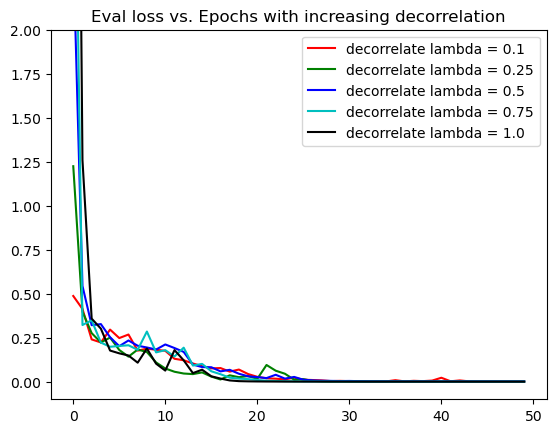

In [11]:
import matplotlib.pyplot as plt
plt.figure()

colors = ['m','r','g','b','c','k']
i=0

for lam in [0.1,0.25,0.5,0.75,1.0]:
    plt.plot(eval_results3[i], c=colors[i], label=f'decorrelate lambda = {lam}')
    i+=1

    

plt.title('Eval loss vs. Epochs with increasing decorrelation')
plt.ylim(-0.1,2)
plt.legend()
plt.show()

# Model eval

In [30]:
model.eval()
i = 27
inputs = tokenizer(f'{text_column} : {dataset["test"][i]["Tweet text"]} Label : ', return_tensors="pt")
print(dataset["test"][i]["Tweet text"])
print(inputs)

with torch.no_grad():
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(
        input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"], max_new_tokens=10, eos_token_id=3
    )
    print(outputs)
    print(tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True))

@SquareUK When will Canada get this!?
{'input_ids': tensor([[227985,   5484,    915,   2566, 147586,  38943,  13929,   2152,  17502,
           2213,   1119, 192136,  77658,    915,    210]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
tensor([[227985,   5484,    915,   2566, 147586,  38943,  13929,   2152,  17502,
           2213,   1119, 192136,  77658,    915,    210,   1936, 106863,      2,
             31,  43907,  20321,  97547,     29,   1387,   6747]],
       device='cuda:0')
['Tweet text : @SquareUK When will Canada get this!? Label : no complaint<b>Note</b>: The following']


In [31]:
# saving model
peft_model_id = f"{model_name_or_path}_{peft_config.peft_type}_{peft_config.task_type}"
model.save_pretrained(peft_model_id)

In [32]:
ckpt = f"{peft_model_id}/adapter_model.bin"
!du -h $ckpt

84K	bigscience/bloomz-560m_COREG_PROMPT_TUNING_CAUSAL_LM/adapter_model.bin


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [33]:
from peft import PeftModel, PeftConfig

peft_model_id = f"{model_name_or_path}_{peft_config.peft_type}_{peft_config.task_type}"

config = PeftConfig.from_pretrained(peft_model_id)
model = AutoModelForCausalLM.from_pretrained(config.base_model_name_or_path)
model = PeftModel.from_pretrained(model, peft_model_id)

In [34]:
model.to(device)
model.eval()
i = 43
inputs = tokenizer(f'{text_column} : {dataset["test"][i]["Tweet text"]} Label : ', return_tensors="pt")
print(dataset["test"][i]["Tweet text"])
print(inputs)

with torch.no_grad():
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(
        input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"], max_new_tokens=10, eos_token_id=3
    )
    print(outputs)
    print(tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True))

@HPSupport HP DeskJet 3630 series: Online connectivity error... nothing seems to help or work #hppsdr #ijkhelp
{'input_ids': tensor([[227985,   5484,    915,   2566,     43,   9043,  19624,  67216,   4896,
             78, 137538,  10216,   2324,  16852,     29,  33343, 141090,   6281,
           1369,  16915,  15726,    427,   7064,    791,   2909,   2550, 101367,
           4973,  11168,   2550,   3767,   8855,  80772,  77658,    915,    210]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
tensor([[227985,   5484,    915,   2566,     43,   9043,  19624,  67216,   4896,
             78, 137538,  10216,   2324,  16852,     29,  33343, 141090,   6281,
           1369,  16915,  15726,    427,   7064,    791,   2909,   2550, 101367,
           4973,  11168,   2550,   3767,   8855,  80772,  77658,    915,    210,
          16449,   5952,      2,     31,  43907,     54,  70198,    361,  177